# 1. Preamble
Import modules, define functions that may or may not end up getting used, etc...

In [1]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
'''default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)'''

mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))

def bleach_rate_from_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # if the loop gets to the end without crossing the threshold, assign NaN value to the bleaching rate
    if kk == len(Tr)-1:
        tau = np.nan
    else:
        
    # do linear interpolation between points just above and just below threshold to get 
    # "failure" time at exactly the threshold
        tau = t[kk-1] + (t[kk]-t[kk-1])*(threshold-Tr[kk-1])/(Tr[kk]-Tr[kk-1])
    
    # invert "failure time" to get bleaching rate, in 1/min
    bleach_rate = (threshold-1)/tau
    
    # return the bleaching rate
    return bleach_rate

# alternative way to extract bleaching rate: instead of taking secant approximation to degradation rate, 
# perform a linear fit to all the data up to the threshold and ignore everything else;
# if the threshold can't be reached, just fit the entire dataset
def bleach_rate_from_linear_fit_to_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # use linear polynomial fit up to threshold
    coeffs = np.polyfit(t[:kk+1],Tr_norm[:kk+1],1)
    bleach_rate = coeffs[0]
    intercept = coeffs[1]
    
    # return the bleaching rate
    return bleach_rate, intercept

# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
   
    # currently assuming no experiments beyond 5 and 105 C
    if temp < 5:
        temp = 5
    if temp > 105:
        temp = 105
    
    if temp <= 25:
        m_color = np.array([0.00,0.00,0.20]) + (temp-5)/20*np.array([0,0.2,0])
    elif temp <= 45 and temp > 25 :
        m_color = np.array([0.00,0.20,0.20]) + (temp-25)/20*np.array([0,0,-0.2])
    elif temp <= 65 and temp > 45:
        m_color = np.array([0.00,0.20,0.00]) + (temp-45)/20*np.array([0.2,0,0])
    elif temp <= 85 and temp > 65:
        m_color = np.array([0.20,0.20,0.00]) + (temp-65)/20*np.array([0,-0.2,0])
    elif temp <=105 and temp > 85:
        m_color = np.array([0.20,0.00,0.00]) + (temp-85)/20*np.array([0,0,0.2])

    # humidity encoded by brightness
    m_color *= 1.75
    rh_factor = rh*0.65/100
    for x in range(len(m_color)):
        if m_color[x] != 0:
            m_color[x] += rh_factor

    # illumination encoded by marker shape
    if illum == 0:
        m_shape = 'p'
    elif illum == 0.5:
        m_shape = '^'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 4:
        m_shape = 'h'
    elif illum == 8:
        m_shape = 'o'
    elif illum == 16:
        m_shape = 's'
    elif illum == 32:
        m_shape = 'D'
    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 45:
        m_fill = 'left'
    elif o2 < 80:
        m_fill = 'left'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.abs(time_raw-univ_horiz).idxmin() # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'mu1':'$\mu_{t=1}$',
                     'mu2':'$\mu_{t=2}$',
                     'mu3':'$\mu_{t=3}$',
                     'mu4':'$\mu_{t=4}$',
                     'mu5':'$\mu_{t=5}$',
                     'tau1':'$\\tau_{t=1}$',
                     'tau2':'$\\tau_{t=2}$',
                     'tau3':'$\\tau_{t=3}$',
                     'tau4':'$\\tau_{t=4}$',
                     'tau5':'$\\tau_{t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'O2':'$\chi_\mathrm{O_2}$',
                     'RH':'$\mathrm{RH}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'dtdT':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)^{-1}$',
                     'dtdLD':'$(\mathrm{d}L_D/\mathrm{d}t)^{-1}$',
                     'dtdPL':'$(\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t)^{-1}$',
                     'd2tdT2':'$(\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2)^{-1}$',
                     'd2tdLD2':'$(\mathrm{d^2}L_D/\mathrm{d}t^2)^{-1}$',
                     'd2tdPL2':'$(\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2)^{-1}$',
                     'mu0':'$\mu_0$',
                     'tau0':'$\\tau_0$',
                     'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
                     'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2$',
                     'AB':'$T \mathrm{RH}$',
                     'AC':'$T \chi_\mathrm{O_2}$',
                     'AD':'$T N_\mathrm{suns}$',
                     'AE':'$T x_\mathrm{MA}}$',
                     'BC':'$\mathrm{RH} \chi_\mathrm{O_2}$',
                     'BD':'$\mathrm{RH} N_\mathrm{suns}$',
                     'BE':'$\mathrm{RH} x_\mathrm{MA}}$',
                     'CD':'$\chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'CE':'$\chi_\mathrm{O_2} x_\mathrm{MA}}$',
                     'DE':'$N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABC':'$T \mathrm{RH} \chi_\mathrm{O_2}$',
                     'ABD':'$T \mathrm{RH} N_\mathrm{suns}$',
                     'ABE':'$T \mathrm{RH} x_\mathrm{MA}$',
                     'ACD':'$T \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ACE':'$T \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ADE':'$T N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCD':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'BCE':'$\mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'BDE':'$\mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'CDE':'$\chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABCD':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ABCE':'$T \mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ABDE':'$T \mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ACDE':'$T \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCDE':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ABCDE':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'log_dTdt_full':'ln$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'dTrdt_full':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'Tr_LD80':'$\mathcal{T}_{L_\mathrm{D},80}$',
                     'lnPL80':'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                     'Opt_Tol':'$\mathcal{T}_{L_\mathrm{D},80}(x_\mathrm{MA})$',
                     'Temp (deg C)':'$T$',
                     'RH (%)':'$\\varphi$',
                     'Oxygen (%)':'$\chi_\mathrm{O_2}$',
                     'Illum (Nsuns)':'$N_\mathrm{suns}$',
                     'MA fraction':'$x_\mathrm{MA}$',
                     'Bleach Rate (polyfit) (1/min)':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',#' (1st 5 points)',
                     'Bleach Rate (fit to 5% inc) (1/min)':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$ (1st 5%)',
                     'dLDdt (1/min)':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt (1/min)':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'tLD80 corrected (min)':'$t_{L_\mathrm{D},80}$',
                     'lnLD80':'ln($t_{L_\mathrm{D},80}$)'
                    }

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

In [2]:
# Read the CSV containing featurized data into the "rawdata_df" DataFrame
readpath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
#readname = '201216_Replication_Data.csv'
readname = '210222_Featurized_Data_augmented.csv'
rawdata_df = pd.read_csv(readpath+readname)



# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
rawdata_df['P_H2O'] = 101325*rawdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
rawdata_df['P_O2'] = 101325*rawdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa]

# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*rawdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = rawdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*rawdata_df['P_O2']/(1+Keq_O2*rawdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*rawdata_df['P_H2O']/(1 + Keq_H2O*rawdata_df['P_H2O'])

# activation energy for the photooxidation pathway, determined from a parabolic fit to the following:
# Ea(x_MA = 0) = 0.49 eV; Ea(x_MA = 0.5) = 0.9 eV; Ea(x_MA = 1) = 0.5 eV
x_meas = np.array([0,0.5,1]) # mole fraction
Ea_meas = np.array([0.49,0.9,0.5]) # activation energies, eV, from Arrhenius fits
Ea_fit = np.polyfit(x_meas,Ea_meas,2) # fit a parabola
x_fit = np.linspace(0,1,num=101)
#plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
rawdata_df['Ea_O2 (eV)'] = Ea_fit[0]*rawdata_df['MA fraction']**2 + Ea_fit[1]*rawdata_df['MA fraction'] + Ea_fit[2]

# rate constant for photooxidation, determined from a parabolic fit to the rate constants at 85C
ln_R0 = np.log(np.array([506.82, 8.5274e8, 2703.2]))
#ln_R0 = np.array([-9.65, -8.6, 2703.2])
R0_fit = np.polyfit(x_meas,ln_R0,2) # fit a parabola
#plt.plot(x_fit,R0_fit[0]*x_fit**2 + R0_fit[1]*x_fit + R0_fit[2])
PhOx_RC  = np.exp(R0_fit[0]*rawdata_df['MA fraction']**2 + R0_fit[1]*rawdata_df['MA fraction'] + R0_fit[2])


# assign calculated activation energy to DataFrame

# calculate electron concentration
me = 9.11e-31 # electron mass, kg
mc = 0.1*me # electron effective mass, kg
mv = 0.1*me # hole effective mass, kg
# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*(rawdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Eg = 1.6 # perovskite band gap, eV
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(rawdata_df['QFLS_0'].values/(8.617e-5*(rawdata_df['Temp (deg C)'].values+273.15))))


# assign photooxidation and hydration rates to DataFrame

# non-dimensional photo-oxidation rate (Langmuir term * Arrhenius term)
gamma = 0.7
rawdata_df['PhotoOx_rate'] = LAI_O2*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate'] = LAI_O2*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate'] = LAI_O2*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*(rawdata_df['Illum (Nsuns)']**gamma)*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = PhOx_RC*rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['PhotoOx_rate_P'] = rawdata_df['P_O2']*n_exc*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['LAI_O2'] = LAI_O2
#rawdata_df['Ox_rate_LAI'] = LAI_O2*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['Ox_rate_P'] = rawdata_df['P_O2']*np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
#rawdata_df['Arrhenius_Ox'] = np.exp(-rawdata_df['Ea_O2 (eV)']/(8.617e-5*(rawdata_df['Temp (deg C)']+273.15)))
# non-dimensional hydration rate Langmuir term * MA_fraction
rawdata_df['Hydration_rate'] = LAI_H2O#*(rawdata_df['Illum (Nsuns)']**gamma)

#rawdata_df['dtdT'] = rawdata_df['Bleach Rate (polyfit) (1/min)']**-1
#rawdata_df['dtdLD'] = rawdata_df['dLDdt (1/min)']**-1
#rawdata_df['dtdPL'] = rawdata_df['dPLdt (1/min)']**-1


# Entropy of Mixing calculation:

 
xMA=rawdata_df['MA fraction']           #MA mole fraction
xFA=0.83*(1-rawdata_df['MA fraction'])  #FA mole fraction along the composition line we've been studying as 10/5/20 MUST CHANGE FOR MORE DIVERSE COMP SET
xCs=1-xMA-xFA                           #Cs mole fraction MUST CHANGE IF QUAD CATION COMPOSITIONS CONSIDERED

rawdata_df['delS_mix'] = 0 # initalization step

for ii in range(len(xMA)):
    if xMA[ii]==1:
        rawdata_df['delS_mix'].loc[ii] = 0 #no mixing, plus delS equation reduces to this anyway
    elif xMA[ii]==0:
        rawdata_df['delS_mix'].loc[ii] = -(xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R
    else:
        rawdata_df['delS_mix'].loc[ii] = -(xMA[ii]*np.log(xMA[ii]) + xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R

rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]

C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Text(0, 0.5, 'Predicted Rate [mol m$^{-2}$ s$^{-1}$]')

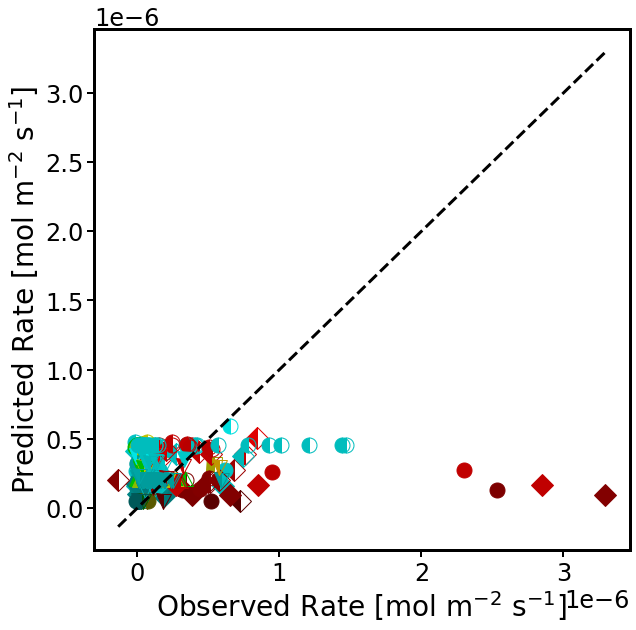

In [3]:
# use only MAPI
#rawdata_df = rawdata_df[rawdata_df['MA fraction'] == 1]
#rawdata_df = rawdata_df[rawdata_df['Temp (deg C)'] < 30]

rho = 4.16 # MAPI mass density, g/cm3
mol_mass = 620 # MAPI molar mass, g/mol
absco = 4.85e4 # MAPI absorption coefficient

# calculate the measured degradation rate in mol/m2/s
rawdata_df['Measured Rate'] = rho/mol_mass/absco*1e4*rawdata_df['Bleach Rate (polyfit) (1/min)']/60/0.069

# modeling constants
keff = 1.08555729e-8
K2 = 6.24727975e-3
K4 = 1.78053032
c = 5.00428964e-8

PH2O_kPa = rawdata_df['P_H2O']/1000
PO2_kPa = rawdata_df['P_O2']/1000

# calculate the modeled degradation rate in mol/m2/s
rawdata_df['Modeled Rate'] = c + keff*PH2O_kPa*PO2_kPa*rawdata_df['Illum (Nsuns)']**gamma/(1 + K2*PO2_kPa*(1+K4*rawdata_df['Illum (Nsuns)']**gamma))**2
# calculate the excess degradation rate beyond what is predicted by the rate model
rawdata_df['Excess Rate'] = rawdata_df['Measured Rate'] - rawdata_df['Modeled Rate']

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(rawdata_df['Measured Rate'].iloc[ii],rawdata_df['Modeled Rate'].iloc[ii],
             color=color, marker=marker, fillstyle=fill, markersize = 15)
plot_range = np.linspace(np.nanmin(rawdata_df['Measured Rate']),np.nanmax(rawdata_df['Measured Rate']),num=2)
plt.plot(plot_range,plot_range,'k--')
plt.xlabel('Observed Rate [mol m$^{-2}$ s$^{-1}$]')
plt.ylabel('Predicted Rate [mol m$^{-2}$ s$^{-1}$]')

<ipython-input-4-7e1e4972faa4>:156: RuntimeWarning: invalid value encountered in log
  ax[0].plot(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]),
<ipython-input-4-7e1e4972faa4>:166: RuntimeWarning: invalid value encountered in log
  nas = np.logical_or(np.isnan(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].values)),
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'y = 0.46x + 3.58')

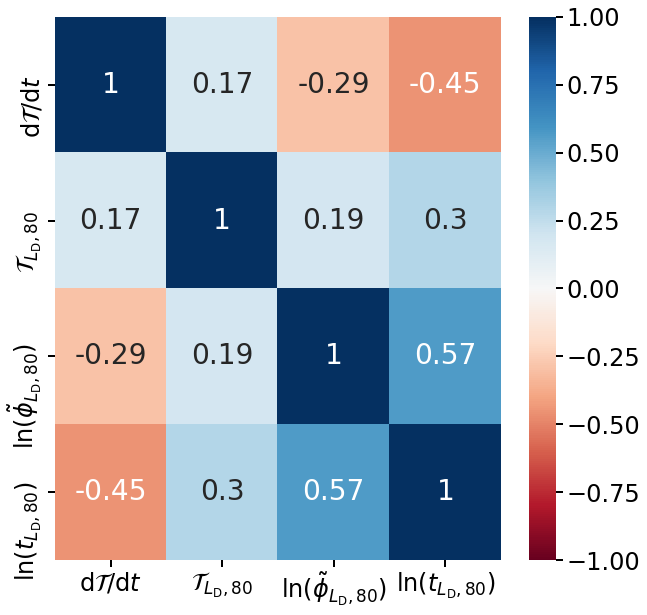

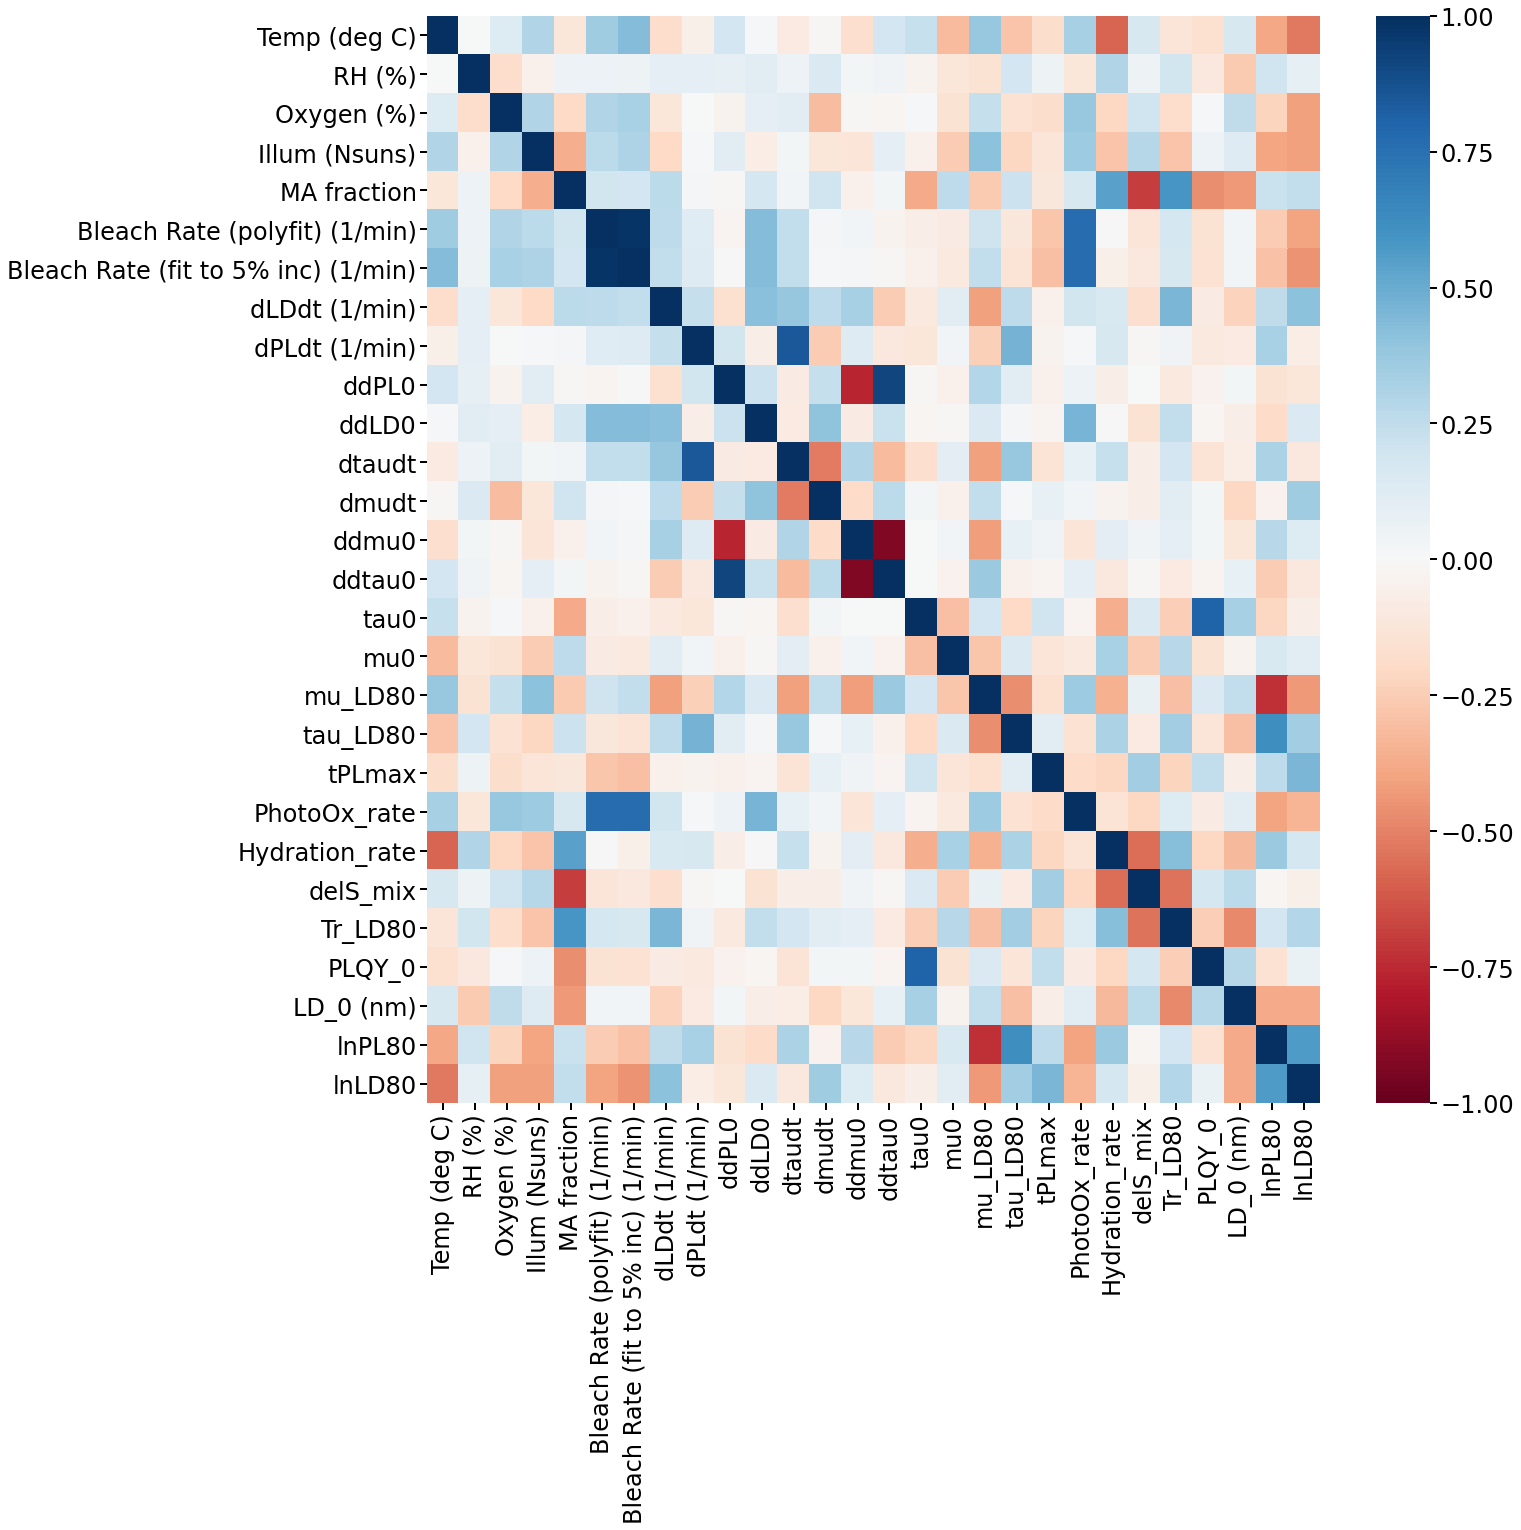

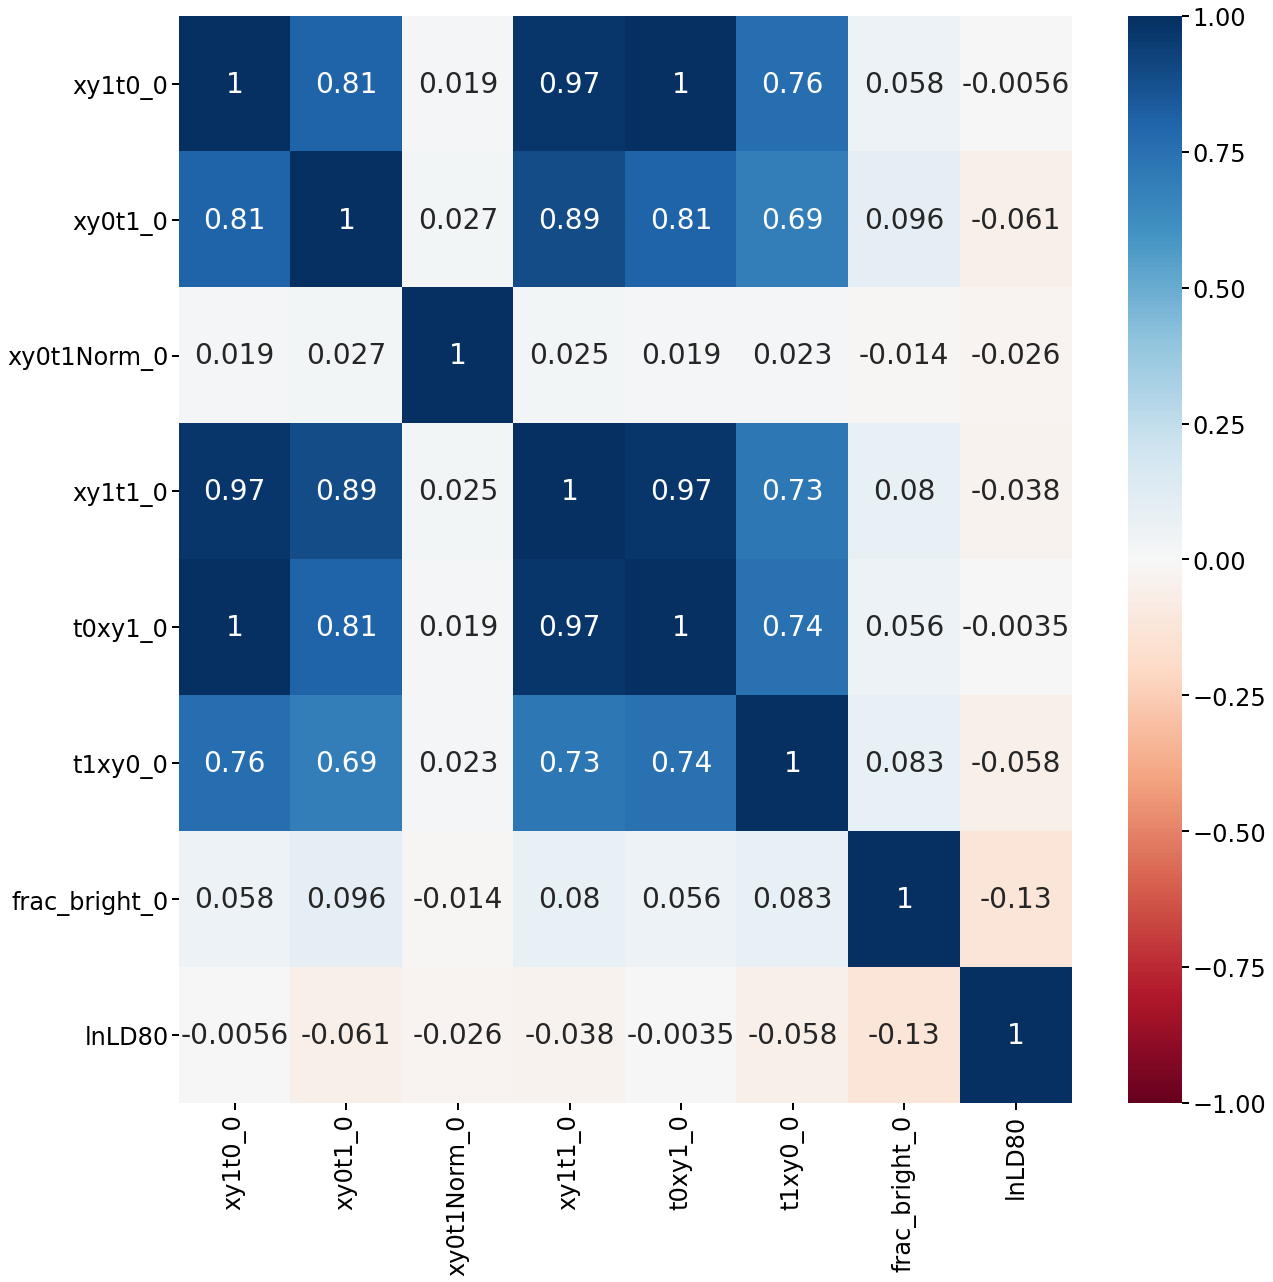

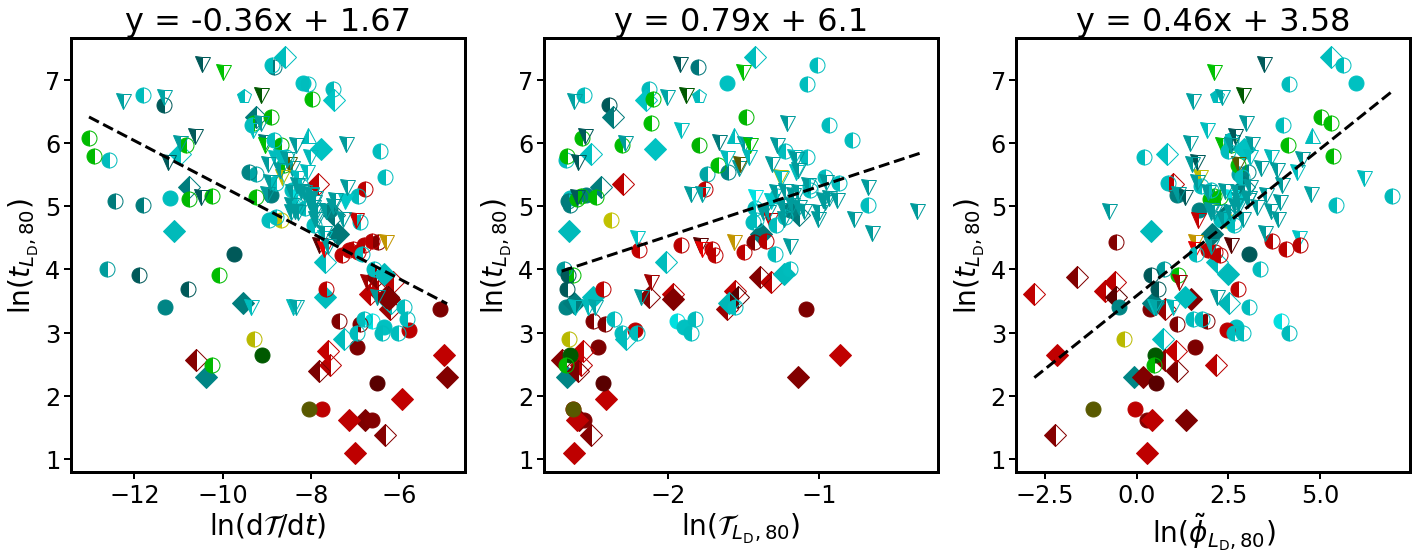

In [4]:
#rawdata_df = rawdata_df[rawdata_df['MA fraction']==1] # only MAPI
#rawdata_df = rawdata_df[rawdata_df['MA fraction']==0] # only FACs
#rawdata_df = rawdata_df[rawdata_df['MA fraction']==0.5] # only intermediate comps

#rawdata_df = rawdata_df[rawdata_df['MA fraction'] > 0.67] # only MA-rich
#rawdata_df = rawdata_df[rawdata_df['MA fraction'] < 0.67] # only balanced
#rawdata_df = rawdata_df[rawdata_df['MA fraction'] > 0.33] # only balanced
#rawdata_df = rawdata_df[rawdata_df['MA fraction'] < 0.33] # only FA/Cs-rich

columns_to_analyze = [#'Temp (deg C)',
                      #'RH (%)',
                      #'Oxygen (%)',
                      #'Illum (Nsuns)',
                      #'MA fraction',
                      #'Bleach Rate (polyfit) (1/min)',
                      'Bleach Rate (fit to 5% inc) (1/min)',
                      #'dLDdt (1/min)',
                      #'dPLdt (1/min)',
                      #'ddPL0',
                      #'ddLD0',
                      #'dtaudt',
                      #'dmudt',
                      #'ddmu0',
                      #'ddtau0',
                      #'tau0',
                      #'mu0',
                      #'mu_LD75',
                      #'tau_LD75',
                      #tau_LD80',
                      #'PL_LD80',
                      #'PhotoOx_rate',
                      #'Hydration_rate',
                      #'delS_mix',
                      'Tr_LD80'
                      #'chan_width',
                      #'chan_length'
                     ]

rawdata_df_reduced = rawdata_df.copy()[columns_to_analyze]
#rawdata_df_reduced['lndTrdt'] = np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'])
rawdata_df_reduced['lnPL80'] = np.log(rawdata_df['PL_LD80'])
rawdata_df_reduced['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])

plt.figure(figsize=(10,10))
corr_Matrix = rawdata_df_reduced.corr()
sn.heatmap(corr_Matrix,
           annot = True,
           xticklabels = ['$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                               '$\mathcal{T}_{L_\mathrm{D},80}$',
                               'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                               'ln($t_{L_\mathrm{D},80}$)'],
           yticklabels = ['$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                               '$\mathcal{T}_{L_\mathrm{D},80}$',
                               'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                               'ln($t_{L_\mathrm{D},80}$)'],
           cmap = 'RdBu', vmin=-1, vmax=1)

columns_to_analyze = ['Temp (deg C)',
                      'RH (%)',
                      'Oxygen (%)',
                      'Illum (Nsuns)',
                      'MA fraction',
                      'Bleach Rate (polyfit) (1/min)',
                      'Bleach Rate (fit to 5% inc) (1/min)',
                      'dLDdt (1/min)',
                      'dPLdt (1/min)',
                      'ddPL0',
                      'ddLD0',
                      'dtaudt',
                      'dmudt',
                      'ddmu0',
                      'ddtau0',
                      'tau0',
                      'mu0',
                      #'mu_LD75',
                      #'tau_LD75',
                      'mu_LD80',
                      'tau_LD80',
                      'tPLmax',
                      #'PL_LD80',
                      'PhotoOx_rate',
                      'Hydration_rate',
                      'delS_mix',
                      'Tr_LD80',
                      'PLQY_0',
                      'LD_0 (nm)',
                      #'chan_width',
                      #'chan_length'
                     ]

rawdata_df_reduced = rawdata_df.copy()[columns_to_analyze]
#rawdata_df_reduced['lndTrdt'] = np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'])
rawdata_df_reduced['lnPL80'] = np.log(rawdata_df['PL_LD80'])
rawdata_df_reduced['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])

plt.figure(figsize=(20,20))
corr_Matrix = rawdata_df_reduced.corr()
sn.heatmap(corr_Matrix,
           annot = False,
           cmap = 'RdBu', vmin=-1, vmax=1)
'''           xticklabels = ['$T$',
                          '$\\varphi$',
                          '$\chi_\mathrm{O_2}$',
                          '$N_\mathrm{suns}$',
                          '$x_\mathrm{MA}$',
                          '$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                          '$\mu_{L_\mathrm{D},80}$',                          
                          '$\\tau_{L_\mathrm{D},80}$',
                          '$t_\mathrm{PL,max}$',
                          '$\mathcal{T}_{L_\mathrm{D},80}$',
                          'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                          'ln($t_{L_\mathrm{D},80}$)'],
           yticklabels = ['$T$',
                          '$\\varphi$',
                          '$\chi_\mathrm{O_2}$',
                          '$N_\mathrm{suns}$',
                          '$x_\mathrm{MA}$',
                          '$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                          '$\mu_{L_\mathrm{D},80}$',
                          '$\\tau_{L_\mathrm{D},80}$',
                          '$t_\mathrm{PL,max}$',
                          '$\mathcal{T}_{L_\mathrm{D},80}$',
                          'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                          'ln($t_{L_\mathrm{D},80}$)'],'''
           

spatiotemporal = ['xy1t0_0',
                  'xy0t1_0',
                  'xy0t1Norm_0',
                  'xy1t1_0',
                  't0xy1_0',
                  't1xy0_0',
                  'frac_bright_0',
                 ]

rawdata_df_reduced = rawdata_df.copy()[spatiotemporal]
rawdata_df_reduced['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])

plt.figure(figsize=(20,20))
corr_Matrix = rawdata_df_reduced.corr()
sn.heatmap(corr_Matrix, annot=True, cmap = 'RdBu', vmin=-1, vmax=1)


# plot ln(tLD80) against various other features
fig, ax = plt.subplots(1,3,figsize=(24,8))

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    ax[0].plot(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]),
               np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]),
               color=color, marker=marker, fillstyle=fill, markersize = 15)#21 - 14*xMA)
    ax[1].plot(np.log(rawdata_df['Tr_LD80'].iloc[ii]),
               np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]),
               color=color, marker=marker, fillstyle=fill, markersize = 15)#21 - 14*xMA)
    ax[2].plot(np.log(rawdata_df['PL_LD80'].iloc[ii]),
               np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]),
               color=color, marker=marker, fillstyle=fill, markersize = 15)#21 - 14*xMA)    

nas = np.logical_or(np.isnan(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].values)),
                    np.isnan(np.log(rawdata_df['tLD80 corrected (min)'].values)))

BR_fit = np.polyfit(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[~nas]),
                    np.log(rawdata_df['tLD80 corrected (min)'].iloc[~nas]),
                    1)    

nas = np.logical_or(np.isnan(np.log(rawdata_df['Tr_LD80'].values)),
                    np.isnan(np.log(rawdata_df['tLD80 corrected (min)'].values)))
TrFail_fit = np.polyfit(np.log(rawdata_df['Tr_LD80'].iloc[~nas]),
                    np.log(rawdata_df['tLD80 corrected (min)'].iloc[~nas]),
                    1)    

nas = np.logical_or(np.isnan(np.log(rawdata_df['PL_LD80'].values)),
                    np.isnan(np.log(rawdata_df['tLD80 corrected (min)'].values)))                        
Passiv_fit = np.polyfit(np.log(rawdata_df['PL_LD80'].iloc[~nas]),
                    np.log(rawdata_df['tLD80 corrected (min)'].iloc[~nas]),
                    1)

lnBRrange = np.linspace(np.nanmin(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'])),
                        np.nanmax(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'])),
                        num=2)
ax[0].plot(lnBRrange,BR_fit[0]*lnBRrange + BR_fit[1],'k--')
                        
lnTFrange = np.linspace(np.nanmin(np.log(rawdata_df['Tr_LD80'])),
                        np.nanmax(np.log(rawdata_df['Tr_LD80'])),
                        num=2)
ax[1].plot(lnTFrange,TrFail_fit[0]*lnTFrange + TrFail_fit[1],'k--')
                        
lnPLrange = np.linspace(np.nanmin(np.log(rawdata_df['PL_LD80'])),
                        np.nanmax(np.log(rawdata_df['PL_LD80'])),
                        num=2)
ax[2].plot(lnPLrange,Passiv_fit[0]*lnPLrange + Passiv_fit[1],'k--')
                        
ax[0].set_xlabel('ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)')    
ax[0].set_ylabel('ln($t_{L_\mathrm{D},80}$)')
ax[0].set_title('y = ' + str(np.round(BR_fit[0],2)) + 'x + ' + str(np.round(BR_fit[1],2)))

ax[1].set_xlabel('ln($\mathcal{T}_{L_\mathrm{D},80}$)')    
ax[1].set_ylabel('ln($t_{L_\mathrm{D},80}$)')
ax[1].set_title('y = ' + str(np.round(TrFail_fit[0],2)) + 'x + ' + str(np.round(TrFail_fit[1],2)))

ax[2].set_xlabel('ln($\\tilde{\phi}_{L_\mathrm{D},80}$)')    
ax[2].set_ylabel('ln($t_{L_\mathrm{D},80}$)')
ax[2].set_title('y = ' + str(np.round(Passiv_fit[0],2)) + 'x + ' + str(np.round(Passiv_fit[1],2)))



<AxesSubplot:>

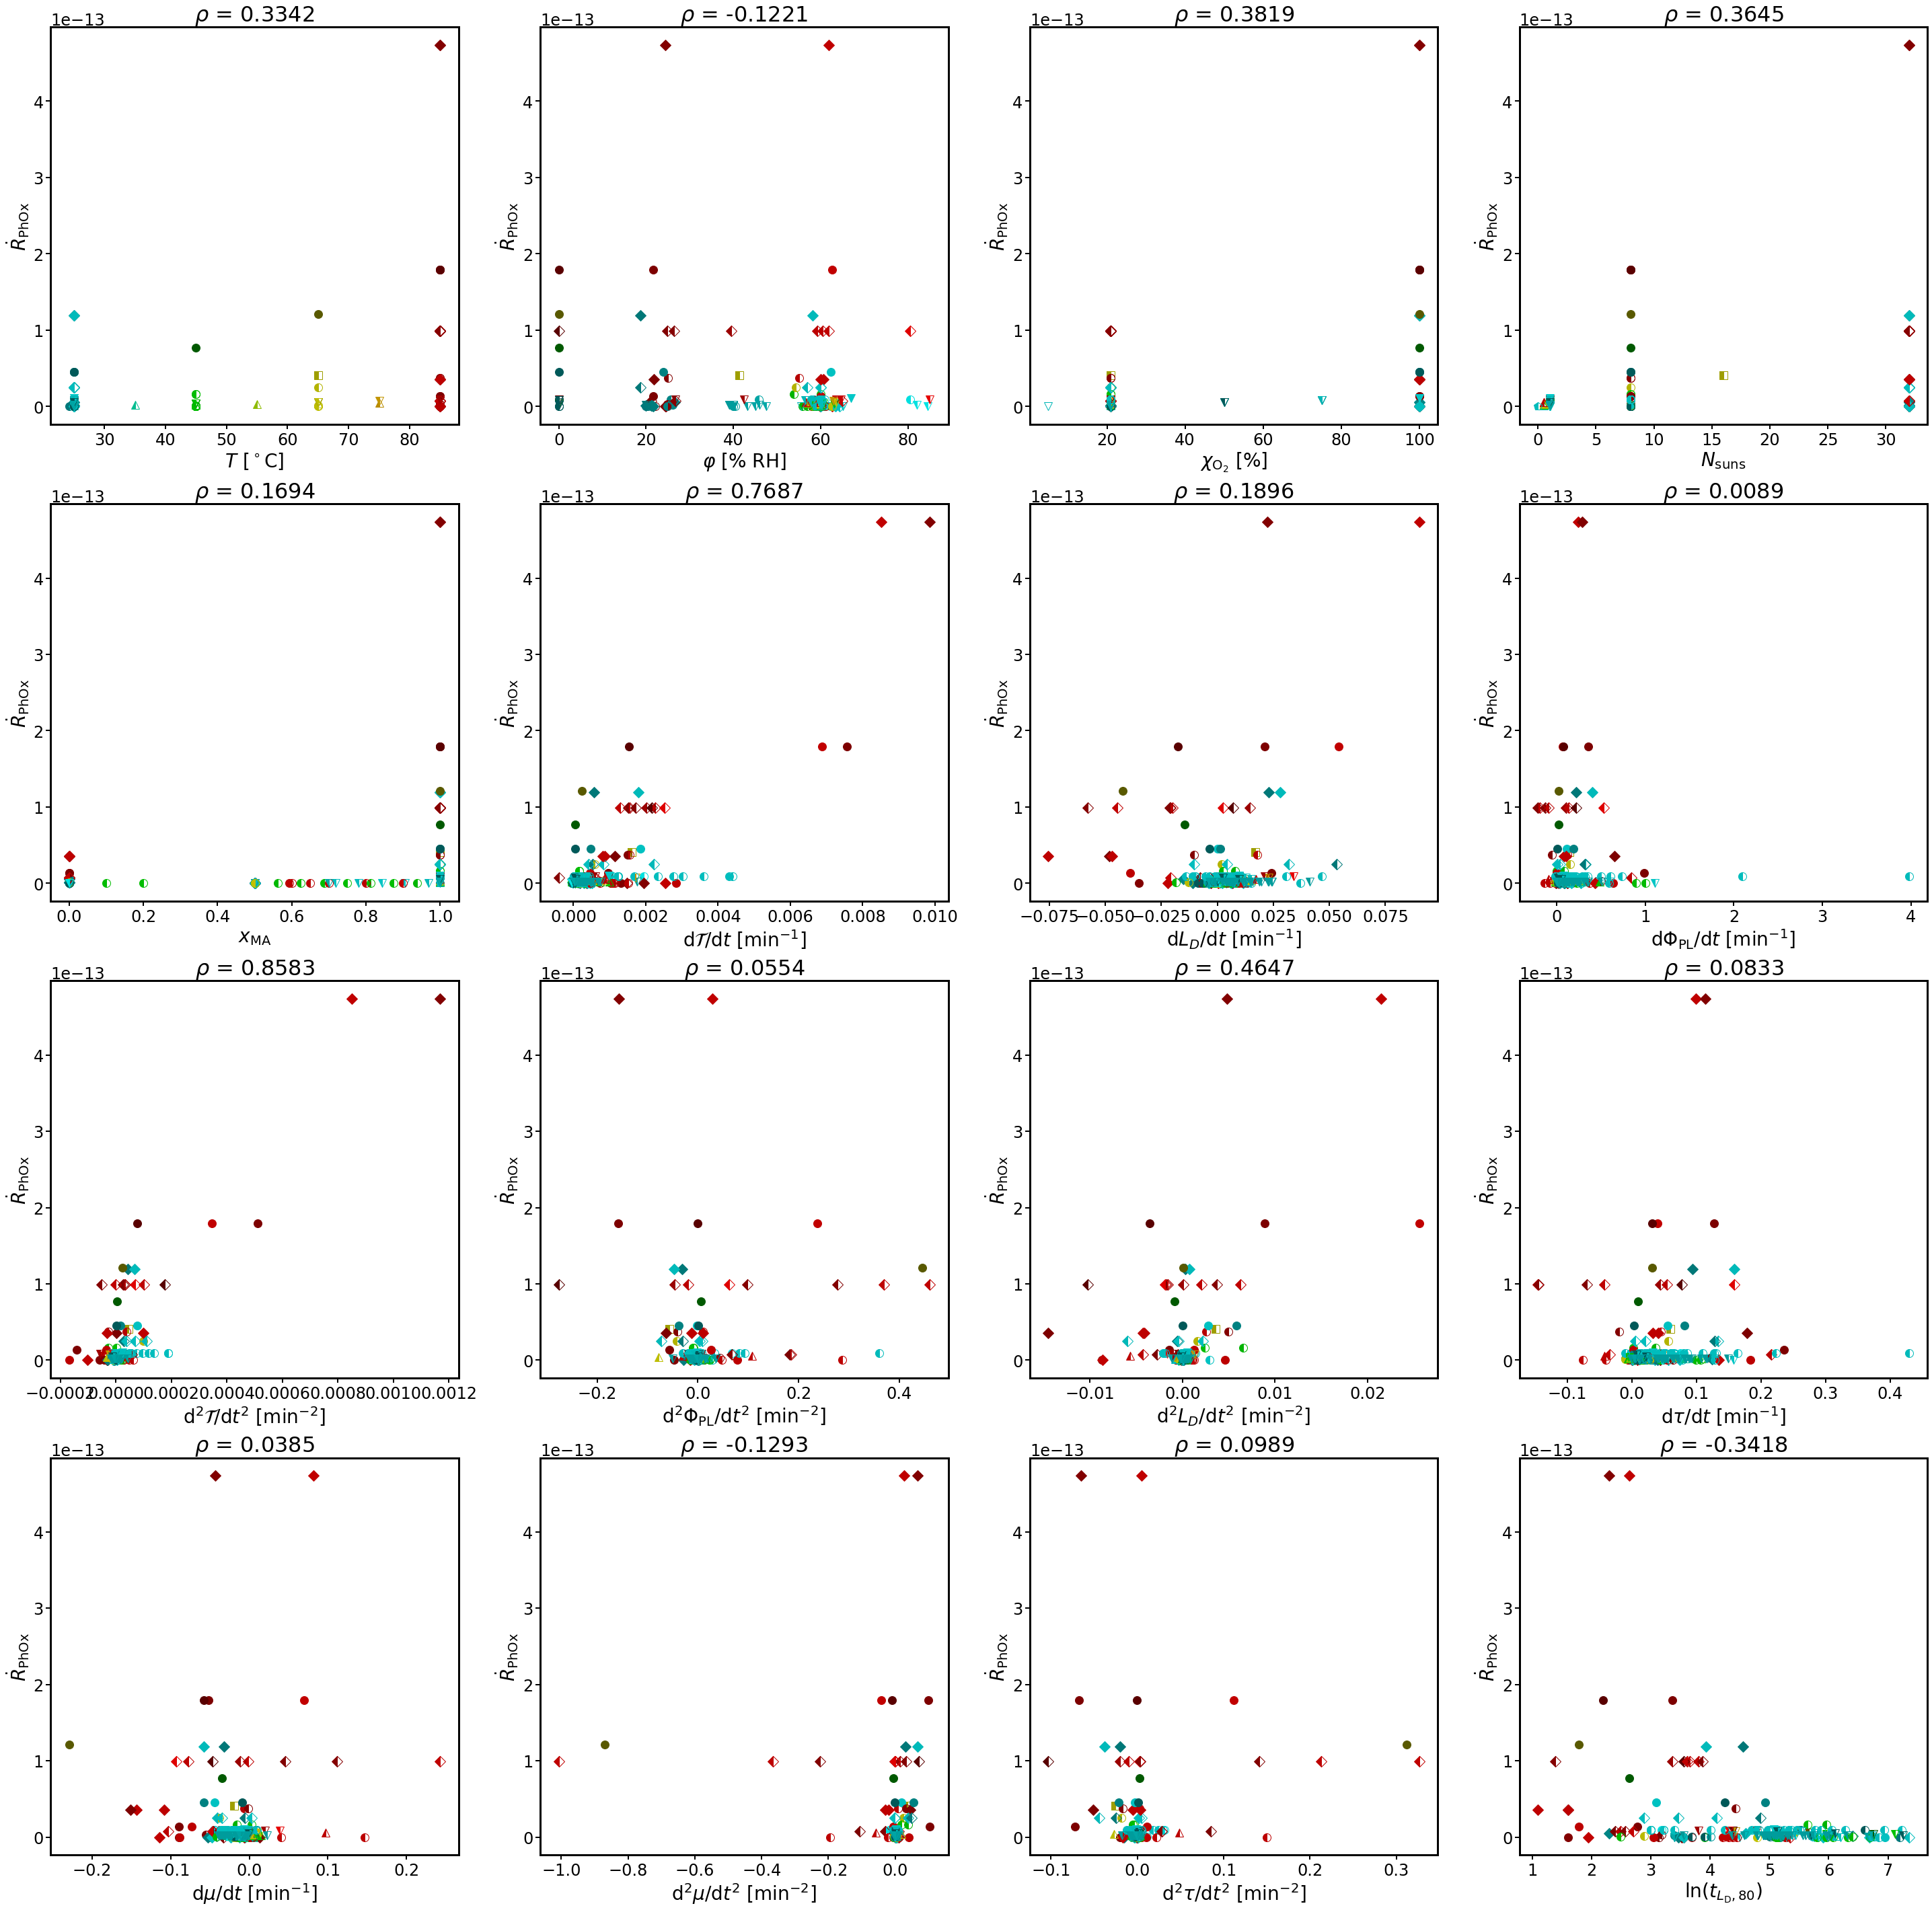

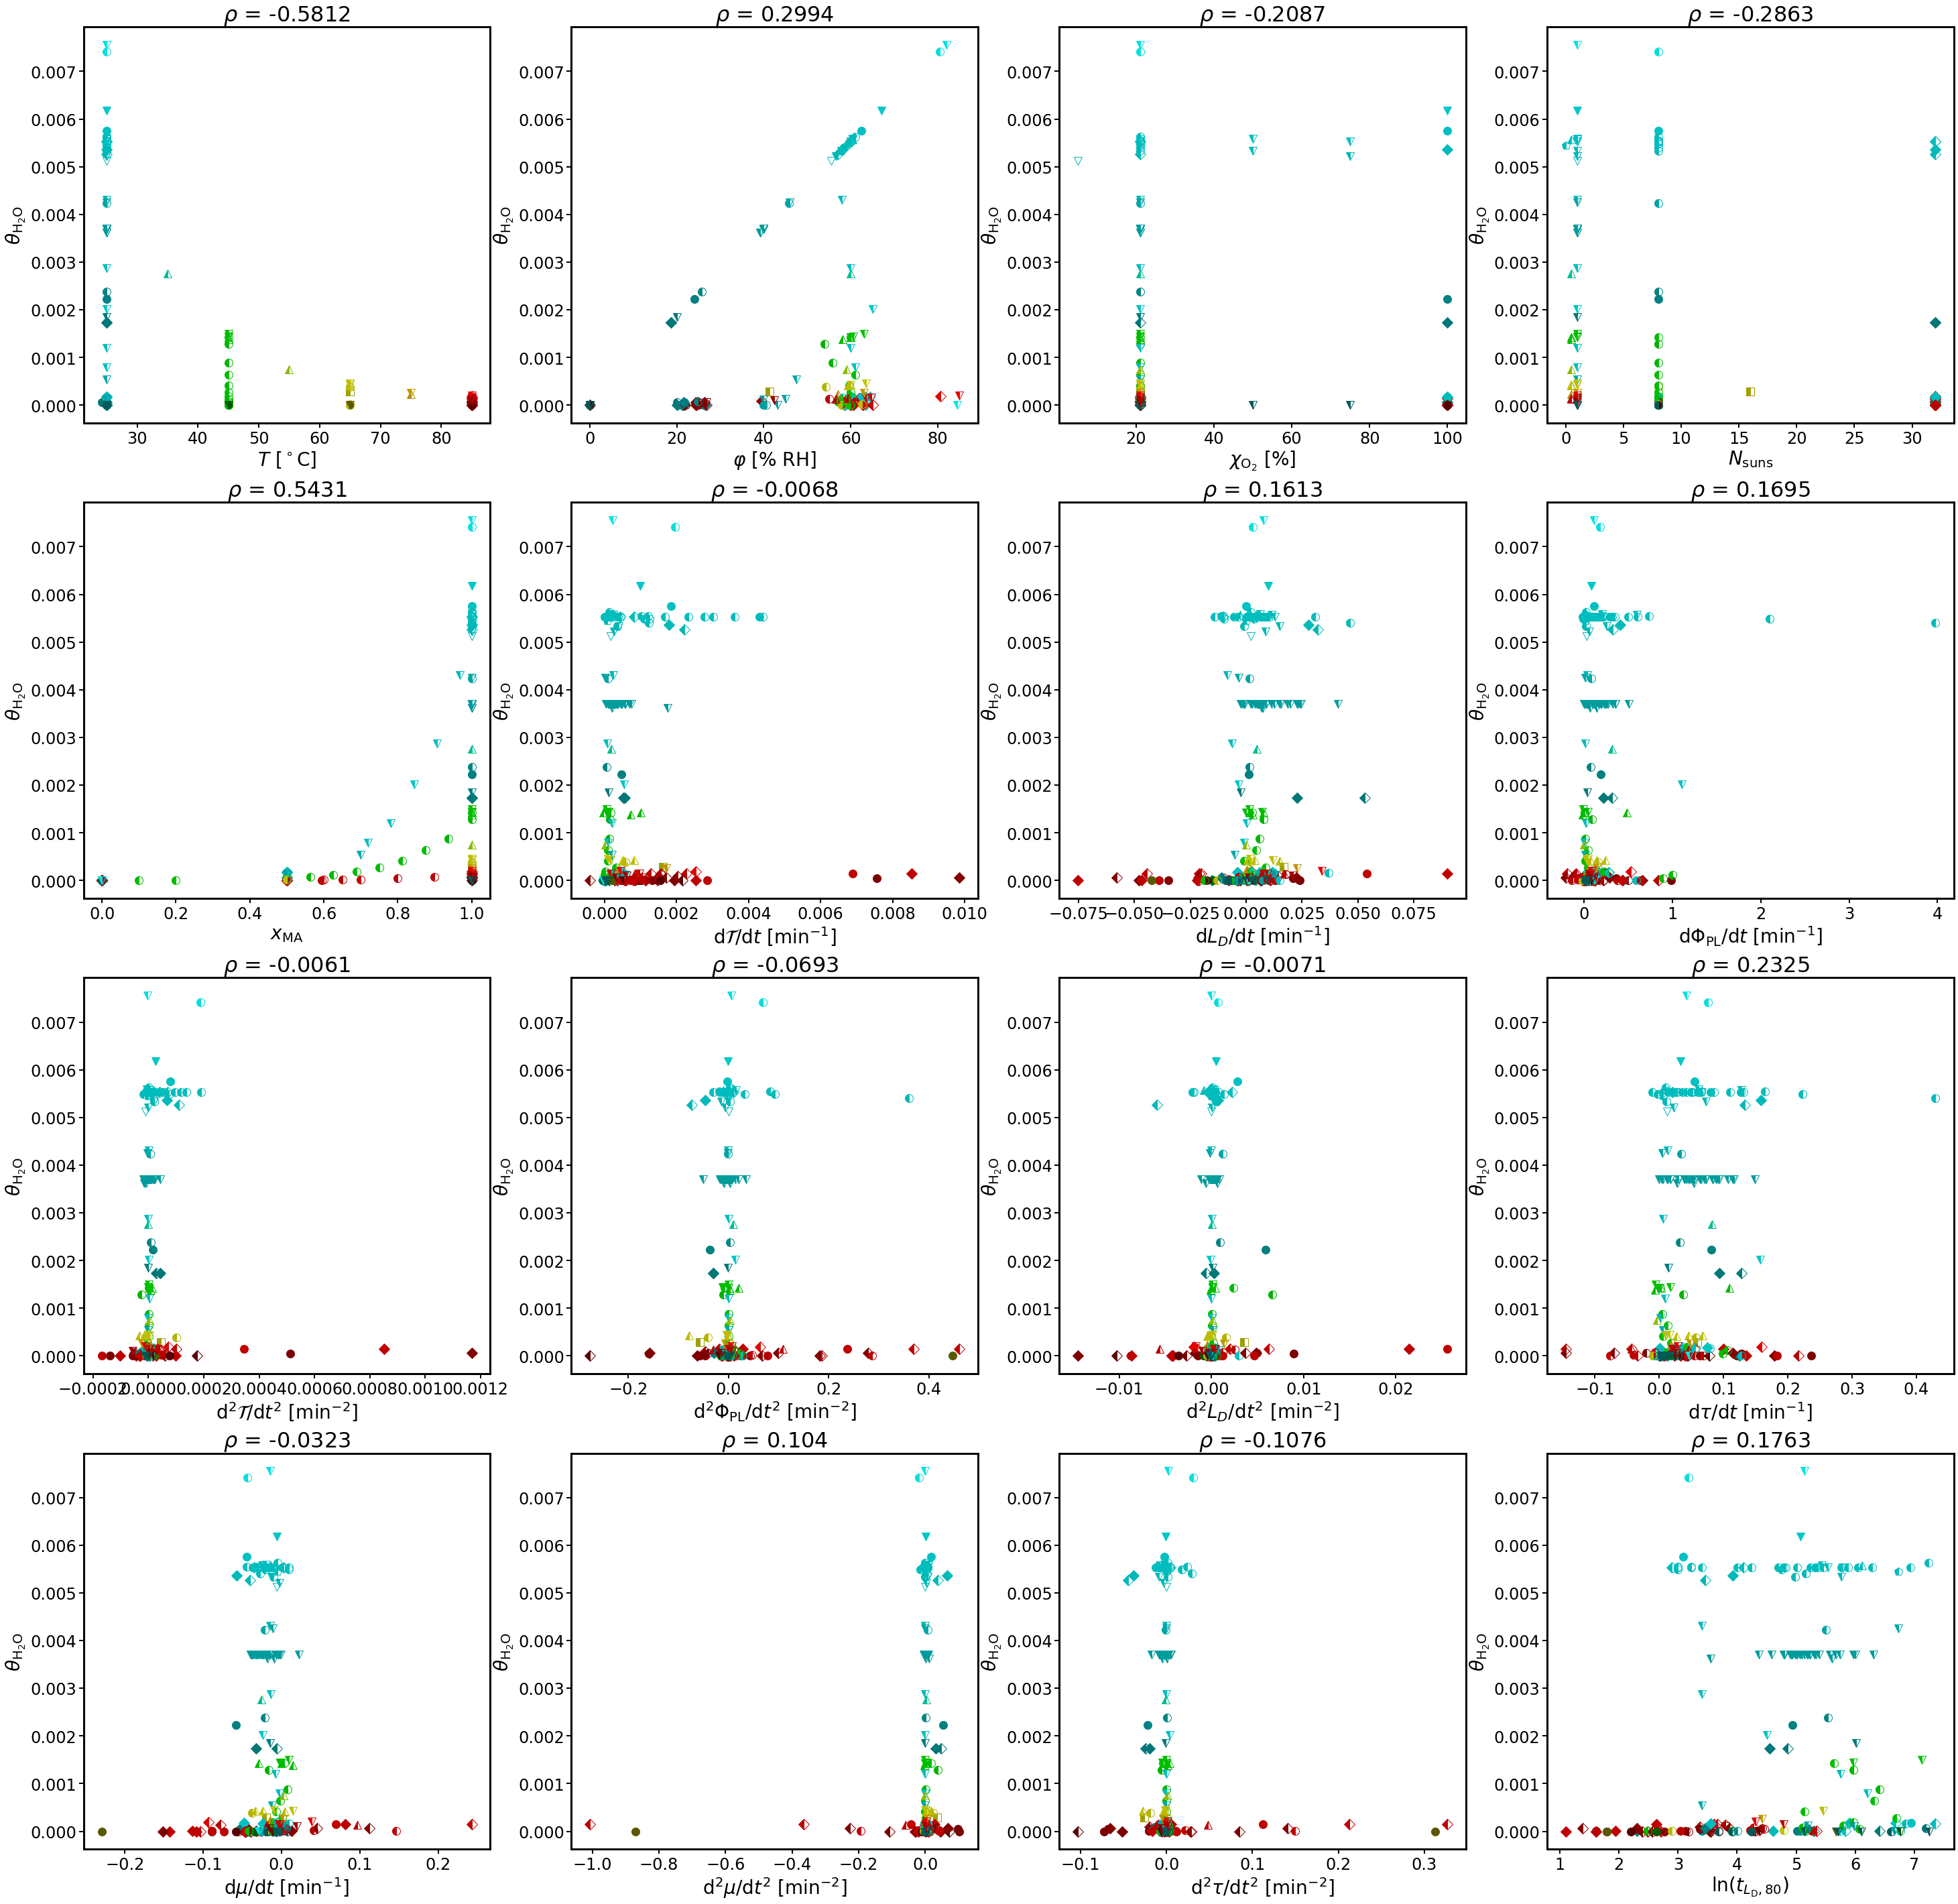

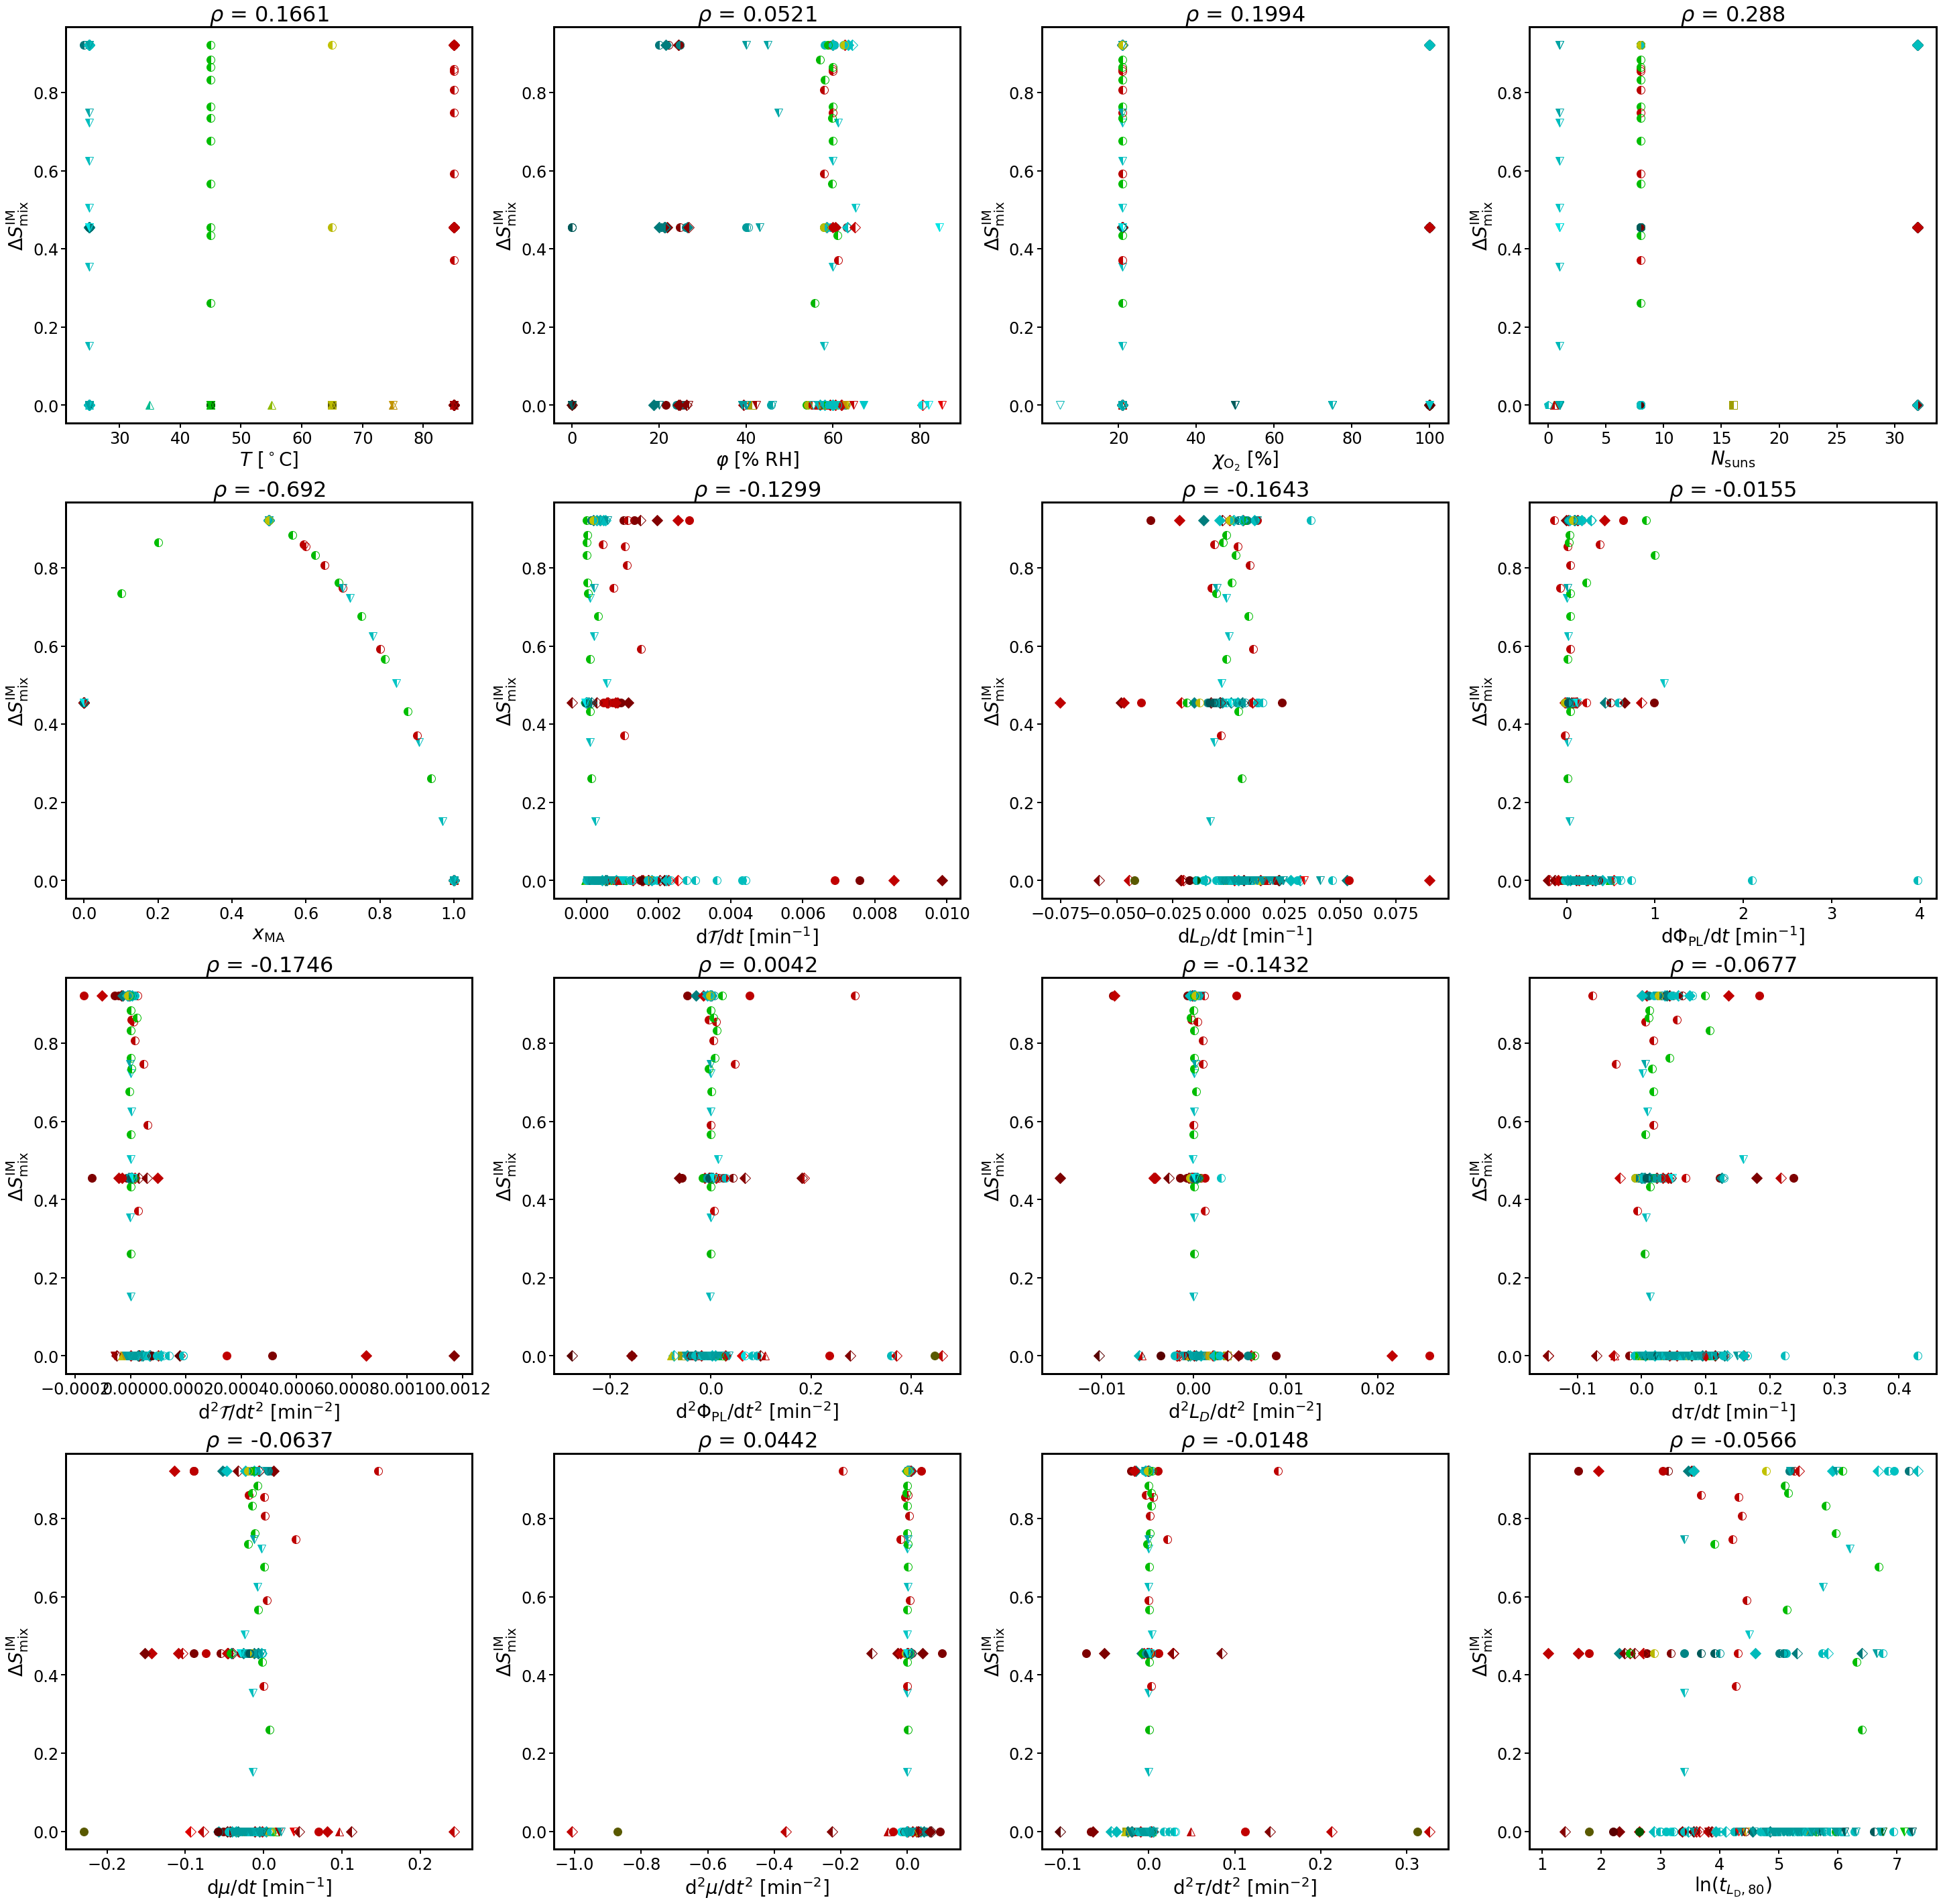

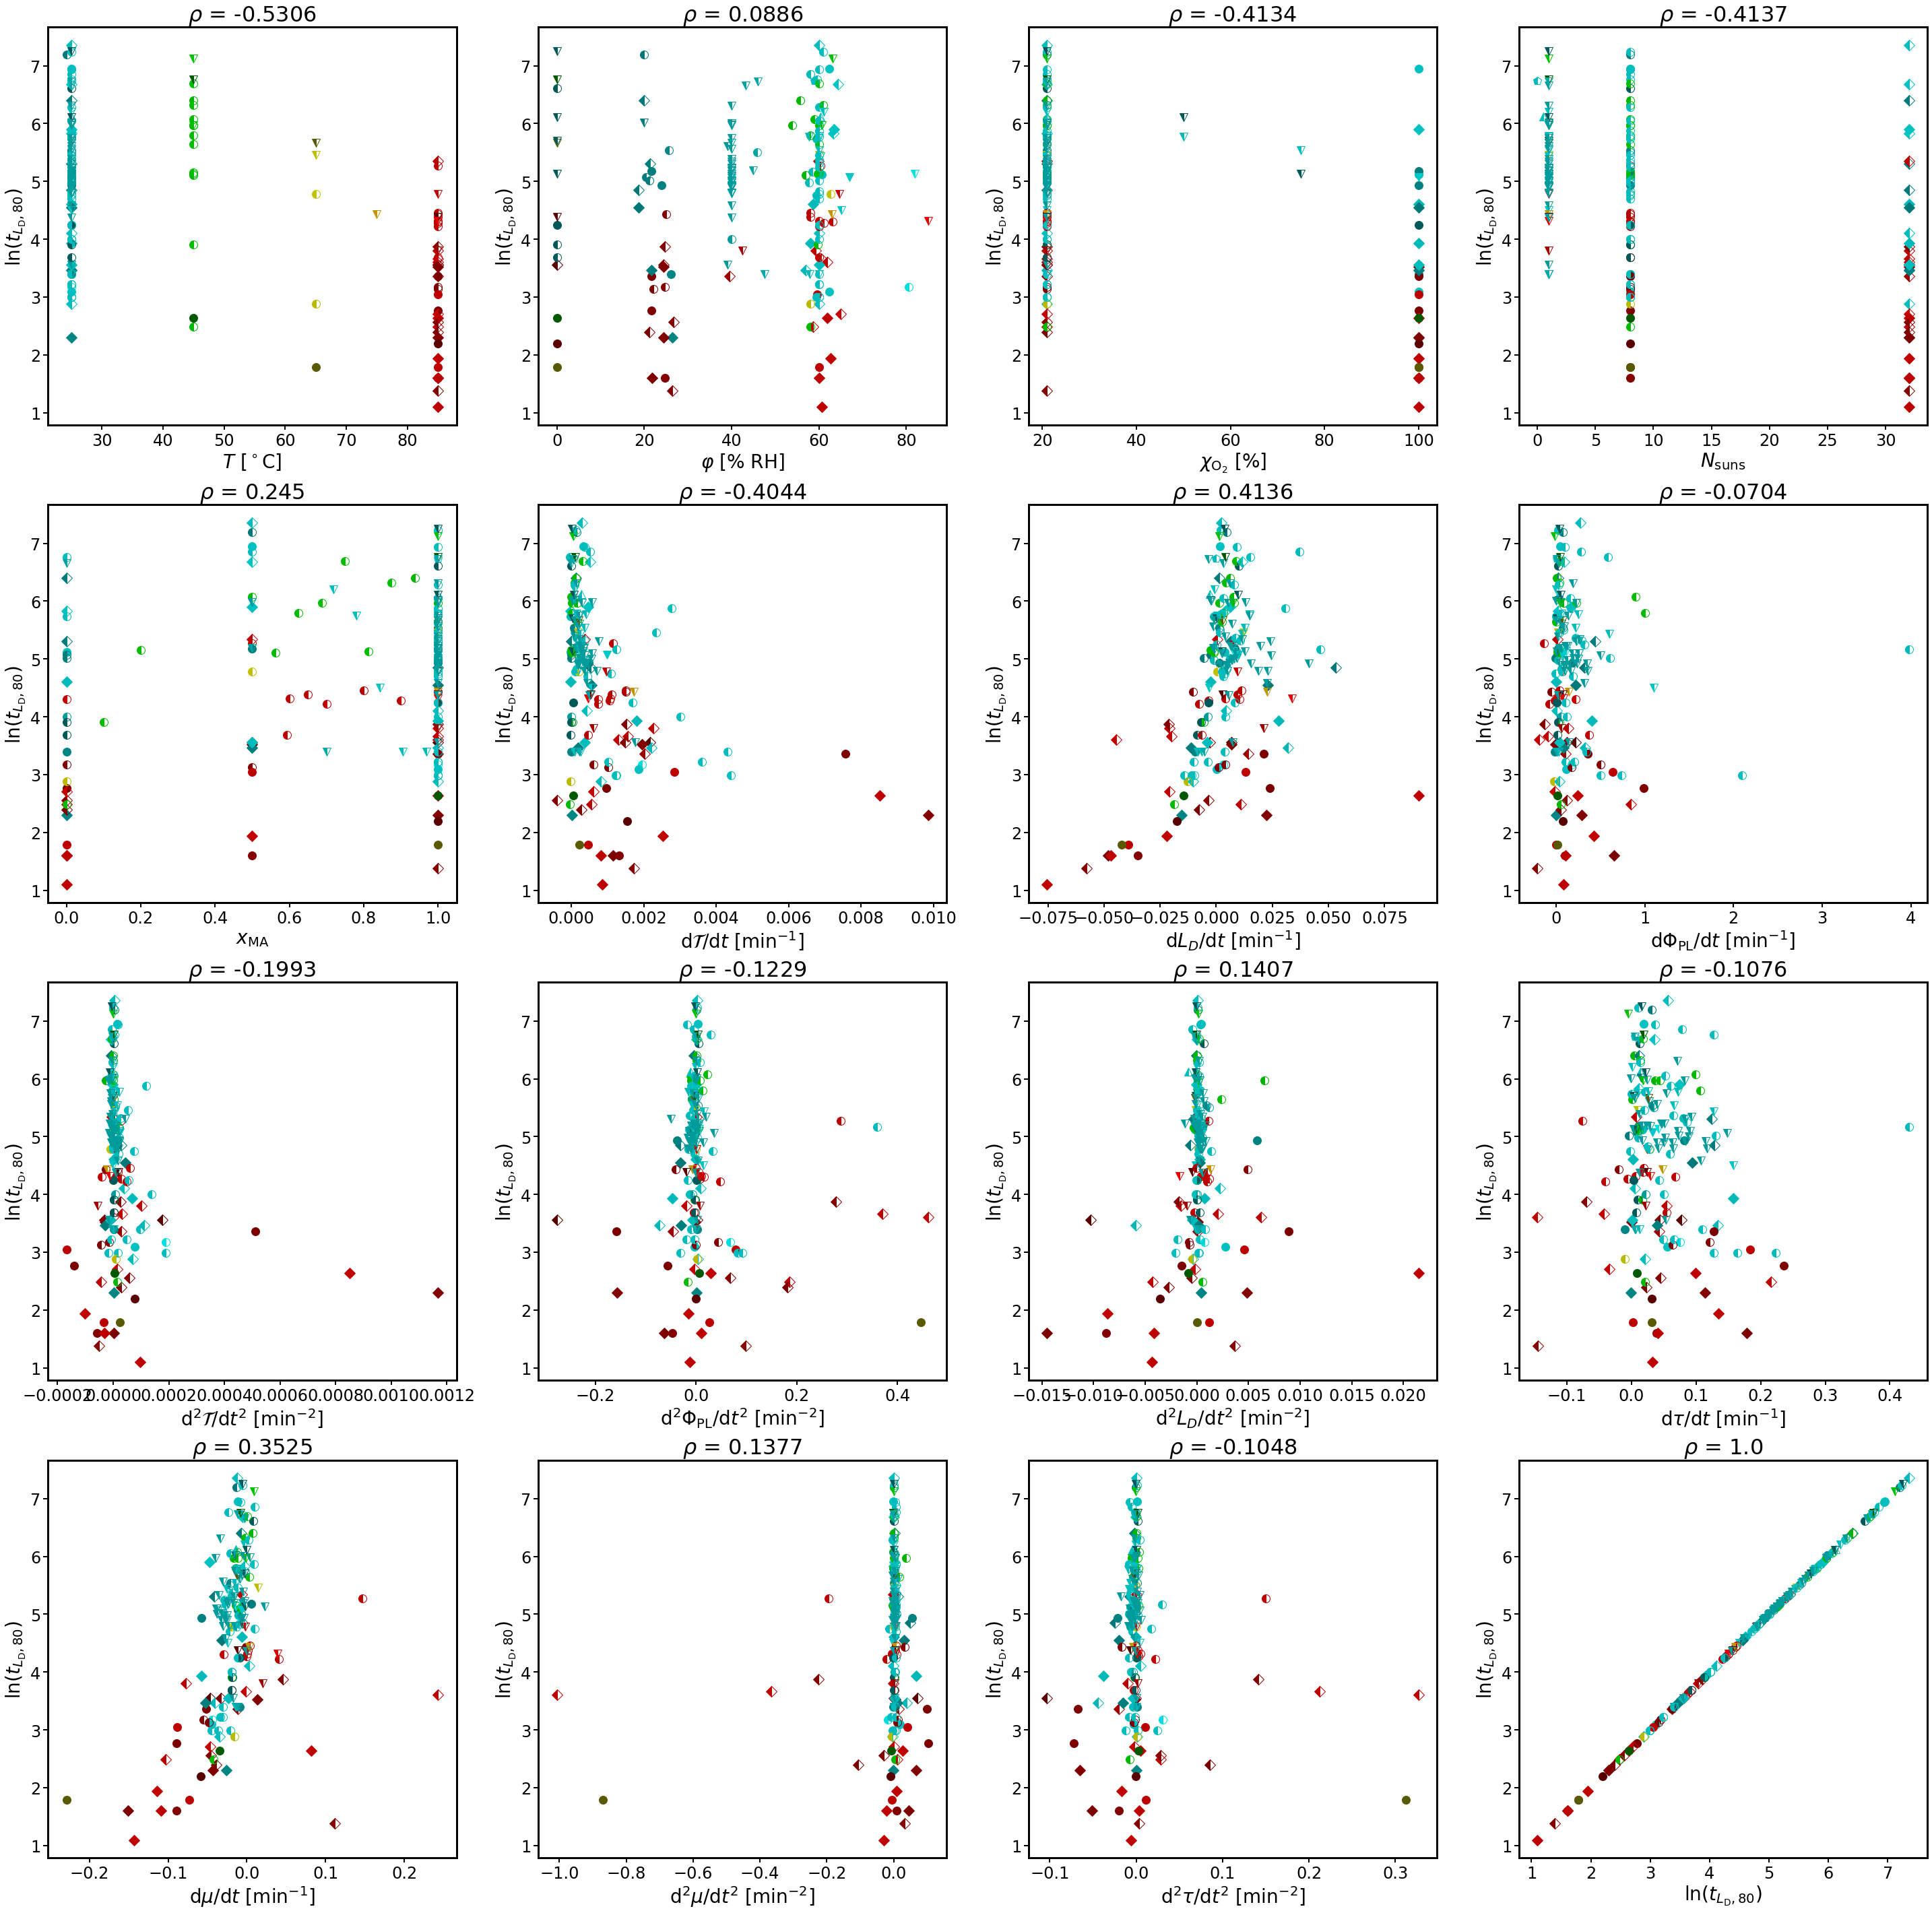

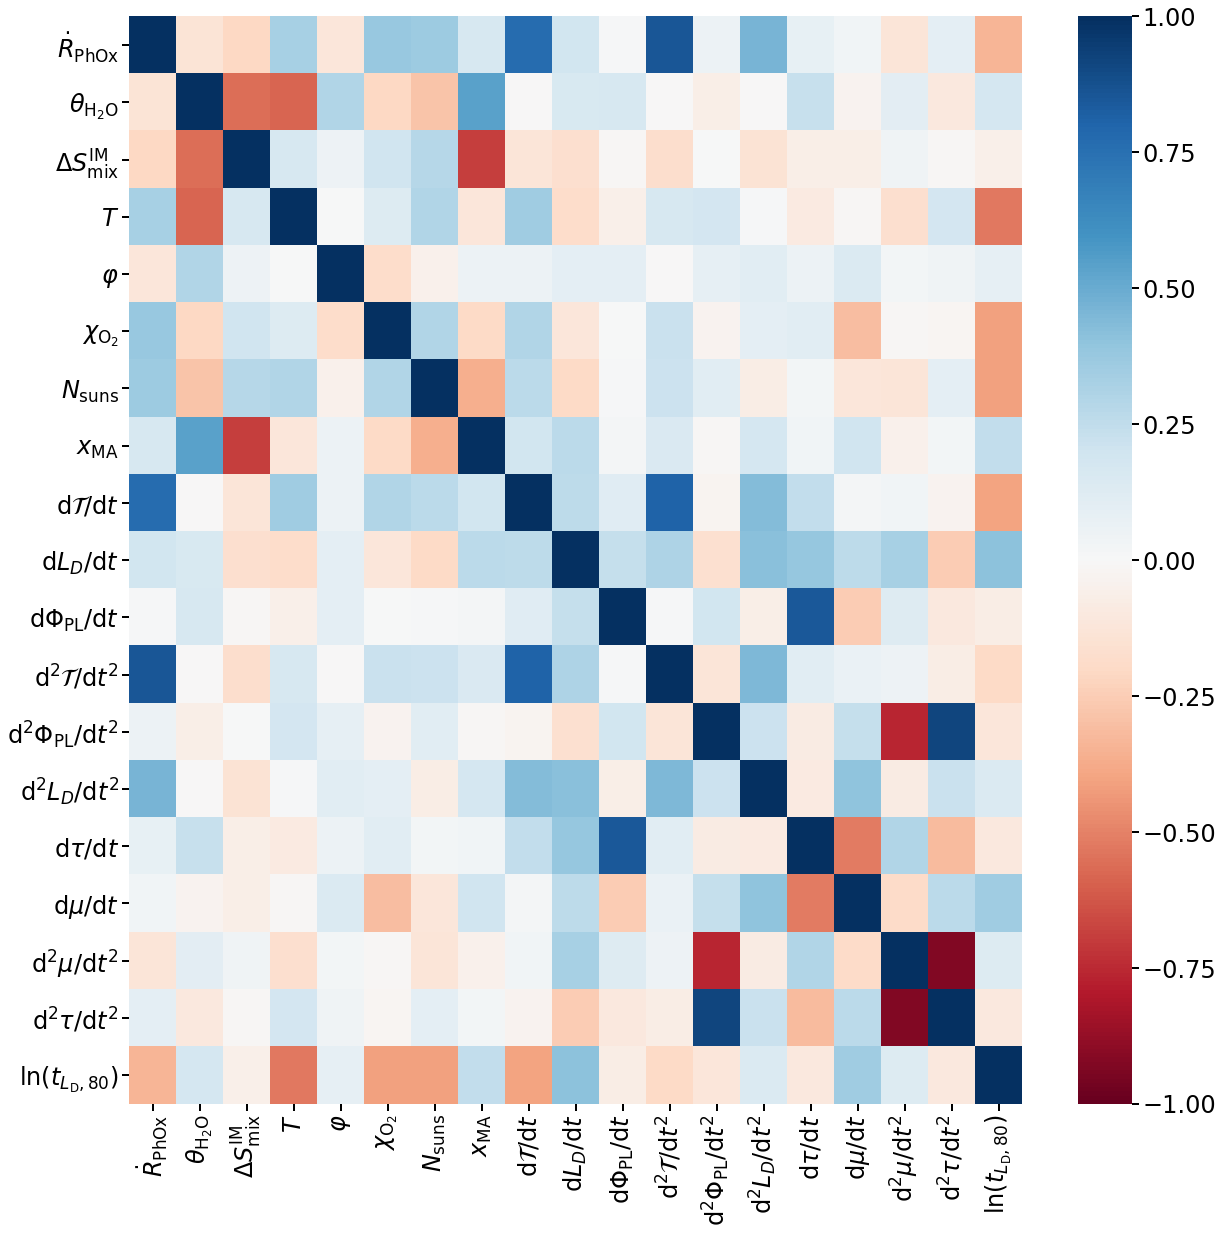

In [5]:
# In this cell, make pairwise plots of correlation between physics-inspired features versus the environmental and early-time features
rawdata_df['lnLD80'] = np.log(rawdata_df['tLD80 corrected (min)'])


# physics-inspired features
phys_feats = ['PhotoOx_rate',
              'Hydration_rate',
              'delS_mix',
             ]

phys_feats_plus = phys_feats.copy()
phys_feats_plus.append('lnLD80')

# direct measurements of environmental conditions/composition
envt_feats = ['Temp (deg C)',
              'RH (%)',
              'Oxygen (%)',
              'Illum (Nsuns)',
              'MA fraction',
             ]
# early-time measurements (PL, LD, transmittance, dark field...)
early_feats = ['Bleach Rate (polyfit) (1/min)',
               #'Bleach Rate (fit to 5% inc) (1/min)',
               'dLDdt (1/min)',
               'dPLdt (1/min)',
               'ddTr0',
               'ddPL0',
               'ddLD0',
               'dtaudt',
               'dmudt',
               'ddmu0',
               'ddtau0',
              ]
# target features we want to predict (tLD80, etc.)
target_feats = ['lnLD80']

fancy_labels_units = {'Temp (deg C)':'$T\ [^\circ \mathrm{C}]$',
                      'RH (%)':'$\\varphi$ [% RH]',
                      'Oxygen (%)':'$\chi_\mathrm{O_2}$ [%]',
                      'Illum (Nsuns)':'$N_\mathrm{suns}$',
                      'MA fraction':'$x_\mathrm{MA}$',
                      'Bleach Rate (polyfit) (1/min)':'$\mathrm{d}\mathcal{T}/\mathrm{d}t\ [\mathrm{min}^{-1}]$',#' (1st 5 points) ',
                      'Bleach Rate (fit to 5% inc) (1/min)':'$\mathrm{d}\mathcal{T}/\mathrm{d}t\ [\mathrm{min}^{-1}]$ (1st 5%)',
                      'dLDdt (1/min)':'$\mathrm{d}L_D/\mathrm{d}t\ [\mathrm{min}^{-1}]$',
                      'dPLdt (1/min)':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t\ [\mathrm{min}^{-1}]$',
                      'tLD80 corrected (min)':'$t_{L_\mathrm{D},80}$',
                      'lnLD80':'ln($t_{L_\mathrm{D},80}$)',
                      'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2\ [\mathrm{min}^{-2}]$',
                      'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2\ [\mathrm{min}^{-2}]$',
                      'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2\ [\mathrm{min}^{-2}]$',
                      'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                      'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                      'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                      'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t\ [\mathrm{min}^{-1}]$',
                      'dmudt':'$\mathrm{d}\mu/\mathrm{d}t\ [\mathrm{min}^{-1}]$',
                      'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2\ [\mathrm{min}^{-2}]$',
                      'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2\ [\mathrm{min}^{-2}]$',
                     }

# put all the non-physics-inspired features together
other_feats = envt_feats + early_feats + target_feats

# loop over physics-inspired features
for p_feat in phys_feats_plus:
    
    # initialize the plot
    fig, ax = plt.subplots(4,4,figsize=(50,50))
    
    # loop over other features
    for jj,feat in enumerate(other_feats):
        
        # indicate which pane of the subplot to plot in            
        row = math.floor(jj/4)
        col = jj % 4
        
        # plot each point according to conditions
        for ii in range(len(rawdata_df)):

            # get environmental conditions
            T = rawdata_df['Temp (deg C)'].iloc[ii]
            RH = rawdata_df['RH (%)'].iloc[ii]
            pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
            N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
            xMA = rawdata_df['MA fraction'].iloc[ii]
            encap = 'none'
            # use environmental variables to define the plot style
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            # plot points
            ax[row,col].plot(rawdata_df[feat].iloc[ii],rawdata_df[p_feat].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
        # label axes
        ax[row,col].set_xlabel(fancy_labels_units[feat])
        ax[row,col].set_ylabel(fancy_labels_dict[p_feat])
            
        # identify where NaNs occur in the dataset...
        nas = np.logical_or(np.isnan(rawdata_df[feat].values),np.isnan(rawdata_df[p_feat].values))
        # ... and do not use them for calculating the correlation coefficient
        r,_ = sp.stats.pearsonr(rawdata_df[feat].values[~nas],rawdata_df[p_feat].values[~nas])
        ax[row,col].set_title('$\\rho$ = ' + str(np.round(r,4)))

fig, ax = plt.subplots(1,3,figsize=(30,10))       
for jj,p_feat in enumerate(phys_feats):
            # plot each point according to conditions
    for ii in range(len(rawdata_df)):

        # get environmental conditions
        T = rawdata_df['Temp (deg C)'].iloc[ii]
        RH = rawdata_df['RH (%)'].iloc[ii]
        pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
        N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
        xMA = rawdata_df['MA fraction'].iloc[ii]
        encap = 'none'
        # use environmental variables to define the plot style
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        # plot points
        ax[jj].plot(rawdata_df[p_feat].iloc[ii],rawdata_df['lnLD80'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    # label axes
    ax[jj].set_xlabel(fancy_labels_units[p_feat])
    ax[jj].set_ylabel(fancy_labels_dict['lnLD80'])

    # identify where NaNs occur in the dataset...
    nas = np.logical_or(np.isnan(rawdata_df[feat].values),np.isnan(rawdata_df[p_feat].values))
    # ... and do not use them for calculating the correlation coefficient
    r,_ = sp.stats.pearsonr(rawdata_df[feat].values[~nas],rawdata_df[p_feat].values[~nas])
    ax[jj].set_title('$\\rho$ = ' + str(np.round(r,4)))
    
# now put all the features together
all_feats = phys_feats + other_feats 

# create list of fancy labels 
all_feats_fancy = []
for feat in all_feats:
    all_feats_fancy.append(fancy_labels_dict[feat])

# take only the features of interest that are typically used for LD80 modeling
rawdata_df_reduced = rawdata_df.copy()[all_feats]

# initialize a figure for the correlation matrix
corr_fig = plt.figure(figsize=(20,20))
corr_Matrix = rawdata_df_reduced.corr() # calculate correlations...
# ...and plot them as a heatmap
sn.heatmap(corr_Matrix, 
           annot = False, 
           cmap = 'RdBu', 
           vmin = -1, 
           vmax = 1, 
           xticklabels = all_feats_fancy,
           yticklabels = all_feats_fancy,
          )

# initialize a figure for the covariance matrix
cov_fig = plt.figure(figsize=(20,20))
cov_Matrix = rawdata_df_reduced.cov() # calculate correlations...
# ...and plot them as a heatmap
sn.heatmap(cov_Matrix, 
           annot = False, 
           cmap = 'viridis', 
           #vmin = -1, 
           #vmax = 1, 
           xticklabels = all_feats_fancy,
           yticklabels = all_feats_fancy,
          )

(-0.00045, 0.0002)

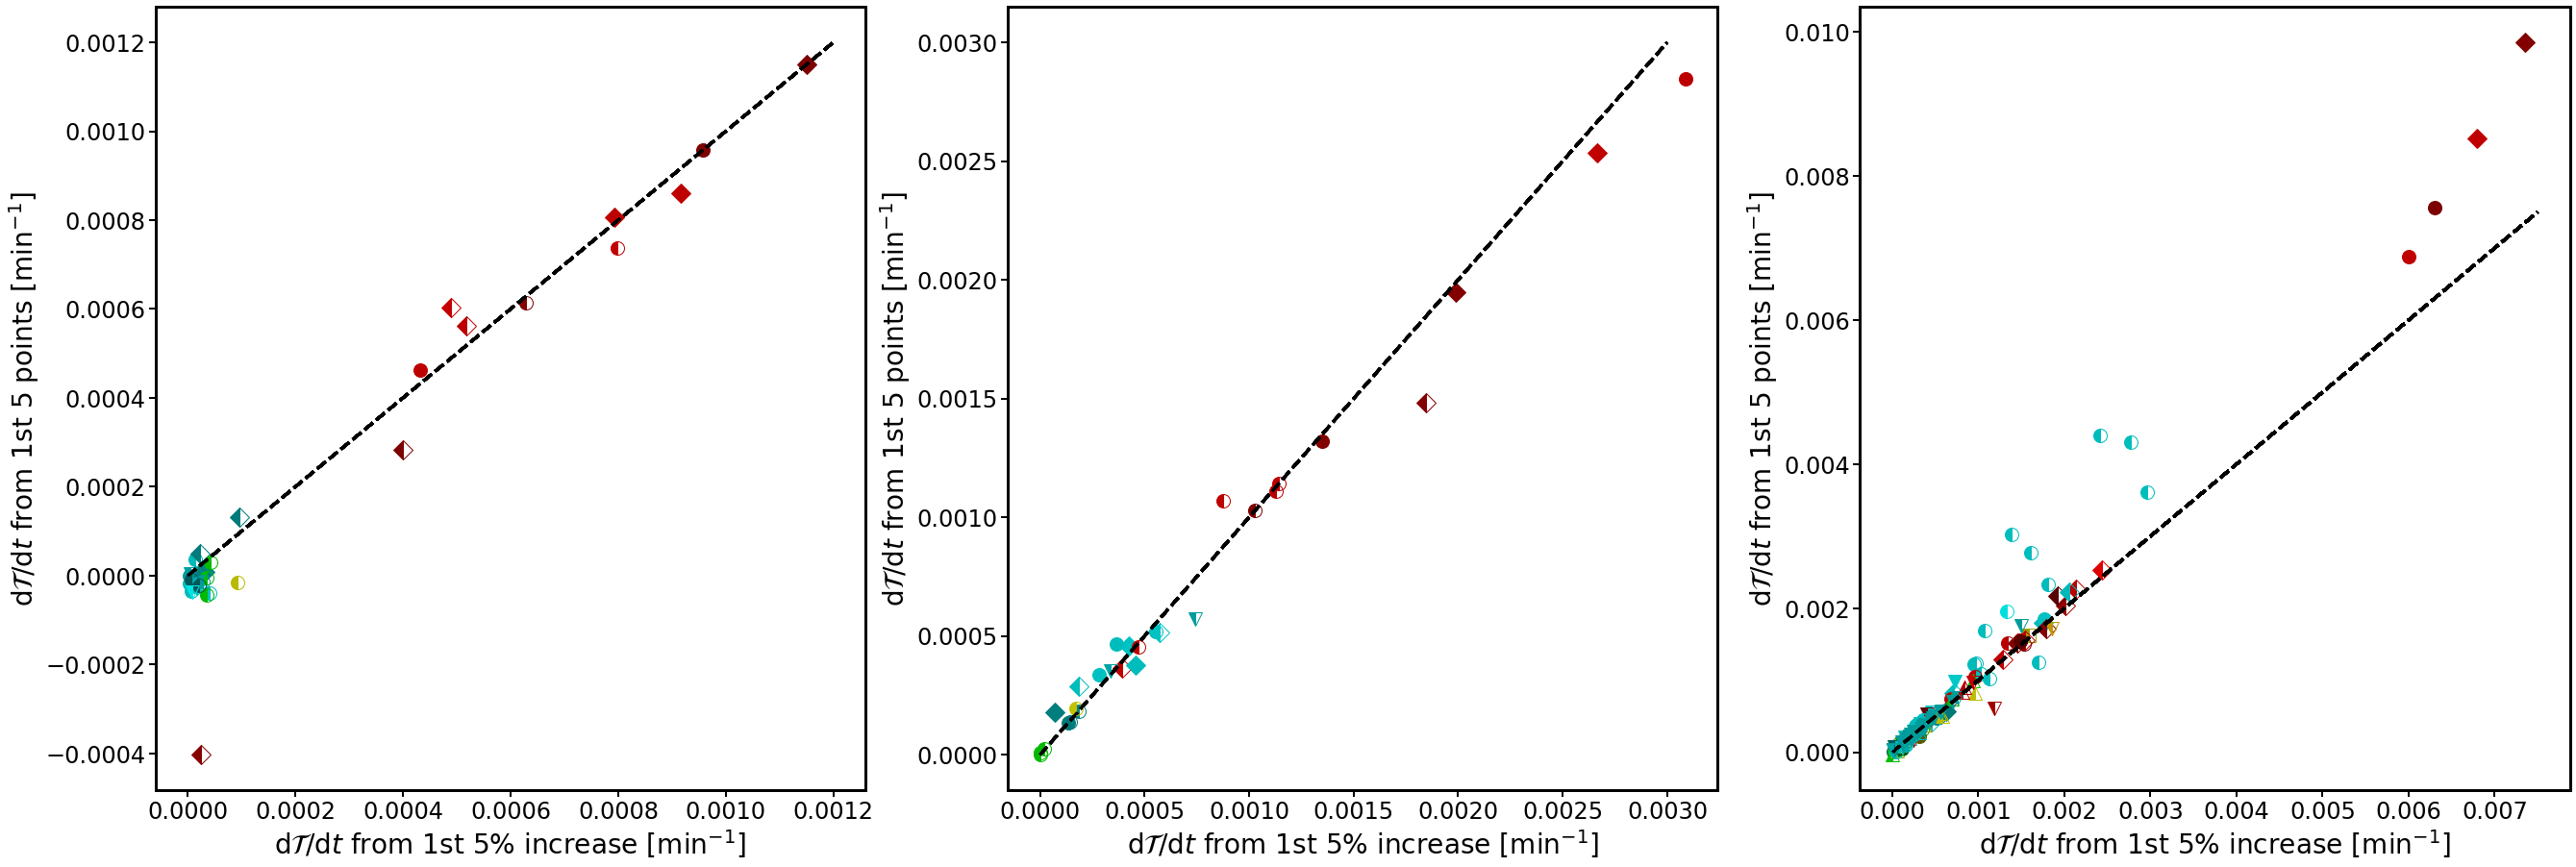

In [6]:
fig,ax = plt.subplots(1,3,figsize=(45,15))

for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    if xMA < 0.33:
        ax[0].plot(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                   rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                   color=color, marker=marker, fillstyle=fill, markersize = 14)
        x_range = np.linspace(0,0.0012,num=2)
        ax[0].plot(x_range,x_range,'k--')
    if xMA > 0.33 and xMA < 0.67:
        ax[1].plot(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                   rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                   color=color, marker=marker, fillstyle=fill, markersize = 14)
        x_range = np.linspace(0,0.0030,num=2)
        ax[1].plot(x_range,x_range,'k--')
    if xMA > 0.67:
        ax[2].plot(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                   rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                   color=color, marker=marker, fillstyle=fill, markersize = 14)
        x_range = np.linspace(0,0.0075,num=2)
        ax[2].plot(x_range,x_range,'k--')
        
ax[0].set_xlabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5% increase [min$^{-1}$]')
ax[0].set_ylabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5 points [min$^{-1}$]')
        
ax[1].set_xlabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5% increase [min$^{-1}$]')
ax[1].set_ylabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5 points [min$^{-1}$]')
        
ax[2].set_xlabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5% increase [min$^{-1}$]')
ax[2].set_ylabel('$\mathrm{d}\mathcal{T}/\mathrm{d}t$ from 1st 5 points [min$^{-1}$]')

fig,ax = plt.subplots()
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    if xMA < 0.33:
        ax.plot(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                   rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                   color=color, marker=marker, fillstyle=fill, markersize = 14)
        x_range = np.linspace(0,0.0012,num=2)
        ax.plot(x_range,x_range,'k--')
ax.set_xlim([-0.0001,0.0002])
ax.set_ylim([-0.00045,0.0002])

Text(0.5, 1.0, 'Optoelectronic Tolerance Function')

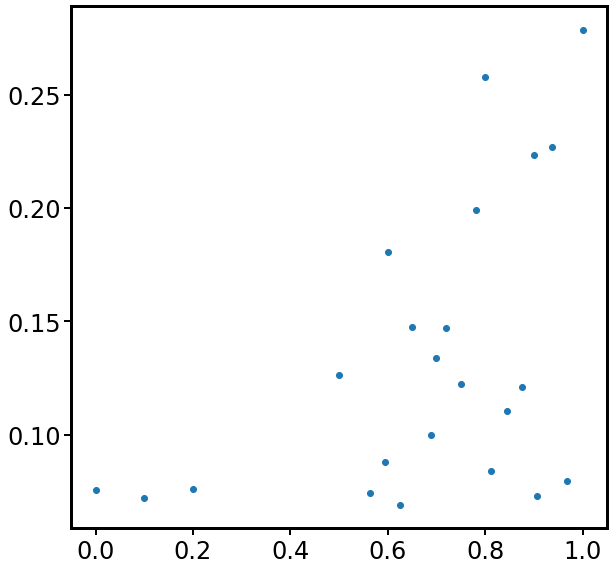

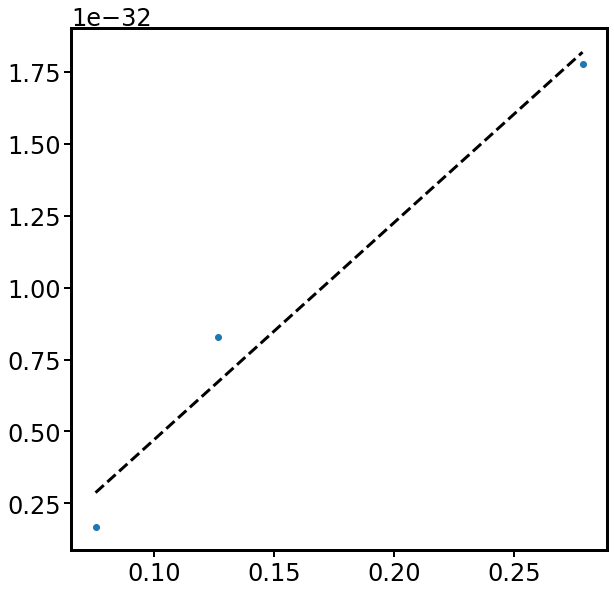

In [7]:
fig,ax = plt.subplots()
xMA_list = []

for ii in range(len(rawdata_df)):
    xMA = rawdata_df['MA fraction'].iloc[ii]
    if xMA not in xMA_list:
        xMA_list.append(xMA)

        xMA_list = sorted(xMA_list)
init_vals = list(np.zeros(len(xMA_list)))
TrFail_sum = dict(zip(xMA_list,init_vals))
TrFail_counts = dict(zip(xMA_list,init_vals))

for ii in range(len(rawdata_df)):
    xMA = rawdata_df['MA fraction'].iloc[ii]
    if ~np.isnan(rawdata_df['Tr_LD80'].iloc[ii]):
        TrFail_sum[xMA] += rawdata_df['Tr_LD80'].iloc[ii]
        TrFail_counts[xMA] += 1

TrFail_avgs = dict(zip(xMA_list,np.array(list(TrFail_sum.values()))/np.array(list(TrFail_counts.values()))))
ax.plot(TrFail_avgs.keys(),TrFail_avgs.values(),'.')

fig,ax = plt.subplots()
xMA_list = [0,0.5,1.0]
TrFail = [0,0,0]
TrFail_count = [0,0,0]
Eg_barrier = [0,0,0]

for ii in range(len(rawdata_df)):
    xMA = rawdata_df['MA fraction'].iloc[ii]
    if xMA == 0 and ~np.isnan(rawdata_df['Tr_LD80'].iloc[ii]):
        TrFail[0] += rawdata_df['Tr_LD80'].iloc[ii]
        TrFail_count[0] += 1
        Eg_barrier[0] += np.exp(-(2.3 - 0.1*xMA)/(8.617e-5*(rawdata_df['Temp (deg C)'].iloc[ii] + 273.15)))
    elif xMA == 0.5 and ~np.isnan(rawdata_df['Tr_LD80'].iloc[ii]):
        TrFail[1] += rawdata_df['Tr_LD80'].iloc[ii]
        TrFail_count[1] += 1
        Eg_barrier[1] += np.exp(-(2.3 - 0.1*xMA)/(8.617e-5*(rawdata_df['Temp (deg C)'].iloc[ii] + 273.15)))
    elif xMA == 1 and ~np.isnan(rawdata_df['Tr_LD80'].iloc[ii]):
        TrFail[2] += rawdata_df['Tr_LD80'].iloc[ii] 
        TrFail_count[2] += 1
        Eg_barrier[2] += np.exp(-(2.3 - 0.1*xMA)/(8.617e-5*(rawdata_df['Temp (deg C)'].iloc[ii] + 273.15)))

TrFail = np.array(TrFail)
Eg_barrier = np.array(Eg_barrier)
TrFail_count = np.array(TrFail_count)
TrFail = TrFail/TrFail_count
Eg_barrier = Eg_barrier/TrFail_count

ax.plot(TrFail,Eg_barrier,'.')
pfit = np.polyfit(TrFail,Eg_barrier,1)
failrange = np.array([np.nanmin(TrFail),np.nanmax(TrFail)])
ax.plot(failrange,pfit[0]*failrange + pfit[1],'k--')

fig,ax = plt.subplots(1,2,figsize=(24,12))

for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    Eg_barrier = np.exp(-(2.3 - 0.1*xMA))#/(8.617e-5*(T + 273.15)))
    TrFail = rawdata_df['Tr_LD80'].iloc[ii]
    
    ax[0].plot(xMA,TrFail,color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
    ax[1].plot(TrFail,Eg_barrier,color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)


xMA = rawdata_df['MA fraction'].values
TrFail = rawdata_df['Tr_LD80'].values
nas = np.logical_or(np.isnan(xMA),
                    np.isnan(TrFail))     
failfit = np.polyfit(xMA[~nas],TrFail[~nas],2)
xMArange = np.linspace(0,1,num=101)
ax[0].plot(xMArange,failfit[0]*xMArange**2 + failfit[1]*xMArange + failfit[2],'k--')

# Define optoelectronic tolerance parameter as function of composition
rawdata_df['Opt_Tol'] = failfit[0]*xMA**2 + failfit[1]*xMA + failfit[2]
rawdata_df['Block_rate'] = (rawdata_df['Bleach Rate (polyfit) (1/min)']/rawdata_df['Opt_Tol'])**(-1)
rawdata_df['PhotoOx_rate_block'] = rawdata_df['PhotoOx_rate']/rawdata_df['Opt_Tol']
rawdata_df['Hydration_rate_block'] = rawdata_df['Hydration_rate']/rawdata_df['Opt_Tol']

ax[0].set_xlabel('MA Fraction')
ax[0].set_ylabel('$\mathcal{T}$ at $t_{L_\mathrm{D},80}$')
ax[0].set_title('Optoelectronic Tolerance Function')

In [ ]:
plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(rawdata_df['Oxygen (%)'].iloc[ii],np.log(rawdata_df['PL_LD80'].iloc[ii]),
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('Oxygen Content [%]')
#plt.xlabel('$N_\mathrm{suns}$')
plt.ylabel('PL_fail')

In [ ]:


plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(rawdata_df['Oxygen (%)'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('Oxygen Content [%]')
plt.ylabel('Bleaching Rate')

plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['PhotoOx_rate'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('$\dot{R}_\mathrm{PhOx}$')
plt.ylabel('Bleaching Rate')

plt.figure(figsize=(6,6))
for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['Hydration_rate'].iloc[ii],rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*rawdata_df['MA fraction'].iloc[ii])
plt.xlabel('$\\theta_\mathrm{H_2O}$')
plt.ylabel('Bleaching Rate')

In [31]:
E_ads_H2O = -0.45*1.6e-19 # linear relationship based on composition
T_Kelvin = np.linspace(25,85,num=4) + 273.15
P_H2O = np.linspace(0,101325*0.0313,num=101)
colors = ['xkcd:cerulean',
          'xkcd:forest green',
          'xkcd:goldenrod',
         ]

fig,ax = plt.subplots(1,2,figsize=(20,10))
for ii, temp in enumerate(T_Kelvin):
    Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*temp)**(-5/2)/Z_int_H2O(temp)*np.exp(-E_ads_H2O/(kB*temp))
    # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
    LAI_H2O = Keq_H2O*P_H2O/(1 + Keq_H2O*P_H2O)
    ax[0].plot(P_H2O,LAI_H2O,colors[ii])


ax[0].set_xlabel('$P_\mathrm{H_2 O}$')
ax[0].set_ylabel('Fractional Coverage of H$_2$O')
ax[0].legend(['25$^\circ \mathrm{C}$',
            '45$^\circ \mathrm{C}$',
            '65$^\circ \mathrm{C}$',
            '85$^\circ \mathrm{C}$'],
           frameon=False)


markers = ['o','s','d','p']
x_H2O = np.linspace(0.2,0.8,num=4)
for jj, chi in enumerate(x_H2O):
    P_H2O = chi*101325*0.0313
    
    Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))
    LAI_H2O = Keq_H2O*P_H2O/(1 + Keq_H2O*P_H2O)
    fit = np.polyfit(1/T_Kelvin,np.log(LAI_H2O),1)
    ax[1].plot(1/T_Kelvin,np.exp(fit[1]+fit[0]/T_Kelvin),'k--')
    
    for ii, temp in enumerate(T_Kelvin):
        Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*temp)**(-5/2)/Z_int_H2O(temp)*np.exp(-E_ads_H2O/(kB*temp))
        LAI_H2O = Keq_H2O*P_H2O/(1 + Keq_H2O*P_H2O)
        ax[1].semilogy(1/temp,LAI_H2O,linestyle=' ',color=colors[ii],marker=markers[jj])

ax[1].set_xlabel('Inverse Temperature [1000/K]')
ax[1].set_ylabel('Fractional Coverage of H$_2$O')

IndexError: list index out of range

In [ ]:
rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]

fig,ax = plt.subplots(1,2,figsize=(20,10))
fig2,ax2 = plt.subplots(1,3,figsize=(30,10))
MAfig, MAax = plt.subplots(figsize=(10,10))

ln_LD80_FA_rich = []
ln_dTdt_FA_rich = []
ln_LD80_balanced = []
ln_dTdt_balanced = []
ln_LD80_MA_rich = []
ln_dTdt_MA_rich = []

ln_LD80_MA_only = []
ln_dTdt_MA_only = []

for ii in range(len(rawdata_df)):
    xMA = rawdata_df['MA fraction'].iloc[ii]
    if xMA < 0.33:
        ln_LD80_FA_rich.append(np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]))
        ln_dTdt_FA_rich.append(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]))          
    elif xMA > 0.33 and xMA < 0.67:
        ln_LD80_balanced.append(np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]))
        ln_dTdt_balanced.append(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]))
    if xMA > 0.67:
        ln_LD80_MA_rich.append(np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]))
        ln_dTdt_MA_rich.append(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]))
        if xMA == 1:
            ln_LD80_MA_only.append(np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]))
            ln_dTdt_MA_only.append(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii]))  

ln_LD80_FA_rich = np.array(ln_LD80_FA_rich)
ln_dTdt_FA_rich = np.array(ln_dTdt_FA_rich)
ln_LD80_balanced = np.array(ln_LD80_balanced)
ln_dTdt_balanced = np.array(ln_dTdt_balanced)
ln_LD80_MA_rich = np.array(ln_LD80_MA_rich)
ln_dTdt_MA_rich = np.array(ln_dTdt_MA_rich)
ln_LD80_MA_only = np.array(ln_LD80_MA_only)
ln_dTdt_MA_only = np.array(ln_dTdt_MA_only)
        
nas = np.logical_or(np.isnan(ln_dTdt_FA_rich),
                    np.isnan(ln_LD80_FA_rich))        
FA_fit = np.polyfit(ln_dTdt_FA_rich[~nas],ln_LD80_FA_rich[~nas],1)
print(FA_fit[0]) 

nas = np.logical_or(np.isnan(ln_dTdt_balanced),
                    np.isnan(ln_LD80_balanced))                      
bal_fit = np.polyfit(ln_dTdt_balanced[~nas],ln_LD80_balanced[~nas],1)
print(bal_fit[0])

nas = np.logical_or(np.isnan(ln_dTdt_MA_rich),
                    np.isnan(ln_LD80_MA_rich))                      
MA_fit = np.polyfit(ln_dTdt_MA_rich[~nas],ln_LD80_MA_rich[~nas],1)
print(MA_fit[0])

nas = np.logical_or(np.isnan(ln_dTdt_MA_only),
                    np.isnan(ln_LD80_MA_only))                      
MAonly_fit = np.polyfit(ln_dTdt_MA_only[~nas],ln_LD80_MA_only[~nas],1)
print(MAonly_fit[0])

for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    if pct_O2 > 0:
        ax[0].loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
        ax[1].loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=[xMA, 0, 1-xMA], marker='o', fillstyle='full', markersize = 10)
    if xMA < 0.33:
        ax2[0].loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)

    elif xMA > 0.33 and xMA < 0.67:
        ax2[1].loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
    if xMA > 0.67:
        ax2[2].loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
        if xMA == 1:
            MAax.loglog(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],           
                 color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
        
ax[0].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax[0].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
ax[1].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax[1].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')


MAax.set_xlabel('Bleaching Rate [min$^{-1}$]')
MAax.set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
dTdt_range = [np.log(1e-5),np.log(1e-2)]
dTdt_vals = np.linspace(dTdt_range[0],dTdt_range[1],num=101)
MAonly_fit_y = MAonly_fit[0]*dTdt_vals + MAonly_fit[1]
MAax.plot(np.exp(dTdt_vals),np.exp(MAonly_fit_y),color = [0,0,1],linestyle = '--')
MAax.set_xlim([1e-5,1e-2])
MAax.set_ylim([3e0,2e3])


ax2[0].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax2[0].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
dTdt_range = [np.nanmin(ln_dTdt_FA_rich),np.nanmax(ln_dTdt_FA_rich)]
dTdt_vals = np.linspace(dTdt_range[0],dTdt_range[1],num=101)
FA_fit_y = FA_fit[0]*dTdt_vals + FA_fit[1]
ax2[0].plot(np.exp(dTdt_vals),np.exp(FA_fit_y),color = [0,0,1],linestyle = '--')

ax2[1].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax2[1].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
dTdt_range = [np.nanmin(ln_dTdt_balanced),np.nanmax(ln_dTdt_balanced)]
dTdt_vals = np.linspace(dTdt_range[0],dTdt_range[1],num=101)
bal_fit_y = bal_fit[0]*dTdt_vals + bal_fit[1]
ax2[1].plot(np.exp(dTdt_vals),np.exp(bal_fit_y),color = [0.5,0,0.5],linestyle = '--')

ax2[2].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax2[2].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
dTdt_range = [np.nanmin(ln_dTdt_MA_rich),np.nanmax(ln_dTdt_MA_rich)]
dTdt_vals = np.linspace(dTdt_range[0],dTdt_range[1],num=101)
MA_fit_y = MA_fit[0]*dTdt_vals + MA_fit[1]
ax2[2].plot(np.exp(dTdt_vals),np.exp(MA_fit_y),color = [1,0,0],linestyle = '--')

nas = np.logical_or(np.isnan(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)']).values),
                    np.isnan(np.log(rawdata_df['tLD80 corrected (min)']).values))
r,_ = scipy.stats.pearsonr(np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)']).values[~nas],
                           np.log(rawdata_df['tLD80 corrected (min)']).values[~nas])

fig.suptitle('Long-Term Bleaching Rate -- R = ' + str(np.round(r,4)))

nas = np.logical_or(np.isnan(ln_dTdt_MA_rich),
                    np.isnan(ln_LD80_MA_rich))                      
r,_ = scipy.stats.pearsonr(ln_dTdt_MA_rich[~nas],
                           ln_LD80_MA_rich[~nas])

ax2[2].set_title('$\\rho$ = ' + str(np.round(r,4)))

nas = np.logical_or(np.isnan(ln_dTdt_MA_only),
                    np.isnan(ln_LD80_MA_only))                      
r,_ = scipy.stats.pearsonr(ln_dTdt_MA_only[~nas],
                           ln_LD80_MA_only[~nas])

MAax.set_title('$\\rho$ = ' + str(np.round(r,4)))



fig,ax = plt.subplots(1,2,figsize=(20,10))

for ii in range(len(rawdata_df)):
# get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    xMA = rawdata_df['MA fraction'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    if pct_O2 > 0:
        ax[0].loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=color, marker=marker, fillstyle=fill, markersize = 21-14*xMA)
        ax[1].loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],
                 rawdata_df['tLD80 corrected (min)'].iloc[ii],
            color=[xMA, 0, 1-xMA], marker='o', fillstyle='full', markersize = 10)

        
ax[0].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax[0].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')
ax[1].set_xlabel('Bleaching Rate [min$^{-1}$]')
ax[1].set_ylabel('$t_{L_\mathrm{D},80}$ [min]')

nas = np.logical_or(np.isnan(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']).values),
                    np.isnan(np.log(rawdata_df['tLD80 corrected (min)']).values))
r,_ = scipy.stats.pearsonr(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']).values[~nas],
                           np.log(rawdata_df['tLD80 corrected (min)']).values[~nas])
fig.suptitle('Initial Bleaching Rate - R = ' + str(np.round(r,4)))



In [32]:
np.nanmin(np.exp(ln_dTdt_MA_rich))

1.2099999999999996e-05

In [33]:
P_O2_base = 0.21*101325
T_Kelvin = np.linspace(25,85,num=61) + 273.15
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]

fig, ax = plt.subplots(2,2,figsize=(16,16))

for xMA in (0,0.5,1):
    E_ads_O2 = lambda x: (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*x)*1.6e-19 # linear relationship based on composition
    E_act_O2 = lambda x: Ea_fit[0]*x**2 + Ea_fit[1]*x + Ea_fit[2]
    PhOx_RC  = lambda x: np.exp(R0_fit[0]*x**2 + R0_fit[1]*x + R0_fit[2])

    # equilibrium constant for O2 adsorption [1/Pa]
    Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(xMA)/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

    # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
    theta_O2 = Keq_O2*P_O2_base/(1+Keq_O2*P_O2_base)
    
    # CB and VB effective densities of states, 1/m3
    Nc = 2*((mc*kB*T_Kelvin)/(2*np.pi*h_bar**2))**(3/2)
    Nv = 2*((mv*kB*T_Kelvin)/(2*np.pi*h_bar**2))**(3/2)
    # intrinsic carrier density, 1/m3
    ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*T_Kelvin)))
    # excited carrier concentration, 1/m3
    n_exc = ni*np.sqrt(np.exp(1.2/(8.617e-5*T_Kelvin)))
    
    PhOxRate_Langmuir = theta_O2*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*T_Kelvin))
    PhOxRate_Henry = PhOx_RC(xMA)*P_O2_base*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*T_Kelvin))
    
    ax[0,0].plot(T_Kelvin-273.15,PhOxRate_Langmuir,color=(xMA,0,1-xMA))
    ax[0,0].set_xlabel('Temperature [$^\circ$C]')
    ax[0,0].set_ylabel('Langmuir Photooxidation Rate')
       
    ax[0,1].plot(T_Kelvin-273.15,PhOxRate_Henry,color=(xMA,0,1-xMA))
    ax[0,1].set_xlabel('Temperature [$^\circ$C]')
    ax[0,1].set_ylabel('Henry Photooxidation Rate')
    
    ax[1,0].plot(T_Kelvin-273.15,theta_O2,color=(xMA,0,1-xMA))
    ax[1,0].set_xlabel('Temperature [$^\circ$C]')
    ax[1,0].set_ylabel('Langmuir Isotherm')
       
    ax[1,1].plot(T_Kelvin-273.15,PhOx_RC(xMA)*P_O2_base*np.ones(len(T_Kelvin)),color=(xMA,0,1-xMA))
    ax[1,1].set_xlabel('Temperature [$^\circ$C]')
    ax[1,1].set_ylabel('Adjusted Pressure')

    

In [34]:
P_O2_base = np.linspace(0,1,num=101)*101325
T_Kelvin = np.linspace(25,85,num=4) + 273.15
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]


colors = ['xkcd:cerulean',
          'xkcd:forest green',
          'xkcd:goldenrod',
          'xkcd:scarlet']

fig, ax = plt.subplots(1,2,figsize=(20,10))

for ii,temp in enumerate(T_Kelvin):
    E_ads_O2 = lambda x: (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*x)*1.6e-19 # linear relationship based on composition
    #E_act_O2 = lambda x: Ea_fit[0]*x**2 + Ea_fit[1]*x + Ea_fit[2]
    #PhOx_RC  = lambda x: np.exp(R0_fit[0]*x**2 + R0_fit[1]*x + R0_fit[2])

    # equilibrium constant for O2 adsorption [1/Pa]
    Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(1.0)/(kB*temp))*(kB*temp)**(-7/2)

    # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
    theta_O2 = Keq_O2*P_O2_base/(1+Keq_O2*P_O2_base)

    
    ax[0].plot(P_O2_base/1000,theta_O2,color=colors[ii])
    ax[0].set_xlabel('$P_\mathrm{O_2}$ [kPa]')
    ax[0].set_ylabel('Fractional Surface Coverage of O$_2$')

plt.legend(['25$^\circ \mathrm{C}$',
            '45$^\circ \mathrm{C}$',
            '65$^\circ \mathrm{C}$',
            '85$^\circ \mathrm{C}$'],
           frameon=False)  

markers = ['o','s','d','p','h']
x_O2 = np.linspace(0.2,1,num=5)
for jj, chi in enumerate(x_O2):
    P_O2 = chi*101325
    
    # equilibrium constant for O2 adsorption [1/Pa]
    Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(1.0)/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

    # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
    theta_O2 = Keq_O2*P_O2/(1+Keq_O2*P_O2)
    fit = np.polyfit(1/T_Kelvin,np.log(theta_O2),1)
    ax[1].plot(1/T_Kelvin,np.exp(fit[1]+fit[0]/T_Kelvin),'k--')
    
    for ii, temp in enumerate(T_Kelvin):
        # equilibrium constant for O2 adsorption [1/Pa]
        Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(1.0)/(kB*temp))*(kB*temp)**(-7/2)

        # Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
        theta_O2 = Keq_O2*P_O2/(1+Keq_O2*P_O2)
        ax[1].semilogy(1/temp,theta_O2,linestyle=' ',color=colors[ii],marker=markers[jj])

ax[1].set_xlabel('Inverse Temperature [1000/K]')
ax[1].set_ylabel('Fractional Coverage of H$_2$O')

Text(0, 0.5, 'Fractional Coverage of H$_2$O')

In [35]:
fit[0]*8.617e-5

0.2881415713659653

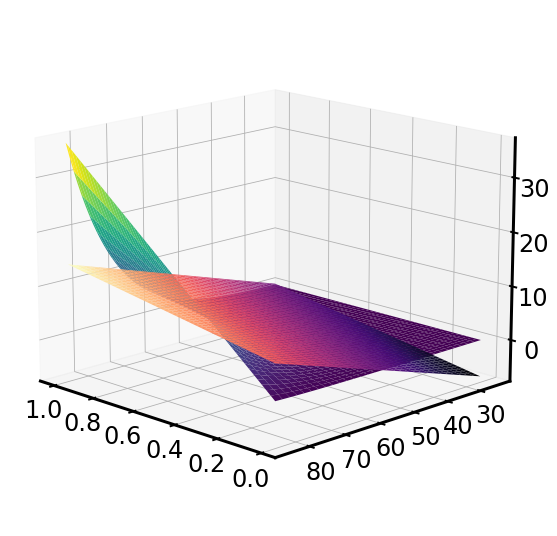

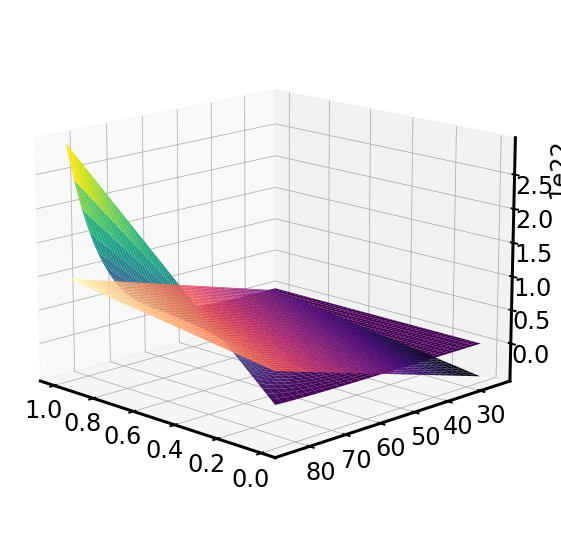

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Pressure and temperature ranges to plot
P_O2_base = np.linspace(0.01,1,num=100)*101325
T_Kelvin = np.linspace(25,85,num=61) + 273.15
# mesh the grid
PP,TT = np.meshgrid(P_O2_base,T_Kelvin,indexing='ij')

vQ_O2 = h**3*(2*np.pi*m_O2*kB*TT)**(-3/2) # quantum volume of O2 [m3]

#fig, ax = plt.subplots(2,2,figsize=(16,16))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#for xMA in (0,0.5,1):
    
xMA = 0.5

E_ads_O2 = lambda x: (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*x)*1.6e-19 # linear relationship based on composition
E_act_O2 = lambda x: Ea_fit[0]*x**2 + Ea_fit[1]*x + Ea_fit[2]
PhOx_RC  = lambda x: np.exp(R0_fit[0]*x**2 + R0_fit[1]*x + R0_fit[2])

# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2(xMA)/(kB*TT))*(kB*TT)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
theta_O2 = Keq_O2*PP/(1+Keq_O2*PP)

# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*TT)/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*TT)/(2*np.pi*h_bar**2))**(3/2)
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*TT)))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(1.2/(8.617e-5*TT)))

PhOxRate_Langmuir = theta_O2*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))
PhOxRate_Henry = PhOx_RC(xMA)*PP*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))
#PhOxRate_Henry = PP*n_exc*np.exp(-E_act_O2(xMA)/(8.617e-5*TT))


ax.plot_surface(PP/101325,TT-273.15,PhOxRate_Langmuir,cmap=cm.viridis)

obs_list = []
for ii in range(PP.shape[0]):
    for jj in range (PP.shape[1]):
        obs_list.append([PP[ii,jj],TT[ii,jj],PhOxRate_Langmuir[ii,jj],PhOxRate_Henry[ii,jj]])

obs_DF = pd.DataFrame(obs_list,columns=['Pressure [Pa]','Temperature [K]','Langmuir','Henry'])



X = obs_DF[['Pressure [Pa]','Temperature [K]']]

Y = obs_DF['Langmuir']
reg = LinearRegression().fit(X,Y)
Langmuir_fit = reg.intercept_ + reg.coef_[0]*PP + reg.coef_[1]*TT
ax.plot_surface(PP/101325,TT-273.15,Langmuir_fit,cmap=cm.magma)
ax.view_init(15,135)


fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

Y2 = obs_DF['Henry']
reg2 = LinearRegression().fit(X,Y2)
Henry_fit = reg2.intercept_ + reg2.coef_[0]*PP + reg2.coef_[1]*TT
ax2.plot_surface(PP/101325,TT-273.15,PhOxRate_Henry,cmap=cm.viridis)

ax2.plot_surface(PP/101325,TT-273.15,Henry_fit,cmap=cm.magma)
ax2.view_init(15,135)


In [37]:
obs_DF.head

<bound method NDFrame.head of       Pressure [Pa]  Temperature [K]   Langmuir         Henry
0           1013.25           298.15   0.001034  1.726869e+17
1           1013.25           299.15   0.001164  2.002620e+17
2           1013.25           300.15   0.001308  2.320152e+17
3           1013.25           301.15   0.001468  2.685450e+17
4           1013.25           302.15   0.001648  3.105306e+17
...             ...              ...        ...           ...
6095      101325.00           354.15  26.196618  1.948299e+22
6096      101325.00           355.15  28.449143  2.165561e+22
6097      101325.00           356.15  30.880555  2.405651e+22
6098      101325.00           357.15  33.503852  2.670818e+22
6099      101325.00           358.15  36.332883  2.963516e+22

[6100 rows x 4 columns]>

# 3. Data Visualization - Nonlinearity

Make some box and whisker plots of the overall dataset to illustrate how the data vary nonlinearly with temperature and composition

In [45]:
# Initialize the figure
fig, ax = plt.subplots(1,2,figsize=(24,12))

# temperature bins
T25 = []
T45 = []
T65 = []
T85 = []

# initialize bins for composition
MA_rich = []
MA_bal = []
MA_lean = []

# loop over datapoints in the DF
for ii in range(len(rawdata_df)):
    
    # get environmental parameters for help in plotting
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    # use environmental variables to define the plot style
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    # grab composition
    xMA = rawdata_df['MA fraction'].iloc[ii]
    # grab tLD75
    y = np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii])
    
    # plot temperature with random jitter
    ax[0].plot(rawdata_df['Temp (deg C)'].iloc[ii]+random.gauss(0,0.75),y,
             color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot MA fraction with random jitter
    ax[1].plot(xMA+random.gauss(0,0.01),y,
             color=[xMA,0,1-xMA],marker='o',markersize=10)
    
    # bin runs by temperature
    if T < 35:
        if not np.isnan(y):
            T25.append(y)
    elif T < 55:
        if not np.isnan(y):
            T45.append(y)
    elif T < 75:
        if not np.isnan(y):
            T65.append(y)
    else:
        if not np.isnan(y):
            T85.append(y)
    
    # and also by composition
    if xMA < 0.33:
        if not np.isnan(y):
            MA_lean.append(y)
    elif xMA >= 0.33 and xMA < 0.66:
        if not np.isnan(y):
            MA_bal.append(y)
    else:
        if not np.isnan(y):
            MA_rich.append(y)
            
# add the box and whisker plots for temperature...
ax[0].boxplot([T25,T45,T65,T85],positions=[25,45,65,85],widths=[5,5,5,5],showfliers=False)
ax[0].set_xlim([20,90])
ax[0].set_xlabel('Temperature ($\degree$C)')
ax[0].set_ylabel('$\ln(t_{L_\mathrm{D},80})$')

# ...and composition
ax[1].boxplot([MA_lean,MA_bal,MA_rich],positions=[0,0.5,1.0],labels=['MA-Lean','Balanced','MA-Rich'],showfliers=False)
ax[1].set_xlim([-0.25,1.25])
ax[1].set_xlabel('MA fraction')
ax[1].set_ylabel('$\ln(t_{L_\mathrm{D},80})$')
ax[1].vlines(0.33,1,7,color='k',linestyle='--')
ax[1].vlines(0.67,1,7,color='k',linestyle='--')



# 4. Basic Plots of the Dataset - Contextualizing LD75

Before modeling, it is always advisable to analyze the dataset by visualization to better contextualize the predictions of the model. Here is where we make some plots for figures in the paper. 

(0.0, 50.0)

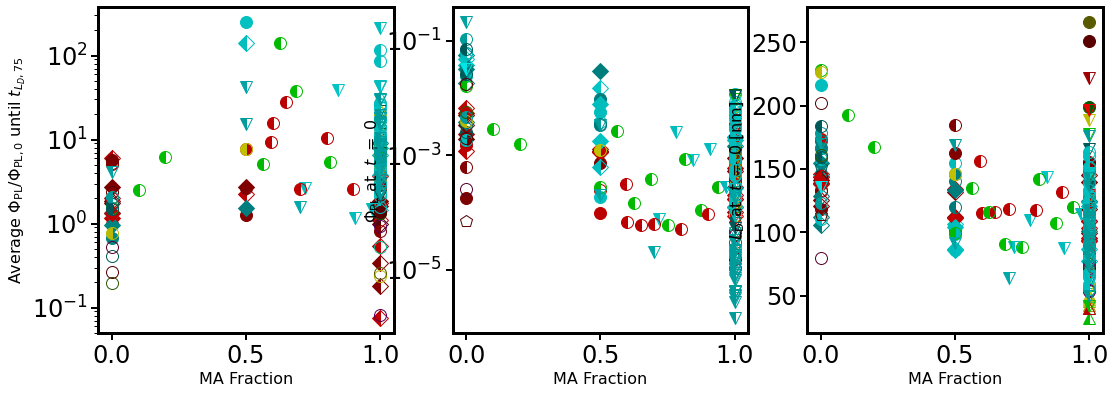

In [46]:
# Make some plots of the overall dataset
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(21,14))

def_fontsize = 16
def_labelsize = 14

ax00_xmin = -0.05
ax00_xmax = 1.05
ax00_ymin = 10**-2.05
ax00_ymax = 10**3.05

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,0].hlines(1,ax00_xmin,ax00_xmax,color='k',linestyles='-') # boundary
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymax,ax00_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[0,0].fill([ax00_xmin,ax00_xmax,ax00_xmax,ax00_xmin],[1,1,ax00_ymin,ax00_ymin],color=(0.56,0,0.8,0.1)) # darkened region


# set markers using environmental condition marker conventions
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    # plot PL enhancement at tLD75 vs composition
    ax[0,0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLFail'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot QFLS enhancement at failure vs composition
    ax[1,0].plot(rawdata_df['MA fraction'].iloc[ii],100*(1 + 0.059*np.log10(rawdata_df['PLFail'].iloc[ii]/rawdata_df['QFLS_0'].iloc[ii])), 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot transmittance enhancement at failure vs composition
    ax[0,2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['Tr_LD80'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    # plot tLD75 vs. composition
    ax[1,2].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['tLD75 (min)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)

# labeling - top left plot
ax[0,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,0].set_ylabel('$\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,0].set_xlim(ax00_xmin,ax00_xmax)
ax[0,0].set_ylim(ax00_ymin,ax00_ymax)

# set parameters for bottom left plot - quasi-Fermi level splitting enhancement vs. composition
ax10_xmin = -0.1
ax10_xmax = 1.1
ax10_ymin = 85
ax10_ymax = 120
ax[1,0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,0].set_ylabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,75}$ [%]',fontsize=def_fontsize)

# plot demarcations between QFLS enhancement vs. QFLS reduction
ax[1,0].hlines(100,ax10_xmin,ax10_xmax,color='k',linestyles='-') # boundary
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymax,ax10_ymax],color=(1,0.96,0,0.1)) # brightened region
ax[1,0].fill([ax10_xmin,ax10_xmax,ax10_xmax,ax10_xmin],[100,100,ax10_ymin,ax10_ymin],color=(0.56,0,0.8,0.1)) # darkened region
ax[1,0].set_xlim([-0.05,1.05])
ax[1,0].set_ylim([87,120])

# set labels for top right plot - change in transmittance at tLD75
ax[0,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[0,2].set_ylabel('Transmittance at $t_{L_D,80}$',fontsize=def_fontsize)

# set labels for bottom right plot - LD75 vs composition
ax[1,2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax[1,2].set_ylabel('$t_{L_D,75}$ [min]',fontsize=def_fontsize)

# set dimensions for top middle panel - histogram of PL enhancements
ax[0,1].hist(np.log10(rawdata_df['PLFail'].dropna()),bins=np.linspace(-2,3,num=21),
             color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[0,1].set_xlabel('log($\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$) at $t_{L_D,75}$',fontsize=def_fontsize)
ax[0,1].set_ylabel('Frequency',fontsize=def_fontsize)

# partition graph between regions where PL has brightened/has darkened at LD75
ax[0,1].vlines(0,0,15,color='k',linestyles='--')
ax[0,1].fill([0,0,3,3],[0,15,15,0],color=(1,0.96,0,0.1)) # brightened region
ax[0,1].fill([0,0,-2,-2],[0,15,15,0],color=(0.56,0,0.8,0.1)) # brightened region
ax[0,1].set_xlim(-2,3)
ax[0,1].set_ylim(0,15)

# bottom middle plot - histogram of change in QFLS at failure
ax[1,1].hist(0.059*np.log10(rawdata_df['PLFail']),bins=np.linspace(-0.1,0.15,num=21))
ax[1,1].set_xlabel('Net Change in $\Delta E_F$ at $t_{L_D,75}$ [eV]',fontsize=def_fontsize)
ax[1,1].set_ylabel('Frequency',fontsize=def_fontsize)

# change the tick label sizes on all the panels
for ii in range(2):
    for jj in range(3):
        ax[ii,jj].tick_params(axis='x', labelsize=def_labelsize)
        ax[ii,jj].tick_params(axis='y', labelsize=def_labelsize)

# make a new figure
fig2,ax2 = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    
    ax2[0].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLEnhance'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[1].semilogy(rawdata_df['MA fraction'].iloc[ii],rawdata_df['PLQY_0'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
    ax2[2].plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['LD_0 (nm)'].iloc[ii], 
               color=color,fillstyle=fill,marker=marker,linestyle=style)
    
ax2[0].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[0].set_ylabel('Average $\Phi_\mathrm{PL}/\Phi_\mathrm{PL,0}$ until $t_{L_D,75}$',fontsize=def_fontsize)
    
ax2[1].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[1].set_ylabel('$\Phi_\mathrm{PL}$ at  $t\ =\ 0$',fontsize=def_fontsize)    

ax2[2].set_xlabel('MA Fraction',fontsize=def_fontsize)
ax2[2].set_ylabel('$L_\mathrm{D}$ at  $t\ =\ 0$ [nm]',fontsize=def_fontsize)

fig3, ax3 = plt.subplots(figsize=(8,8))
ax3.hist((100*(1 + 0.059*np.log10(rawdata_df['PL_LD80']/rawdata_df['QFLS_0']))).dropna(), 
         bins = np.linspace(85,120,num=15),color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax3.set_xlabel('$\Delta E_F/\Delta E_{F,0}$ at $t_{L_D,80}$ [%]')
ax3.set_ylabel('Frequency')

# partition graph between regions where PL has brightened/has darkened at LD75
ax3.vlines(100,0,50,color='k',linestyles='--')
ax3.fill([100,100,125,125],[0,50,50,0],color=(1,0.96,0,0.1)) # brightened region
ax3.fill([100,100,85,85],[0,50,50,0],color=(0.56,0,0.8,0.1)) # brightened region
ax3.set_xlim(85,125)
ax3.set_ylim(0,50)

Fraction of runs with initially decreasing mobility 0.8277777777777777
Fraction of runs with initially increasing carrier lifetime 0.9


"plt.figure()\nfor ii in range(len(rawdata_df)):\n    T = rawdata_df['Temp (deg C)'].iloc[ii]\n    RH = rawdata_df['RH (%)'].iloc[ii]\n    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]\n    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]\n    encap = 'none'\n    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)\n    plt.loglog(rawdata_df['mu_LD75'].iloc[ii],rawdata_df['tau_LD75'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)\n\nplt.hlines(1,8e-3,2e0) \nplt.vlines(1,3e-1,5e1)\nmu_range = np.linspace(1e-2,2e0,num=101)\nplt.plot(mu_range,0.75**2/mu_range,'k--')\nplt.xlim([8e-3,2e0])\nplt.xlabel('$\\mu(t_{L_\\mathrm{D},75})/\\mu_0$')\nplt.ylabel('$\\tau(t_{L_\\mathrm{D},75})/\\tau_0$')\n    \nplt.figure()\nfor ii in range(len(rawdata_df)):\n    MA_frac = rawdata_df['MA fraction'].iloc[ii]\n    comp_color = np.array([0,0,1]) + np.array([1,0,-1])*MA_frac\n    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)\n    

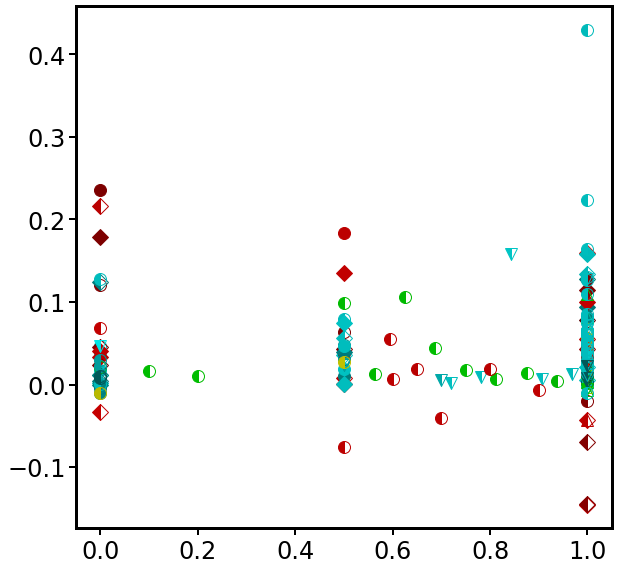

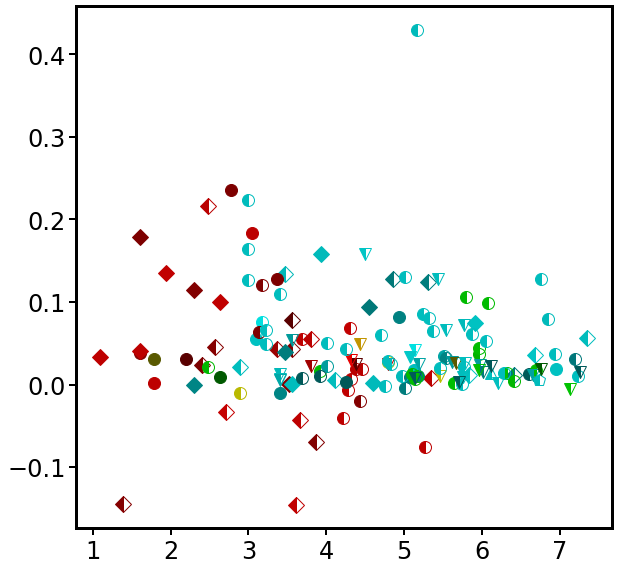

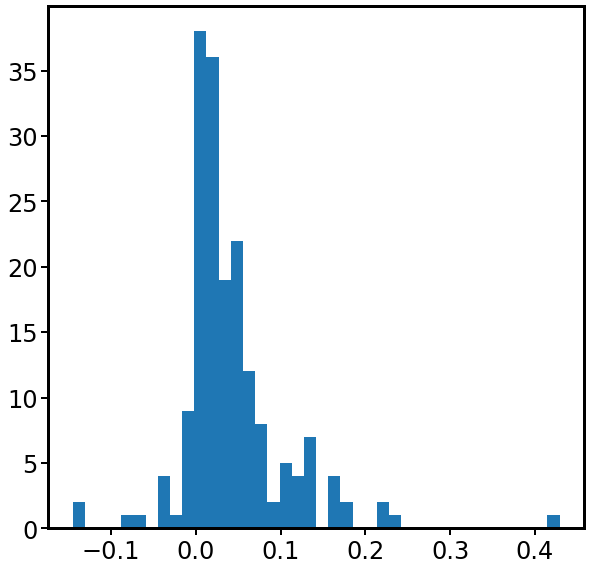

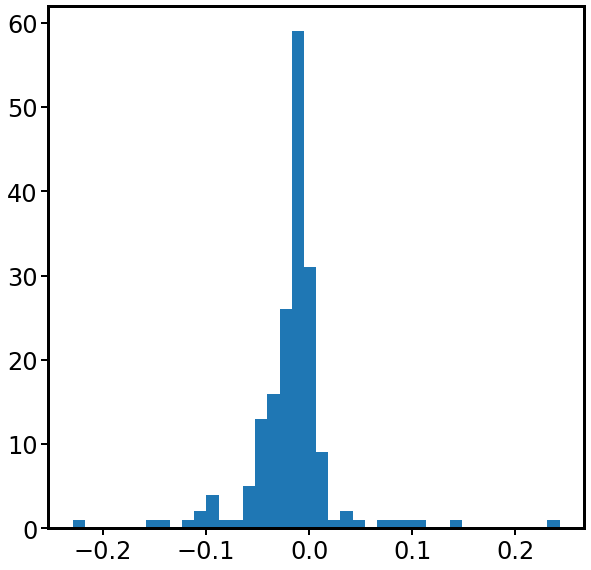

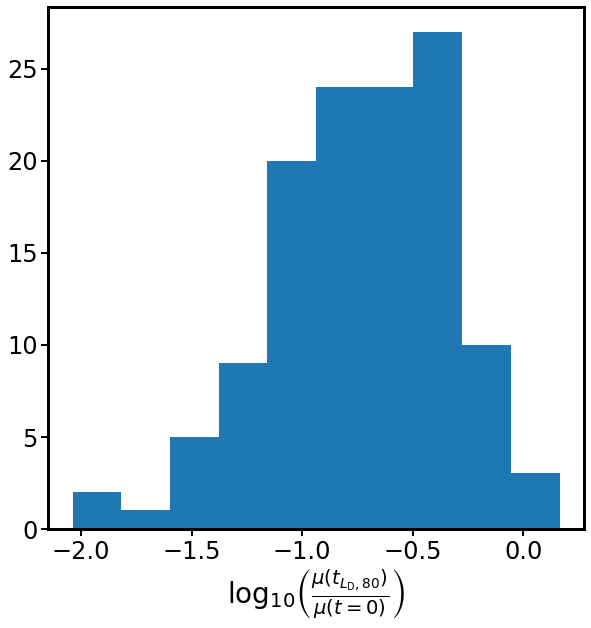

In [48]:
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(rawdata_df['MA fraction'].iloc[ii],rawdata_df['dtaudt'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)


plt.figure()
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.plot(np.log(rawdata_df['tLD80 corrected (min)'].iloc[ii]),rawdata_df['dtaudt'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)

plt.figure()
plt.hist(rawdata_df['dtaudt'].values,bins=40)

plt.figure()
plt.hist(rawdata_df['dmudt'].values,bins=40)

neg_count = 0
for ii in range(len(rawdata_df)):
    if rawdata_df['dmudt'].iloc[ii]<0:
        neg_count += 1
print('Fraction of runs with initially decreasing mobility',neg_count/ii)

pos_count = 0
for ii in range(len(rawdata_df)):
    if rawdata_df['dtaudt'].iloc[ii]>0:
        pos_count += 1
print('Fraction of runs with initially increasing carrier lifetime',pos_count/ii)

plt.figure()
plt.hist(np.log10(rawdata_df['mu_LD75'].values))
plt.xlabel('$\mathrm{log}_{10}\\left(\\frac{\mu(t_{L_\mathrm{D},80})}{\mu(t=0)}\\right)$')

'''plt.figure()
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['mu_LD75'].iloc[ii],rawdata_df['tau_LD75'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)

plt.hlines(1,8e-3,2e0) 
plt.vlines(1,3e-1,5e1)
mu_range = np.linspace(1e-2,2e0,num=101)
plt.plot(mu_range,0.75**2/mu_range,'k--')
plt.xlim([8e-3,2e0])
plt.xlabel('$\mu(t_{L_\mathrm{D},75})/\mu_0$')
plt.ylabel('$\\tau(t_{L_\mathrm{D},75})/\\tau_0$')
    
plt.figure()
for ii in range(len(rawdata_df)):
    MA_frac = rawdata_df['MA fraction'].iloc[ii]
    comp_color = np.array([0,0,1]) + np.array([1,0,-1])*MA_frac
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    plt.loglog(rawdata_df['mu_LD75'].iloc[ii],rawdata_df['tau_LD75'].iloc[ii],color=comp_color,marker='o',linestyle=style)
   
plt.hlines(1,8e-3,2e0) 
plt.vlines(1,3e-1,5e1)
mu_range = np.linspace(1e-2,2e0,num=101)
plt.plot(mu_range,0.75**2/mu_range,'k--')
plt.xlim([8e-3,2e0])
plt.xlabel('$\mu(t_{L_\mathrm{D},75})/\mu_0$')
plt.ylabel('$\\tau(t_{L_\mathrm{D},75})/\\tau_0$')'''



(0.0, 20.0)

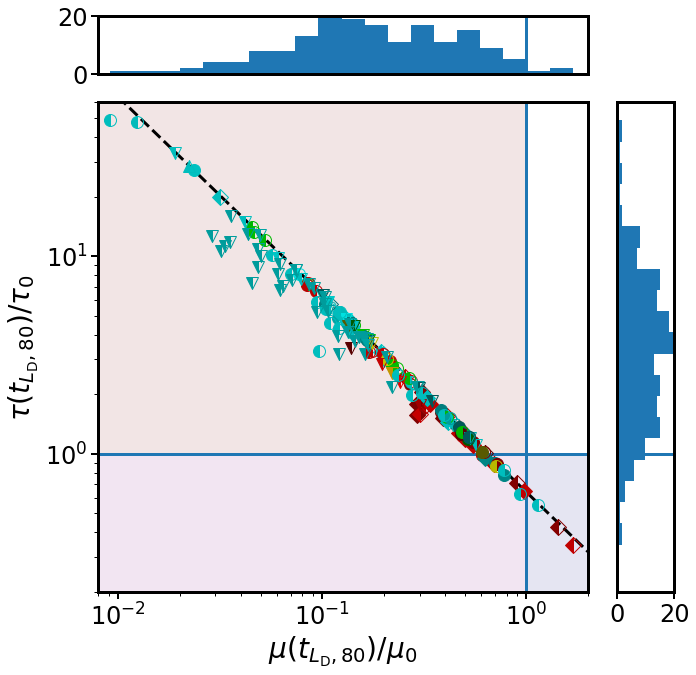

In [63]:
mu_ax_lims = np.array([8e-3,2e0])
log_mu_ax_lims = np.log10(mu_ax_lims)

tau_ax_lims = np.array([2e-1,6e1])
log_tau_ax_lims = np.log10(tau_ax_lims)

mu_tau_fig = plt.figure(figsize=(8,8))
main_ax = mu_tau_fig.add_axes([0,0,0.85,0.85])
main_ax.fill([mu_ax_lims[0],1,1,mu_ax_lims[0],mu_ax_lims[0]],[1,1,tau_ax_lims[1],tau_ax_lims[1],1],color=(0.5,0,0,0.1))
main_ax.fill([mu_ax_lims[0],1,1,mu_ax_lims[0],mu_ax_lims[0]],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0.5,0,0.5,0.1))
main_ax.fill([1,mu_ax_lims[1],mu_ax_lims[1],1,1],[tau_ax_lims[0],tau_ax_lims[0],1,1,tau_ax_lims[0]],color=(0,0,0.5,0.1))
main_ax.hlines(1,8e-3,2e0) 
main_ax.vlines(1,2e-1,6e1)
mu_range = np.linspace(1e-2,2e0,num=101)
main_ax.plot(mu_range,0.8**2/mu_range,'k--')
main_ax.set_xlim(mu_ax_lims)
main_ax.set_ylim(tau_ax_lims)
main_ax.set_xlabel('$\mu(t_{L_\mathrm{D},80})/\mu_0$')
main_ax.set_ylabel('$\\tau(t_{L_\mathrm{D},80})/\\tau_0$')


for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    encap = 'none'
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    main_ax.loglog(rawdata_df['mu_LD80'].iloc[ii],rawdata_df['tau_LD80'].iloc[ii],color=color,fillstyle=fill,marker=marker,linestyle=style)

main_ax.set_xscale('log')
main_ax.set_yscale('log')




tau_ax = mu_tau_fig.add_axes([0.9,0,0.1,0.85])
tau_ax.hist(np.log10(rawdata_df['tau_LD80']),orientation=u'horizontal',bins=20)
tau_ax.set_ylim(log_tau_ax_lims)
tau_ax.set_xlim([0,20])
tau_ax.set_yticks([])
tau_ax.hlines(0,0,20)
#tau_ax.set_title('Carrier Lifetime Change at $t_{L_\mathrm{D},80}$',fontsize=12,loc='left')

mu_ax = mu_tau_fig.add_axes([0,0.9,0.85,0.1])
mu_ax.hist(np.log10(rawdata_df['mu_LD80']),bins=20)
mu_ax.set_xlim(log_mu_ax_lims)
mu_ax.set_xticks([])
mu_ax.vlines(0,0,20)
mu_ax.set_ylim([0,20])
#mu_ax.set_title('Carrier Mobility Change at $t_{L_\mathrm{D},80}$',fontsize=12)

# 5. Feature Pre-Selection

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [9]:
#rawdata_df = rawdata_df[rawdata_df['MA fraction'] == 1]
#rawdata_df = rawdata_df[rawdata_df['Illum (Nsuns)'] == 8]
#rawdata_df = rawdata_df[rawdata_df['Oxygen (%)'] > 0]

# invert 1st derivatives
rawdata_df['dtdT'] = 1/rawdata_df['Bleach Rate (polyfit) (1/min)']
rawdata_df['dtdLD'] = 1/rawdata_df['dLDdt (1/min)']
rawdata_df['dtdPL'] = 1/rawdata_df['dPLdt (1/min)']
 
# invert 2nd derivatives
rawdata_df['d2tdT2'] = 1/rawdata_df['ddTr0']
rawdata_df['d2tdLD2'] = 1/rawdata_df['ddLD0']
rawdata_df['d2tdPL2'] = 1/rawdata_df['ddPL0']

rawdata_df['log_dTdt'] = np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'])
rawdata_df['log_dTdt_full'] = np.log(rawdata_df['Bleach Rate (fit to 5% inc) (1/min)'])

rawdata_df['lnPL80'] = np.log(rawdata_df['PL_LD80'])
rawdata_df['lndTrdt'] = np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'])
rawdata_df['ln|dTrdt|'] = np.log(np.abs(rawdata_df['Bleach Rate (polyfit) (1/min)']))

#rawdata_df['lnModRate'] = np.log(rawdata_df['Modeled Rate'])
#rawdata_df['lnExcRate'] = np.sign(rawdata_df['Excess Rate'])*np.log(np.abs(rawdata_df['Excess Rate']))

# change to True if using a log transform on the response
Log_transform = True

# choose the feature to use as the response
#response = 'Bleach Rate (fit to 5% inc) (1/min)' 
# response = 'Bleach Rate (polyfit) (1/min)' 
response = 'tLD75 (min)'
#response = 'tLD75 corrected (min)'
#response = 'tLD80 corrected (min)'
#response = 'tLD80 (min)'
#esponse = 'tPLmax'
#response = 'PL0'
#response = 'Tr_LD80'
#response = 'lnPL80'

# assign factor labels to each stress
factor_dict = {'A':'Temp (deg C)',
               'B':'RH (%)',
               'C':'Oxygen (%)',
               'D':'Illum (Nsuns)',
               'E':'MA fraction',
               'dTrdt':'Bleach Rate (polyfit) (1/min)',
               'dTrdt_full':'Bleach Rate (fit to 5% inc) (1/min)',
               'dLDdt':'dLDdt (1/min)',
               'dPLdt':'dPLdt (1/min)',
               'LD0':'LD_0 (nm)',
               'PL0':'PLQY_0'}

factor_dict_inv = {'Temp (deg C)':'A',
                   'RH (%)':'B',
                   'Oxygen (%)':'C',
                   'Illum (Nsuns)':'D',
                   'MA fraction':'E',
                   'Bleach Rate (polyfit) (1/min)':'dTrdt',
                   'Bleach Rate (fit to 5% inc) (1/min)':'dTrdt_full',
                   'dLDdt (1/min)':'dLDdt',
                   'dPLdt (1/min)':'dPLdt',
                   'LD_0 (nm)':'LD0',
                   'PLQY_0':'PL0'}

# choose environment, composition, AND early time features

# PL heterogeneity terms to choose from, if desired:
# spatiotemporal = ['xy1t0_0','xy0t1_0','xy1t1_0','t0xy1_0','t1xy0_0','frac_bright_0']


# Features to use, for historical reasons termed "Ryan features"
Ryan_features = [
                 'dTrdt',
               'dLDdt','dPLdt', # features used in ACSEL paper
                 'ddTr0',
                'ddLD0','ddPL0', # features used in ACSEL paper
#                'lndTrdt',
#                'Modeled Rate',
#                'Excess Rate',
                #'lnModRate',
                #'lnExcRate',
#                 'dtdT','dtdLD','dtdPL',
                 #'dtaudt','dmudt', # calculated evolution of carrier properties
#                 'Ld1','Ld2','Ld3','Ld4','Ld5', # features used in ACSEL paper
#                 'Tr1','Tr2','Tr3','Tr4','Tr5', # features used in ACSEL paper
#                 'PL1','PL2','PL3','PL4','PL5', # features used in ACSEL paper
#                 'mu1','mu2','mu3','mu4','mu5',
#                 'tau1','tau2','tau3','tau4','tau5',
                  'A','P_O2','P_H2O','D','E',
#                  'A','B','C','D','E',
#                 'PhotoOx_rate','Hydration_rate'] # physics-inspired features
                 'PhotoOx_rate','Hydration_rate','delS_mix',
#                 'Block_rate',
#                'Opt_Tol',
                'dtaudt','dmudt','ddmu0','ddtau0',
                'LD0','PL0',#'QFLS_0'
#                'ln|dTrdt|',
#                'lnPL80',#'Tr_LD80',
#                 'PhotoOx_rate','Ox_rate_P','Hydration_rate','delS_mix',]
                ]
# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

include_secondary = False
include_tertiary = False
include_quaternary = False
include_quinary = False

# alternative option: add coded multifactor interactions for modeling
n_factors = len(terms_to_keep)
if include_secondary:
    coded_df.insert(n_factors,'AB',coded_df['A']*coded_df['B'])
    coded_df.insert(n_factors+1,'AC',coded_df['A']*coded_df['C'])
    coded_df.insert(n_factors+2,'AD',coded_df['A']*coded_df['D'])
    coded_df.insert(n_factors+3,'AE',coded_df['A']*coded_df['E'])
    coded_df.insert(n_factors+4,'BC',coded_df['B']*coded_df['C'])
    coded_df.insert(n_factors+5,'BD',coded_df['B']*coded_df['D'])
    coded_df.insert(n_factors+6,'BE',coded_df['B']*coded_df['E'])
    coded_df.insert(n_factors+7,'CD',coded_df['C']*coded_df['D'])
    coded_df.insert(n_factors+8,'CE',coded_df['C']*coded_df['E'])
    coded_df.insert(n_factors+9,'DE',coded_df['D']*coded_df['E'])
# quadratic factors of composition
#coded_df.insert(n_factors+10,'EE',coded_df['E']*coded_df['E'])

# tertiary factors
if include_tertiary:
    coded_df.insert(n_factors+10,'ABC',coded_df['A']*coded_df['B']*coded_df['C'])
    coded_df.insert(n_factors+11,'ABD',coded_df['A']*coded_df['B']*coded_df['D'])
    coded_df.insert(n_factors+12,'ABE',coded_df['A']*coded_df['B']*coded_df['E'])
    coded_df.insert(n_factors+13,'ACD',coded_df['A']*coded_df['C']*coded_df['D'])
    coded_df.insert(n_factors+14,'ACE',coded_df['A']*coded_df['C']*coded_df['E'])
    coded_df.insert(n_factors+15,'ADE',coded_df['A']*coded_df['D']*coded_df['E'])
    coded_df.insert(n_factors+16,'BCD',coded_df['B']*coded_df['C']*coded_df['D'])
    coded_df.insert(n_factors+17,'BCE',coded_df['B']*coded_df['C']*coded_df['E'])
    coded_df.insert(n_factors+18,'BDE',coded_df['B']*coded_df['D']*coded_df['E'])
    coded_df.insert(n_factors+19,'CDE',coded_df['C']*coded_df['D']*coded_df['E'])

# quaternary factors
if include_quaternary:
    coded_df.insert(n_factors+20,'ABCD',coded_df['A']*coded_df['B']*coded_df['C']*coded_df['D'])
    coded_df.insert(n_factors+21,'ABCE',coded_df['A']*coded_df['B']*coded_df['C']*coded_df['E'])
    coded_df.insert(n_factors+22,'ABDE',coded_df['A']*coded_df['B']*coded_df['D']*coded_df['E'])
    coded_df.insert(n_factors+23,'ACDE',coded_df['A']*coded_df['C']*coded_df['D']*coded_df['E'])
    coded_df.insert(n_factors+24,'BCDE',coded_df['B']*coded_df['C']*coded_df['D']*coded_df['E'])

if include_quinary:
    coded_df.insert(n_factors+25,'ABCDE',coded_df['A']*coded_df['B']*coded_df['C']*coded_df['D']*coded_df['E'])

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)
   
# display the modeling-ready dataset head    
coded_df.head()

Number of Runs Total: 214
Number of Runs That Fail After Prediction Horizon: 181


C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


A     D    E     dTrdt  tLD75 (min)     dLDdt     dPLdt         LD0  \
0  65.0  16.0  1.0  0.001621         65.0  0.016875  0.147933  113.682561   
1  85.0  32.0  1.0  0.001560         40.0 -0.020039 -0.092575   93.007809   
2  85.0  32.0  1.0  0.002031         29.0  0.014411  0.106959  108.820395   
3  85.0  32.0  1.0  0.002267         44.0 -0.021005  0.138328  103.198333   
4  85.0  32.0  1.0  0.001523         49.0 -0.021298 -0.130374   99.524614   

        PL0     ddTr0  ...     ddLD0    dtaudt     dmudt     ddmu0    ddtau0  \
0  0.000434  0.000046  ...  0.003579  0.059700 -0.019329  0.037024 -0.025787   
1  0.000174  0.000033  ...  0.002057 -0.042778 -0.001682 -0.365775  0.212710   
2  0.000101  0.000030  ...  0.000074  0.043467 -0.011433  0.015047 -0.019779   
3  0.000174  0.000101  ... -0.001562  0.054543 -0.077514 -0.000935 -0.009613   
4  0.000280  0.000026  ... -0.001746 -0.069975  0.045458 -0.225829  0.141148   

         P_H2O      P_O2  PhotoOx_rate  Hydration_rate  delS_mix  
0  1304.224576  21278.25  4.129091e-14        0.000292       0.0  
1  1910.546896  21278.25  9.940153e-14        0.000144       0.0  
2  1247.381858  21278.25  9.940153e-14        0.000094       0.0  
3  1872.651751  21278.25  9.940153e-14        0.000141       0.0  
4   783.166331  21278.25  9.940153e-14        0.000059       0.0  

[5 rows x 21 columns]

# 6. Modeling

In this cell, the machine learning model is initialized and trained. Error metrics and coefficients are calculated and tabulated for visualization in the cells below.

Status: about 0.0% complete...
{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 5.52% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 11.05% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.00630957344480193}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 16.57% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 22.1% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 27.62% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 33.15% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 38.67% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 44.2% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 49.72% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 55.25% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 60.77% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 66.3% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 71.82% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 77.35% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 82.87% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 88.4% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 93.92% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}
Status: about 99.45% complete...


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


For test set:
Mean of Mean Absolute Error = 12.6 %
Median of Mean Absolute Error = 9.0 %
Std. Dev. of Mean Absolute Error = 12.6 %
Mean of Mean Absolute Error = 0.569
Median of Mean Absolute Error = 0.449
Std. Dev. of Mean Absolute Error = 0.459
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 10.7 %
Median of Mean Absolute Error = 10.7 %
Std. Dev. of Mean Absolute Error = 0.0 %
Mean of Mean Absolute Error = 0.498
Median of Mean Absolute Error = 0.498
Std. Dev. of Mean Absolute Error = 0.001
Mean R2 = 0.7291
Median R2 = 0.7294
Std Dev. R2 = 0.0013
Mean Linear Error = 66.0 %
Median Linear Error = 43.0 %
Index of Median Model: 99
{'alpha': 0.01584893192461114}


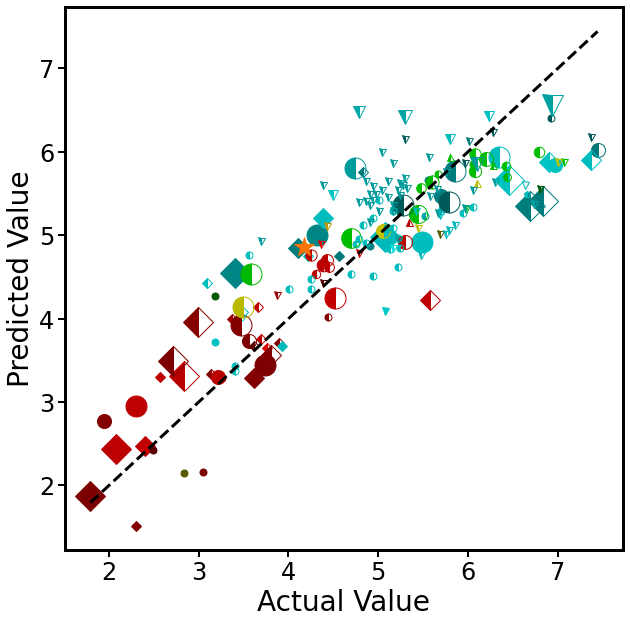

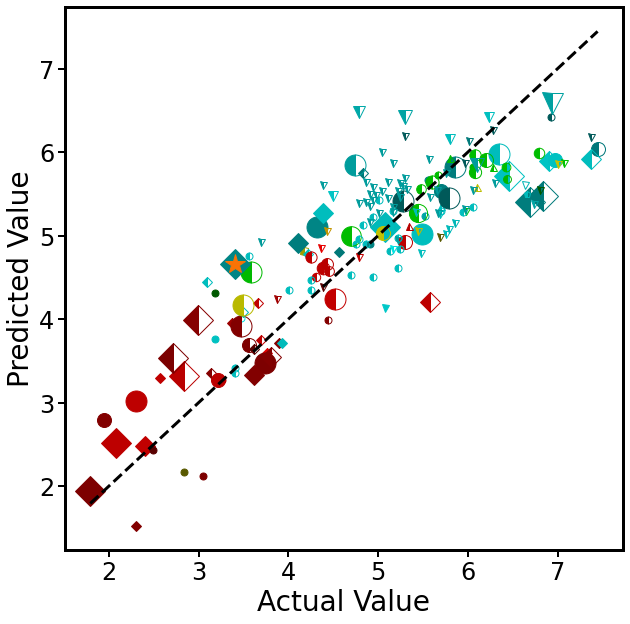

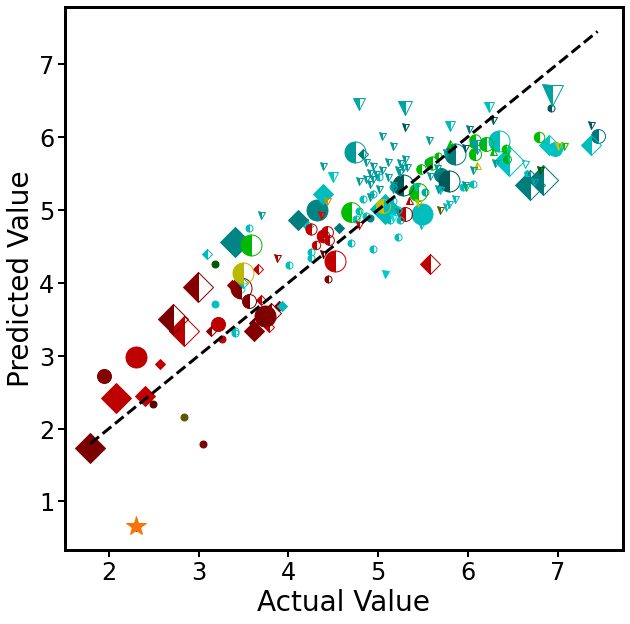

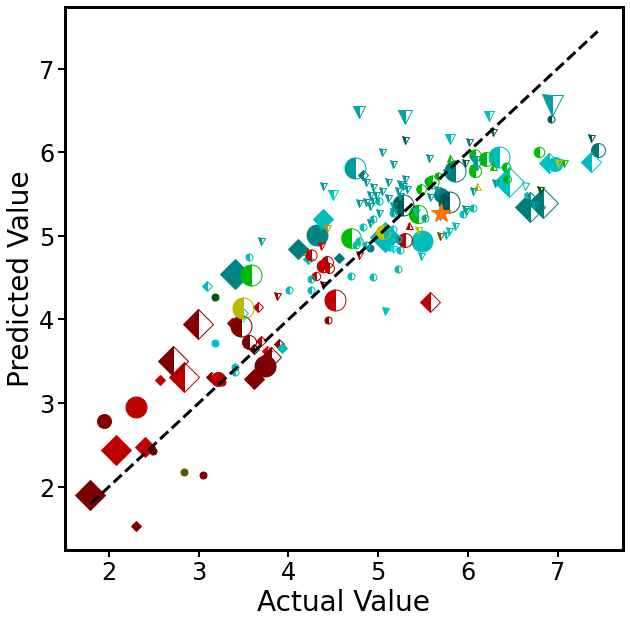

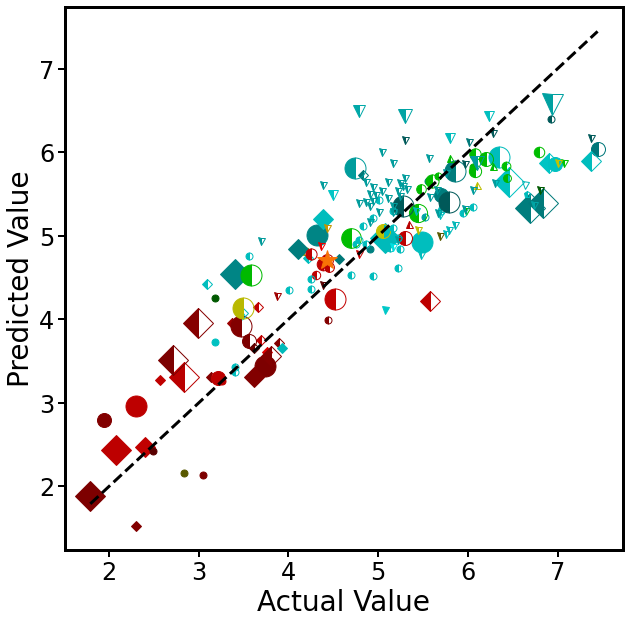

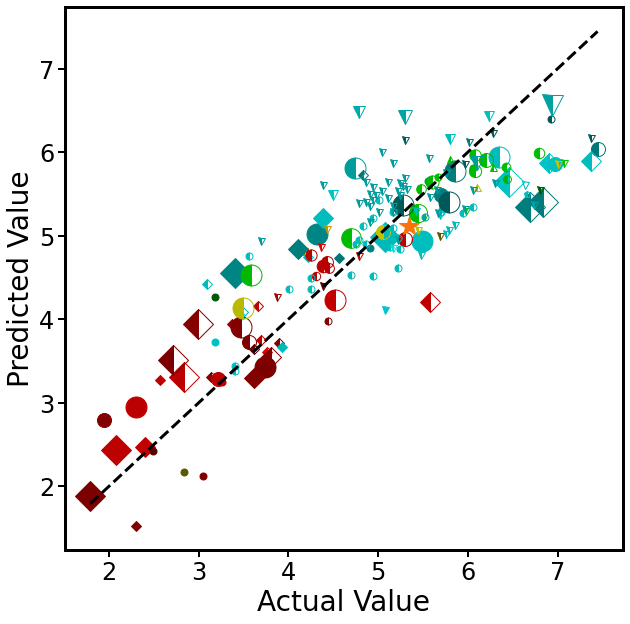

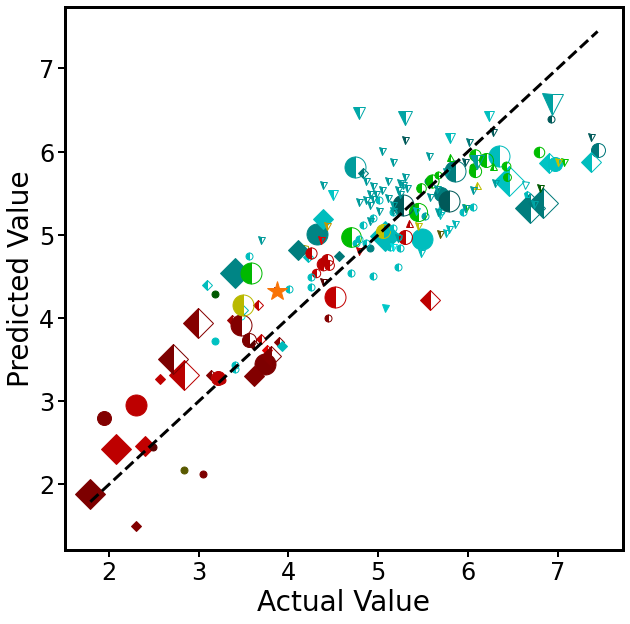

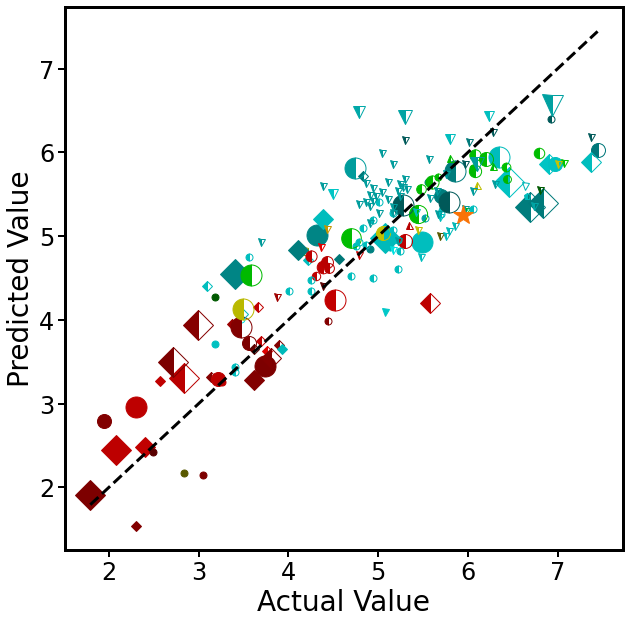

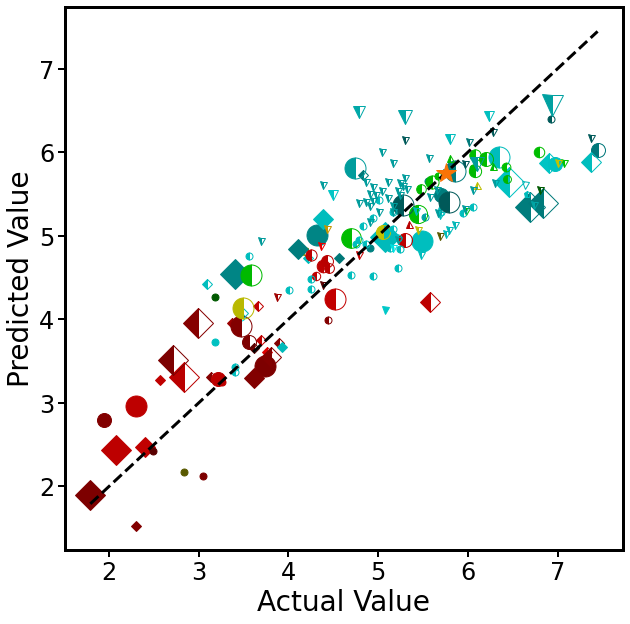

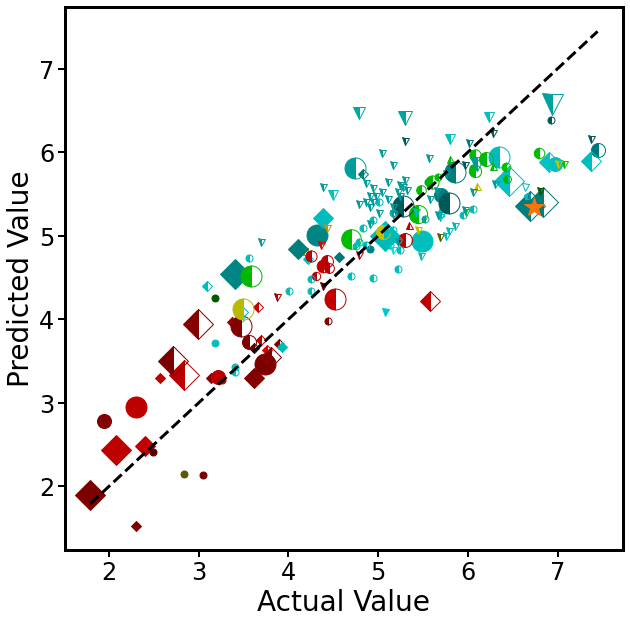

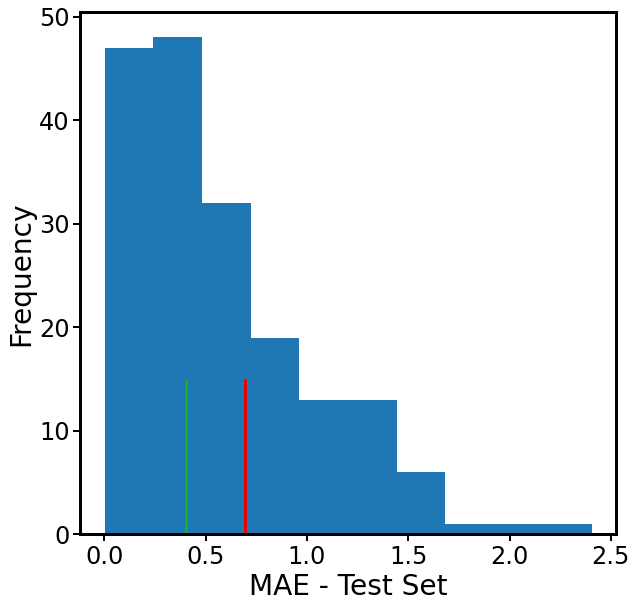

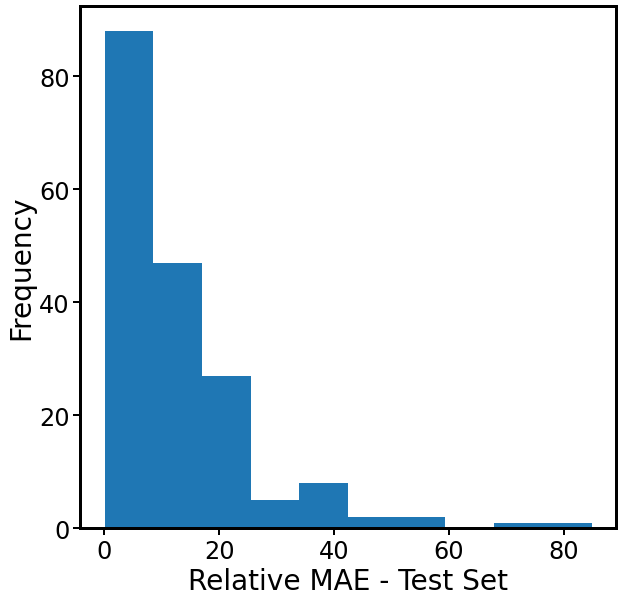

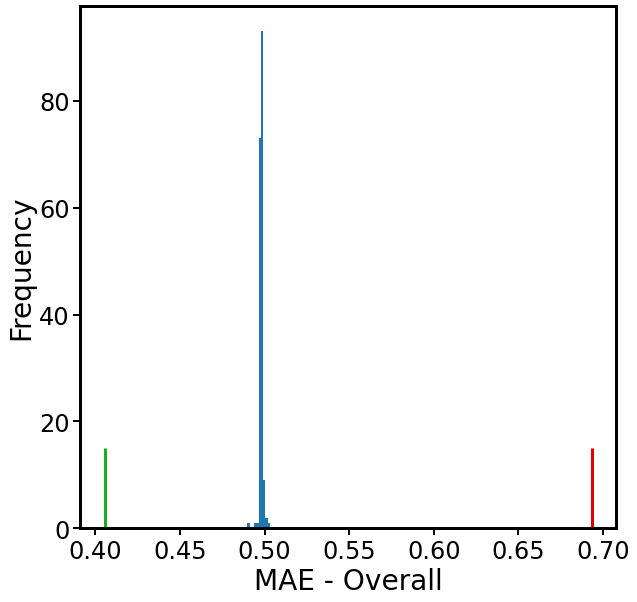

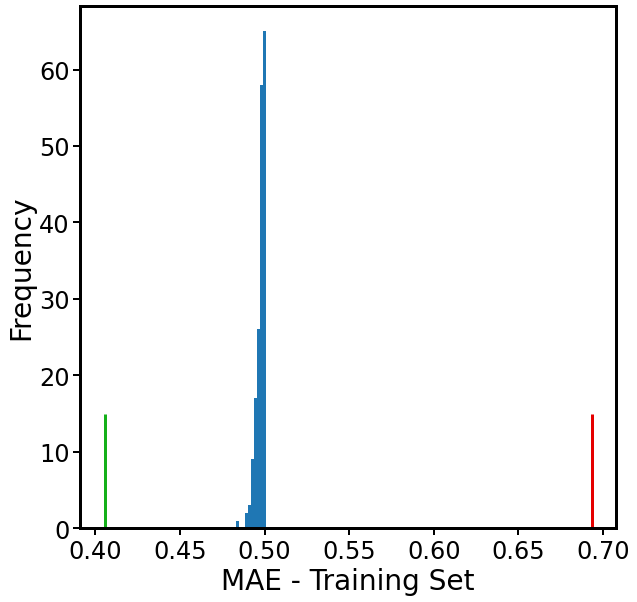

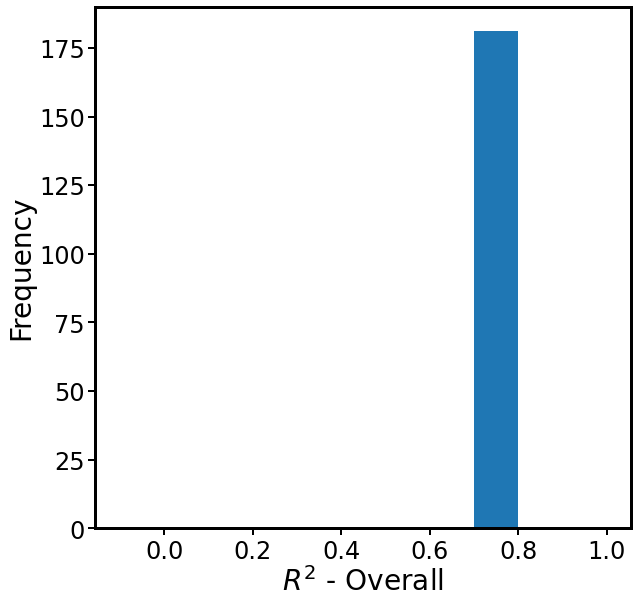

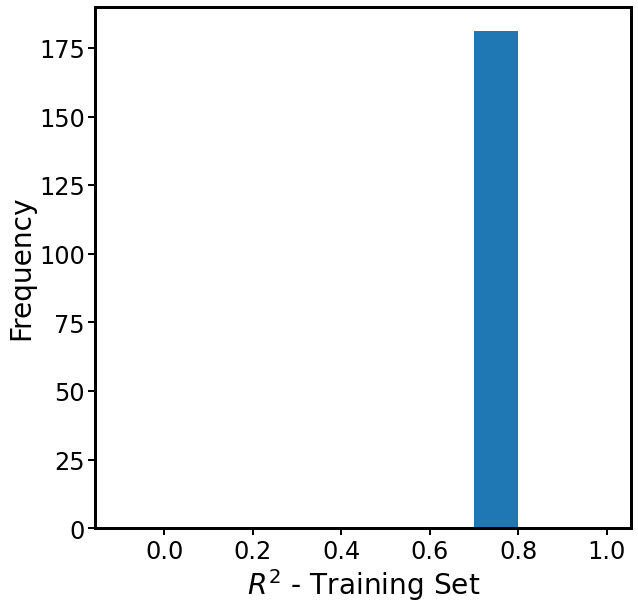

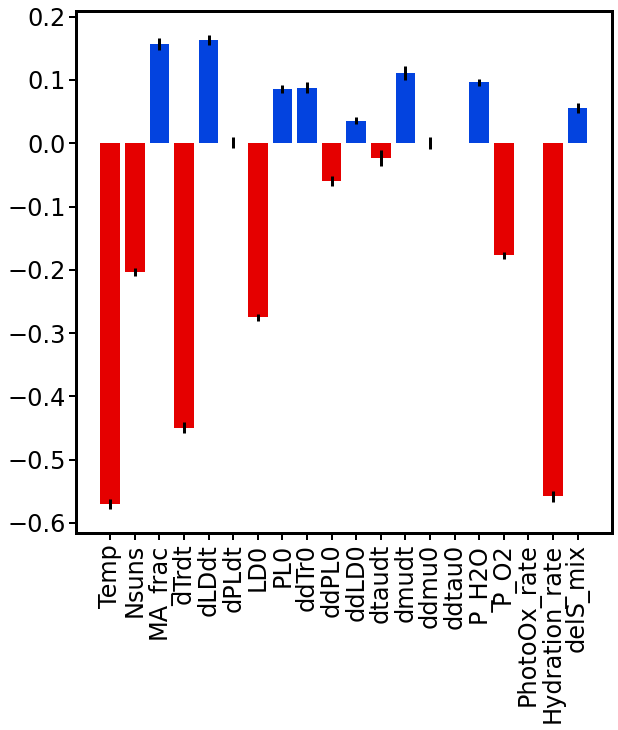

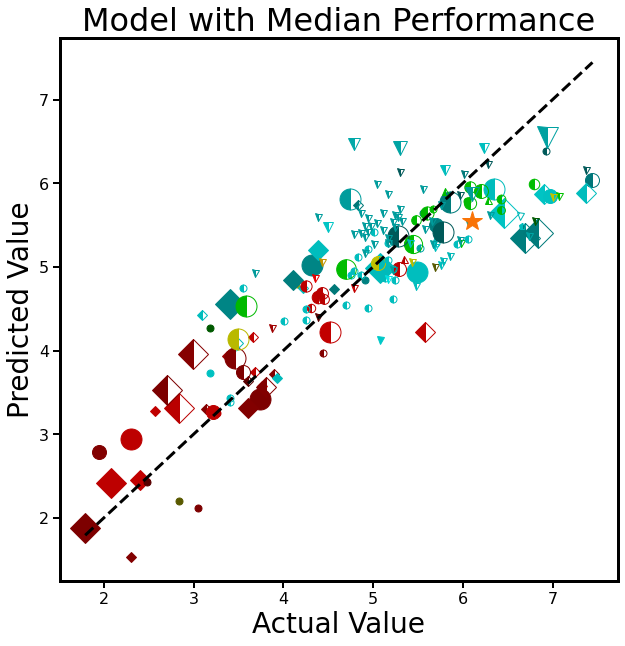

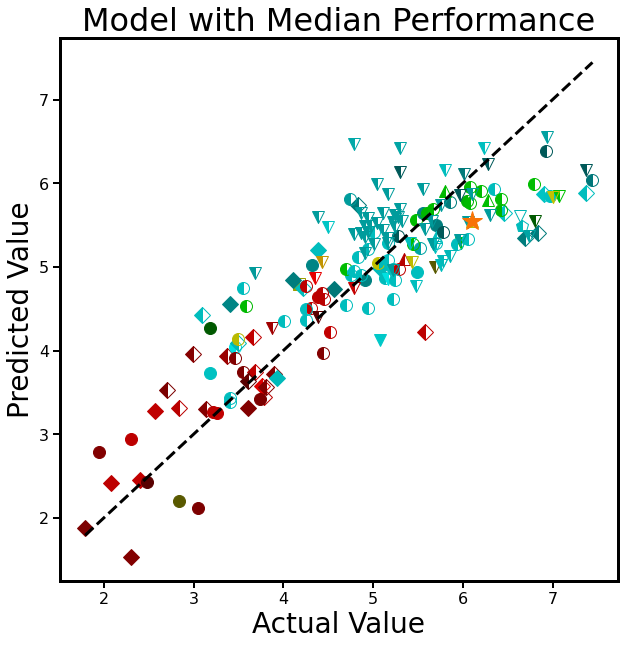

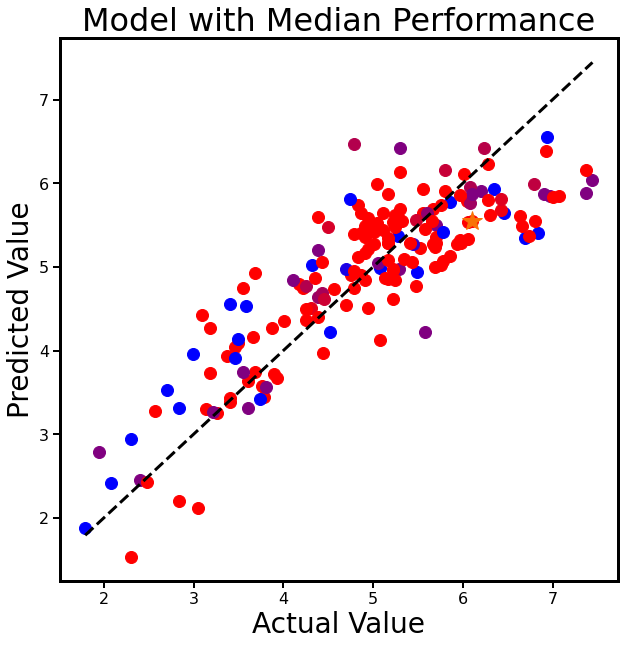

In [10]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform on the response or not, 
# then partition the data into features (X) and response (Y) DFs


if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# change to True if recalculating coefficients after regularization
unshrink_coefficients = False

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
#metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
metric = 'neg_mean_absolute_error'
#metric = 'r2'
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    if kk%10 == 0:
        print('Status: about ' + str(np.round(kk/n_trials * 100,2)) + '% complete...')
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # if desired, recalculate the coefficients:
    if unshrink_coefficients:
        
        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]
        
        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model
        
        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)
        
        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
    
    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
    
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%20 == 0: # only do this for a few models to save memory
        
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            # and plot
            plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value
            
        # plot perfect prediction line and +/-50% error bounds
        plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
        plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        # put labels on the axes
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii] # pull the corresponding index in the DF
            T = rawdata_df['Temp (deg C)'][idx] # get temperature
            RH = rawdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = rawdata_df['MA fraction'][idx] # get composition
            plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                
    
    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))
    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))
    
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))
    
    # sensitivity analysis for feature removal
    sensitivity_analysis = False
    
    if sensitivity_analysis:
        # re-initialize a list for keeping track of error with feature deleted
        d_error_missing_feats_per_obv = []

        # loop over features
        for col in X_train.columns:

            # drop each feature
            X_train_reduced = X_train.drop(columns=col).copy()
            X_whold_reduced = X_whold.drop(col).copy()

            # set alpha/lambda/penalty hyperparameter
            regressor.fit(X_train_reduced,y_train)
            alpha = regressor.best_params_['alpha']

            # train the final model on the full training set
            final_model_red = Lasso(alpha=alpha)
            final_model_red.fit(X_train_reduced,y_train)

            # make predictions on the test and training data
            ypred=final_model_red.predict(np.array(X_whold_reduced).reshape(1,-1))

            # calculate error metrics on test set with the missing feature
            # and append it to the error list
            d_error_missing_feats_per_obv.append(np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100) - MAE_pct[kk])

    if sensitivity_analysis:    
        # save the error with deleted features
        d_error_missing_feats.append(d_error_missing_feats_per_obv)

if sensitivity_analysis:
    # convert the change in error with missing features to a dataframe from epi-list
    missing_feats_DF = pd.DataFrame(d_error_missing_feats,columns=coded_df.drop(columns=response).columns)    

# plot histogram of absolute test set error
plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of percent test set error
plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')

# plot histogram of absolute full set error
plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of absolute training set error
plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of full set R2
plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

# plot histogram of training set R2
plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')

# plot distribution of coefficients...
plt.figure()

# convert labels "A", "B", etc. back to physically meaningful names
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}
coeffs_df.rename(columns = new_dict, inplace = True)

coeffs = coeffs_df.columns # save coefficient names
avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations

# assign colors to coefficient bars based on sign:
# red: accelerates degradation
# blue: decelerates degradation
# (these have different signs depending on what the response is)
bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

# plot the coefficients
plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90) # make the labels legible

# Print important test statistics
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error)),'%')
print('Median Linear Error =',np.round(np.median(linear_error)),'%')


##### Below this line is the code for plotting the performance of the median model

# identify the index corresponding to the median mean test error
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
print('Index of Median Model:',idx)

# partition the dataset - note the manipulations necessary to convert the index derived from 
# the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()

# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

if unshrink_coefficients:

    # figure out which coefficients survived
    surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

    # make a copy of the training set with rejected coefficients stripped out
    X_red = X_train.copy()
    X_red = X_red[surviving_coeffs]
    X_whold_red = X_whold.copy()
    X_whold_red = X_whold_red[surviving_coeffs]
    # retrain the final model

    # train a simple linear regression
    shrunk_model = sklearn.linear_model.LinearRegression()
    shrunk_model.fit(X_red,y_train)

    # and fit the data
    ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
    ytpred=shrunk_model.predict(X_red)

else:
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    #T = X[factor_dict_inv['Temp (deg C)']][idx]
    #RH = X[factor_dict_inv['RH (%)']][idx]
    #pct_O2 = X[factor_dict_inv['Oxygen (%)']][idx]
    #N_suns_stress = X[factor_dict_inv['Illum (Nsuns)']][idx]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above, with environment denoted by marker appearance and composition by marker size
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############
# i.e., separate plots encoding environment and composition

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

##### COMPOSITION AS ONLY DISTINGUISHING FEATURE    

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = rawdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o')
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 

In [84]:
# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(np.mean(missing_feats_DF)) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = missing_feats_DF.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = bars_df['means'] # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('Mean Increase in Test Set Error as a Result of Dropping Feature [%]')

NameError: name 'missing_feats_DF' is not defined

A     D    E     dTrdt     dLDdt     dPLdt         LD0       PL0  \
19  85.0   8.0  0.0  0.000736  0.010450  0.221149  133.264830  0.001764   
21  85.0   8.0  0.0  0.000615  0.003976  0.499553  132.580672  0.000636   
22  85.0  32.0  0.0  0.000562  0.010857  0.843375  146.365505  0.001194   
25  85.0   8.0  0.0  0.000462 -0.039032  0.002906  173.781098  0.001508   
29  85.0  32.0  0.0  0.000283 -0.007797  0.053549  125.517030  0.003358   
32  85.0   8.0  0.0  0.000958  0.024014  0.986865  118.703884  0.000179   
35  25.0  32.0  0.0  0.000002  0.006328  0.439098  105.688895  0.003795   
53  25.0  32.0  0.0  0.000132  0.001232  0.026522  111.873623  0.018219   
88  25.0   1.0  0.0  0.000003  0.003268  0.028341  169.951613  0.212743   
91  85.0  32.0  0.0  0.000807 -0.046872  0.104322  138.944029  0.005455   

       ddTr0     ddPL0  ...    dtaudt     dmudt     ddmu0    ddtau0  \
19 -0.000041  0.015421  ...  0.068259 -0.029457  0.008584  0.002031   
21 -0.000014  0.043511  ...  0.120984 -0.055276  0.013513 -0.001047   
22 -0.000044  0.185840  ...  0.216429 -0.103408  0.010542  0.028007   
25 -0.000035  0.026612  ...  0.001930 -0.073581 -0.006188  0.011236   
29  0.000029  0.182050  ...  0.023494 -0.039337 -0.106639  0.084930   
32 -0.000140 -0.057088  ...  0.235920 -0.089270  0.103316 -0.072436   
35  0.000005  0.004591  ...  0.124428 -0.041645  0.012123 -0.007778   
53 -0.000007 -0.004276  ...  0.012004 -0.007416  0.001983 -0.002089   
88 -0.000002 -0.000042  ...  0.011565 -0.003049  0.000386 -0.000105   
91 -0.000031  0.010741  ...  0.040775 -0.108793 -0.020498  0.003105   

          P_H2O       P_O2  PhotoOx_rate  Hydration_rate  delS_mix    lndTrdt  
19  1992.653044   21278.25  2.827135e-15    4.418507e-07  0.455886  -7.213942  
21   783.166331   21278.25  2.827135e-15    1.736593e-07  0.455886  -7.393960  
22  1850.546250   21278.25  7.460854e-15    4.103400e-07  0.455886  -7.483948  
25  1894.757253  101325.00  1.346255e-14    4.201433e-07  0.455886  -7.679781  
29   669.480896   21278.25  7.460854e-15    1.484507e-07  0.455886  -8.170597  
32   682.112611  101325.00  1.346255e-14    1.512516e-07  0.455886  -6.951028  
35   675.796753   21278.25  1.113745e-15    1.811080e-06  0.455886 -13.127376  
53   631.585751   21278.25  1.113745e-15    1.692598e-06  0.455886  -8.932739  
88  1364.225222   21278.25  9.844210e-17    3.656004e-06  0.455886 -12.621588  
91  1894.757253  101325.00  3.552788e-14    4.201433e-07  0.455886  -7.121880  

[10 rows x 22 columns]

In [ ]:
import seaborn as sns

shvals_mean = np.mean(Shap_vals_df)
#plt.bar(Shap_vals_df.columns,shvals_mean)
#ax=plt.gca()
#ax.set_xticklabels(Shap_vals_df.columns,rotation=90)


Shap_vals_abs = Shap_vals_df.copy()
for col in Shap_vals_abs.columns:
    vals = Shap_vals_abs[col].values
    vals = np.abs(vals)
    Shap_vals_abs[col] = vals
    
Shap_vals_abs.boxplot(rot=90)
abs_means = np.mean(Shap_vals_abs)

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(abs_means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = Shap_vals_abs.columns # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean


plt.figure()
plt.bar(bars_df.index,bars_df['means'])
ax=plt.gca()
ax.set_xticklabels(bars_df.index,rotation=90)
plt.ylabel('|Feature Shapley Value|')

In [ ]:
# Look at collinearity of derivatives with early time points

for jj in [1,2,3,4,5]:
    fig, ax = plt.subplots(figsize=(5,5))
    for ii in range(len(rawdata_df)):
        ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr'+str(jj)].iloc[ii],'.')
        #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
    ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Tr'+str(jj)])[0],4)))
    ax.set_xlabel('Bleaching Rate [1/min]')
    ax.set_ylabel('$\\frac{\mathscr{T}}{\mathscr{T}_0}(t=$'+str(jj)+'$)$')
#rawdata_df.head()

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['dPLdt (1/min)'].iloc[ii],rawdata_df['PL1'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['dPLdt (1/min)'],rawdata_df['PL1'])[0],4)))
ax.set_xlabel('$\\frac{\mathrm{d}\Phi_\mathrm{PL}}{\mathrm{d}t}$ [1/min]')
ax.set_ylabel('$\\frac{\Phi_\mathrm{PL}}{\Phi_\mathrm{PL,0}}(t=1)$')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Oxygen (%)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Oxygen (%)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Oxygen Content')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    ax.plot(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Illum (Nsuns)'].iloc[ii],'.')
    #plt.text(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Tr1'].iloc[ii],str(ii))
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Illum (Nsuns)'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Illumination Intensity [$N_\mathrm{suns}$]')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Langmuir Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['PhotoOx_rate_P'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['PhotoOx_rate_P'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Henry Photooxidation Rate')

fig, ax = plt.subplots(figsize=(5,5))
for ii in range(len(rawdata_df)):
    T = rawdata_df['Temp (deg C)'].iloc[ii]
    RH = rawdata_df['RH (%)'].iloc[ii]
    pct_O2 = rawdata_df['Oxygen (%)'].iloc[ii]
    N_suns_stress = rawdata_df['Illum (Nsuns)'].iloc[ii]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax.loglog(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii],rawdata_df['Hydration_rate'].iloc[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
ax.set_title('Pearson R ='+str(np.round(scipy.stats.pearsonr(rawdata_df['Bleach Rate (polyfit) (1/min)'],rawdata_df['Hydration_rate'])[0],4)))
ax.set_xlabel('Bleaching Rate [1/min]')
ax.set_ylabel('Hydration Rate')

# 7. View Coefficient Summaries

For each iteration of the test set loop, we pulled out the values of the coefficients corresponding to each feature; let's look more closely at some statistics to determine how the models look

<ipython-input-55-05cc12e29839>:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-55-05cc12e29839>:204: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-55-05cc12e29839>:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fancy_labels,rotation=90)


Text(0.5, 0.9, 'Feature Weights')

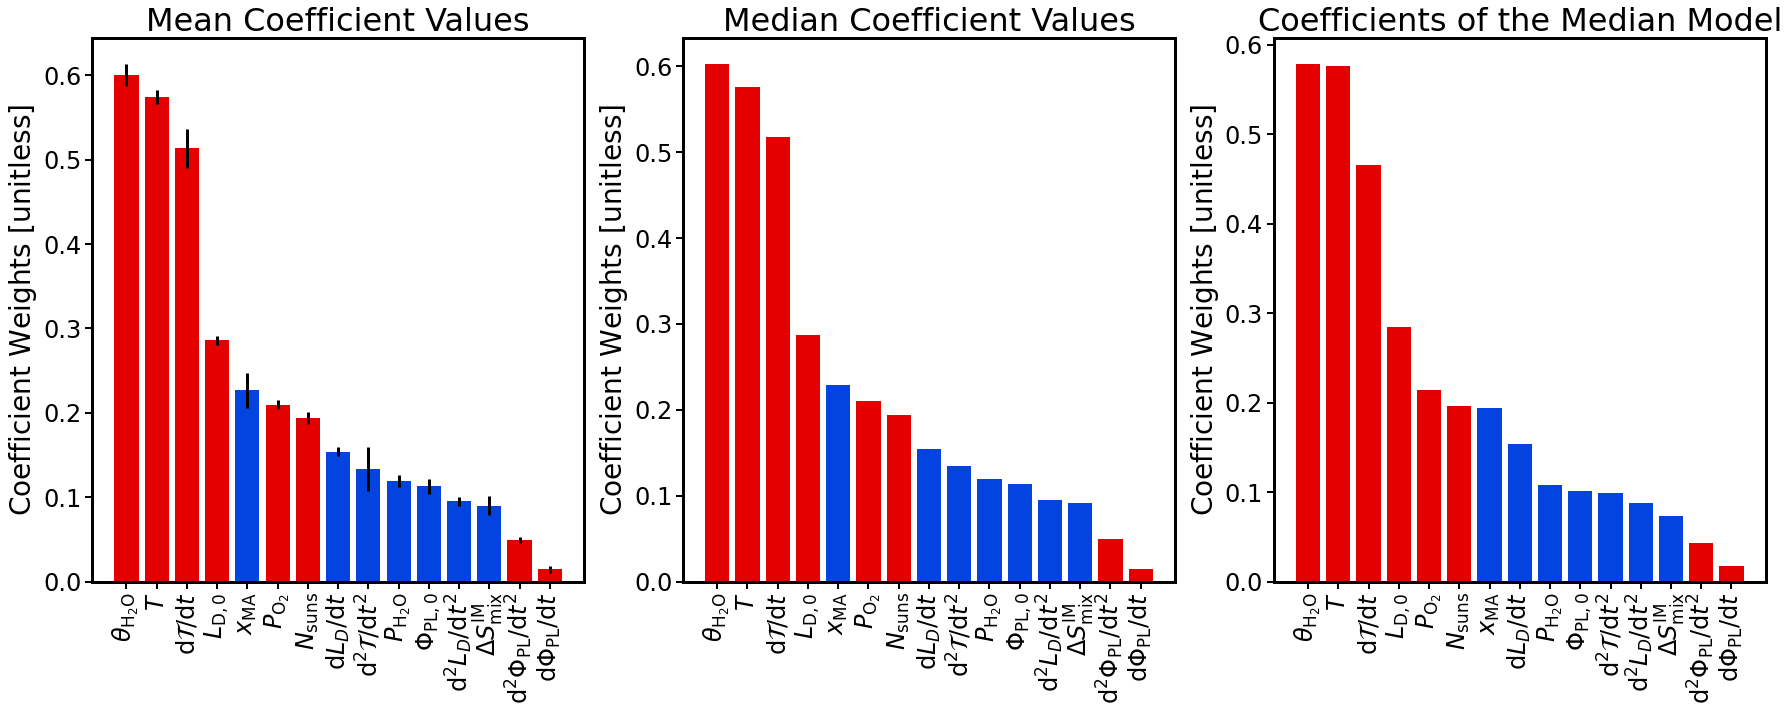

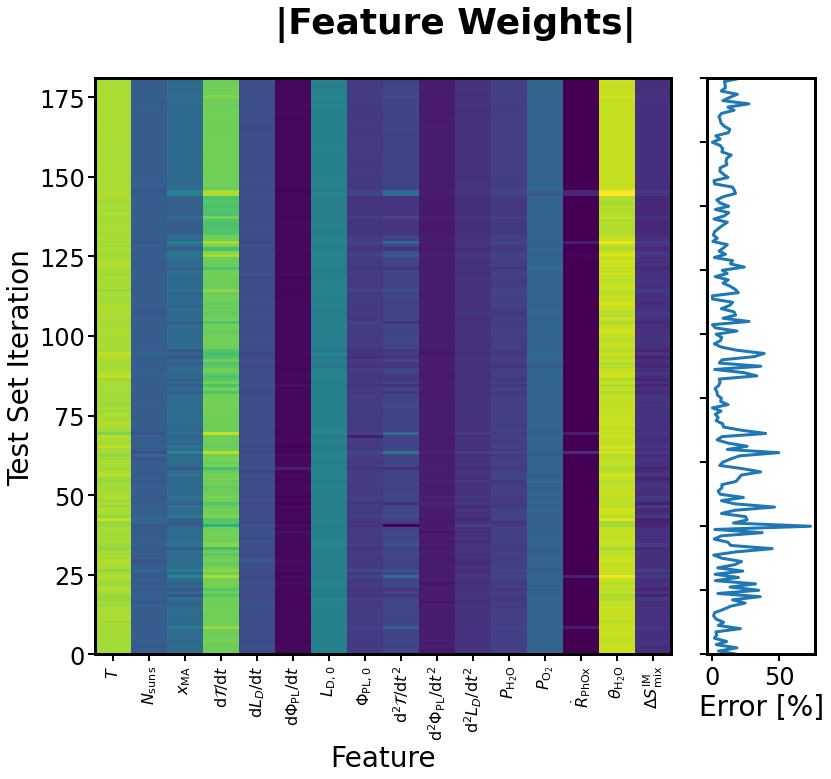

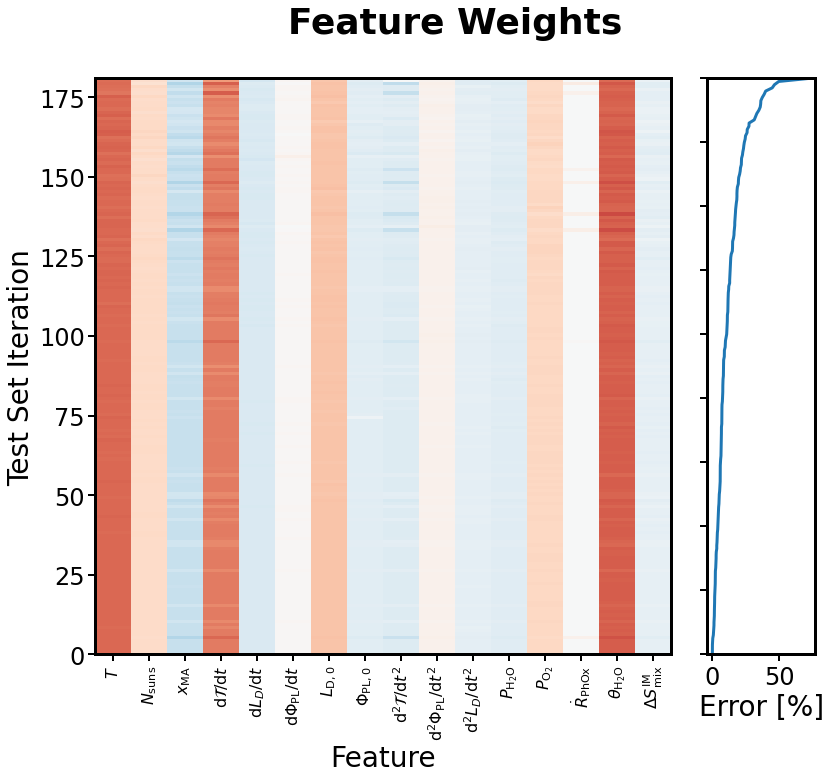

In [55]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# for making plots look nice:
# dictionary for conversion of ASCII feature labels to TeX-style labels
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'mu1':'$\mu_{t=1}$',
                     'mu2':'$\mu_{t=2}$',
                     'mu3':'$\mu_{t=3}$',
                     'mu4':'$\mu_{t=4}$',
                     'mu5':'$\mu_{t=5}$',
                     'tau1':'$\\tau_{t=1}$',
                     'tau2':'$\\tau_{t=2}$',
                     'tau3':'$\\tau_{t=3}$',
                     'tau4':'$\\tau_{t=4}$',
                     'tau5':'$\\tau_{t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'O2':'$\chi_\mathrm{O_2}$',
                     'RH':'$\mathrm{RH}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'dtdT':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)^{-1}$',
                     'dtdLD':'$(\mathrm{d}L_D/\mathrm{d}t)^{-1}$',
                     'dtdPL':'$(\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t)^{-1}$',
                     'd2tdT2':'$(\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2)^{-1}$',
                     'd2tdLD2':'$(\mathrm{d^2}L_D/\mathrm{d}t^2)^{-1}$',
                     'd2tdPL2':'$(\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2)^{-1}$',
                     'mu0':'$\mu_0$',
                     'tau0':'$\\tau_0$',
                     'ddtau0':'$\mathrm{d}^2\\tau/\mathrm{d}t^2$',
                     'ddmu0':'$\mathrm{d}^2\mu/\mathrm{d}t^2$',
                     'AB':'$T \mathrm{RH}$',
                     'AC':'$T \chi_\mathrm{O_2}$',
                     'AD':'$T N_\mathrm{suns}$',
                     'AE':'$T x_\mathrm{MA}}$',
                     'BC':'$\mathrm{RH} \chi_\mathrm{O_2}$',
                     'BD':'$\mathrm{RH} N_\mathrm{suns}$',
                     'BE':'$\mathrm{RH} x_\mathrm{MA}}$',
                     'CD':'$\chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'CE':'$\chi_\mathrm{O_2} x_\mathrm{MA}}$',
                     'DE':'$N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABC':'$T \mathrm{RH} \chi_\mathrm{O_2}$',
                     'ABD':'$T \mathrm{RH} N_\mathrm{suns}$',
                     'ABE':'$T \mathrm{RH} x_\mathrm{MA}$',
                     'ACD':'$T \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ACE':'$T \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ADE':'$T N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCD':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'BCE':'$\mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'BDE':'$\mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'CDE':'$\chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}}$',
                     'ABCD':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns}$',
                     'ABCE':'$T \mathrm{RH} \chi_\mathrm{O_2} x_\mathrm{MA}$',
                     'ABDE':'$T \mathrm{RH} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ACDE':'$T \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'BCDE':'$\mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'ABCDE':'$T \mathrm{RH} \chi_\mathrm{O_2} N_\mathrm{suns} x_\mathrm{MA}$',
                     'log_dTdt_full':'ln$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'dTrdt_full':'$(\mathrm{d}\mathcal{T}/\mathrm{d}t)_{5\%}$',
                     'Tr_LD80':'$\mathcal{T}_{L_\mathrm{D},80}$',
                     'lnPL80':'ln($\\tilde{\phi}_{L_\mathrm{D},80}$)',
                     'Opt_Tol':'$\mathcal{T}_{L_\mathrm{D},80}(x_\mathrm{MA})$'
                    }
# define list of nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(30,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    div_cmap = 'RdBu_r'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    div_cmap = 'RdBu'
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_df, cmap = div_cmap, vmin = -1, vmax = 1)
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map; this time sort everything by test error
fig2 = plt.figure(figsize=(10,10))

# augment the coeffs_df with an MAE column
coeffs_aug = coeffs_df.copy()
coeffs_aug['MAE'] = MAE_pct

# sort the runs by error
coeffs_aug = coeffs_aug.sort_values(by='MAE',axis=0,ascending=True)
MAE_sorted = coeffs_aug['MAE']
coeffs_aug = coeffs_aug.drop('MAE',axis=1)

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_aug.columns:
    fancy_labels.append(fancy_labels_dict[coeff])

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_aug, cmap = div_cmap, vmin = -1, vmax = 1)
ax1.set_xticks(np.arange(0.5, len(coeffs_aug.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_sorted,range(len(MAE_sorted)))
ax2.set_ylim([np.min(range(len(MAE_sorted))),np.max(range(len(MAE_sorted)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')

In [45]:
coeffs_aug

Temp     Nsuns   MA_frac     dTrdt     dLDdt  dPLdt  ddTr0     ddPL0  \
0  -0.679973 -0.152466  0.353821 -0.337041  0.207888   -0.0    0.0 -0.112291   
0  -0.679965 -0.152468  0.353815 -0.337204  0.207852   -0.0    0.0 -0.112299   
0  -0.680116 -0.152009  0.353815 -0.336890  0.207688   -0.0    0.0 -0.112311   
0  -0.675546 -0.151307  0.354001 -0.336607  0.207810   -0.0    0.0 -0.112059   
0  -0.679677 -0.151900  0.353424 -0.336785  0.207549   -0.0    0.0 -0.112199   
..       ...       ...       ...       ...       ...    ...    ...       ...   
0  -0.701820 -0.169492  0.353591 -0.301722  0.205353   -0.0   -0.0 -0.102719   
0  -0.686322 -0.113662  0.365176 -0.341132  0.179746   -0.0    0.0 -0.114712   
0  -0.682887 -0.154468  0.373623 -0.347869  0.186775   -0.0    0.0 -0.097922   
0  -0.664054 -0.121854  0.406959 -0.346009  0.246861   -0.0   -0.0 -0.103637   
0  -0.655811 -0.123172  0.336200 -0.295993  0.266364   -0.0    0.0 -0.097307   

       ddLD0    dtaudt     dmudt     ddmu0  ddtau0     P_H2O      P_O2  \
0   0.046189 -0.000000  0.205664  0.000000    -0.0  0.135272 -0.305676   
0   0.046196 -0.000000  0.205645  0.000000    -0.0  0.135260 -0.305697   
0   0.046070 -0.000000  0.205718  0.000000    -0.0  0.135307 -0.305621   
0   0.045914 -0.000000  0.205679  0.000000    -0.0  0.135098 -0.305443   
0   0.046402 -0.000000  0.205412  0.000000    -0.0  0.134305 -0.305674   
..       ...       ...       ...       ...     ...       ...       ...   
0   0.027627 -0.000000  0.206806  0.000000    -0.0  0.129755 -0.315471   
0   0.059030 -0.000000  0.198581  0.013300    -0.0  0.137560 -0.319582   
0   0.039919 -0.000000  0.215829  0.026042    -0.0  0.119511 -0.269419   
0   0.109771 -0.013527  0.182423  0.000000    -0.0  0.151505 -0.292271   
0   0.117841 -0.041885  0.175325  0.000000    -0.0  0.131169 -0.296413   

    PhotoOx_rate  Hydration_rate  delS_mix        MAE  
0      -0.000000       -0.390103  0.162820   0.124109  
0      -0.000000       -0.390008  0.162828   0.262515  
0      -0.000000       -0.390490  0.162785   0.443647  
0      -0.000000       -0.393018  0.161586   0.469788  
0      -0.000000       -0.391775  0.163801   0.658244  
..           ...             ...       ...        ...  
0      -0.000000       -0.397127  0.160376  49.510803  
0      -0.000000       -0.372610  0.160739  62.267581  
0      -0.000000       -0.408683  0.149094  65.820522  
0      -0.096739       -0.433727  0.152468  82.848510  
0       0.000000       -0.387662  0.155643  85.919500  

[132 rows x 19 columns]

# 8. Predictions Broken Down by Composition

Make a triptych of parity plots broken down by composition for the model with the median test set error. In these plots we do not distinguish between members of the training and test set.

## CAREFUL -- Note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

Text(2, 6, 'MAE = 14.92%')

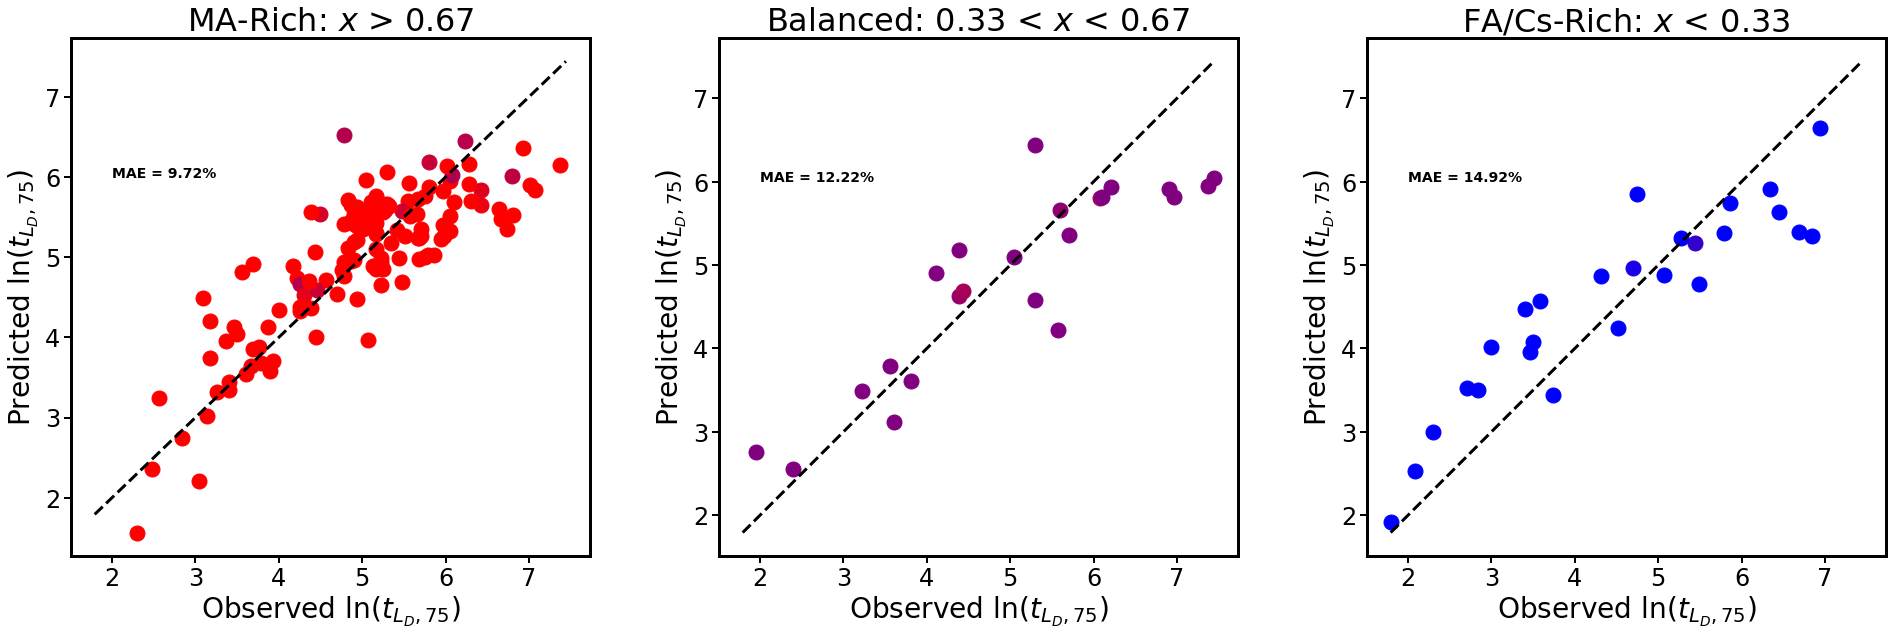

In [56]:
# Make fancy plots of composition

# define initial plot parameters
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# set up the plot axes - this is a more manual way than using plt.subplots(),
# but it ensures that all the axes are square
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge
ax0 = fig.add_axes([0 + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax1 = fig.add_axes([aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax2 = fig.add_axes([2*aspect_x + spacing*aspect_x,0, aspect_x*ax_size,ax_size])
ax = [ax0,ax1,ax2]

# where on the plot to put text
if response == 'tLD75 (min)' or response == 'tLD80 (min)' or response == 'tLD80 corrected (min)' or response == 'tLD75 corrected (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4

# format specifiers for text
textsize = 14
textweight = 'bold'
    
##### FIRST PANEL: Parity plot for MA-rich compositions

# initialize lists of observed and predicted values for MA-rich samples
MA_rich_act = []
MA_rich_pred = []

# loop over training set first
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_train.loc[idx])
        MA_rich_pred.append(ytpred[ii])
        ax[0].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0].set_title('MA-Rich: $x$ > 0.67')

# now plot the test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac > 0.67:
        MA_rich_act.append(y_whold.loc[idx])
        MA_rich_pred.append(ypred[ii])
        ax[0].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_rich_act = np.array(MA_rich_act) 
MA_rich_pred = np.array(MA_rich_pred) 
        
# stats calcs
MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100

# note the error on the plot
ax[0].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_rich_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### SECOND PANEL: Parity plot for balanced compositions

# initialize lists of observed and predicted 
MA_bal_act = []
MA_bal_pred = []

# loop over training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_train.loc[idx])
        MA_bal_pred.append(ytpred[ii])
        ax[1].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# make axis labels according to the appropriate response variable
if response == 'tLD75 (min)':
    ax[1].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[1].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[1].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[1].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[1].set_title('Balanced: 0.33 < $x$ < 0.67')

# loop over test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.67 and MA_frac > 0.33:
        MA_bal_act.append(y_whold.loc[idx])
        MA_bal_pred.append(ypred[ii])
        ax[1].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# convert lists to arrays to faciliate stats calcs
MA_bal_act = np.array(MA_bal_act) 
MA_bal_pred = np.array(MA_bal_pred) 
        
# stats calcs        
MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100

# put error on plot
ax[1].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_bal_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

##### THIRD PANEL: Parity plot for FACS-rich compositions

# initalize lists
MA_lean_act = []
MA_lean_pred = []

# training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_train.loc[idx])
        MA_lean_pred.append(ytpred[ii])
        ax[2].plot(y_train.loc[idx],ytpred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# plot perfect prediction line
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[2].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')

# set axis labels and title
if response == 'tLD75 (min)':
    ax[2].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[2].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[2].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[2].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[2].set_title('FA/Cs-Rich: $x$ < 0.33')

# test set
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    MA_frac = rawdata_df['MA fraction'][idx]
    if MA_frac < 0.33:
        MA_lean_act.append(y_whold.loc[idx])
        MA_lean_pred.append(ypred[ii])
        ax[2].plot(y_whold[idx],ypred[ii],color=(MA_frac,0,1-MA_frac),marker='o',markersize=15)

# lists -> arrays
MA_lean_act = np.array(MA_lean_act) 
MA_lean_pred = np.array(MA_lean_pred) 
        
# calculate and plot error
MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
ax[2].text(text_x,text_y,'MAE = ' + str(round(np.mean(MA_lean_MAE_pct),2)) + '%',weight=textweight,fontsize=textsize)

# Print figure title and panel labels if desired
#fig.suptitle('Early-Time Features', x=0.5, y=1, fontsize=48, weight='bold')
#fig.text(0,ax_size,'a',fontsize=36,weight='bold')
#fig.text(aspect_x,ax_size,'b',fontsize=36,weight='bold')
#fig.text(2*aspect_x,ax_size,'c',fontsize=36,weight='bold')

In [103]:
fa_data = rawdata_df.copy()[rawdata_df['MA fraction']==0]
fa_data['tLD80 (min)']

18       NaN
19      82.0
20       NaN
21      26.0
22      14.0
23     201.0
24       4.0
25       7.0
26     130.0
27      15.0
28      45.0
29      13.0
30     230.0
31     240.0
32      18.0
33       5.0
34       NaN
35     645.0
43     430.0
53     735.0
66     380.0
67     895.0
88     810.0
89      17.0
90      15.0
91       6.0
125     21.0
127     24.0
147      NaN
148     95.0
149     80.0
150    125.0
159      NaN
Name: tLD80 (min), dtype: float64

# 9. Predictions Broken Down by Environmental Conditions

Make a four-panel figure with a) coefficient weights of the median model, b) parity plot of the median model, c) test set error distribution, and d) symbol legend

## CAREFUL -- As in block (8), note that the variables corresponding to the median model were defined in block (6) above - if you insert any modeling blocks between that block and this one, this may change and you may not plot the median model!

IndexError: index 179 is out of bounds for axis 0 with size 179

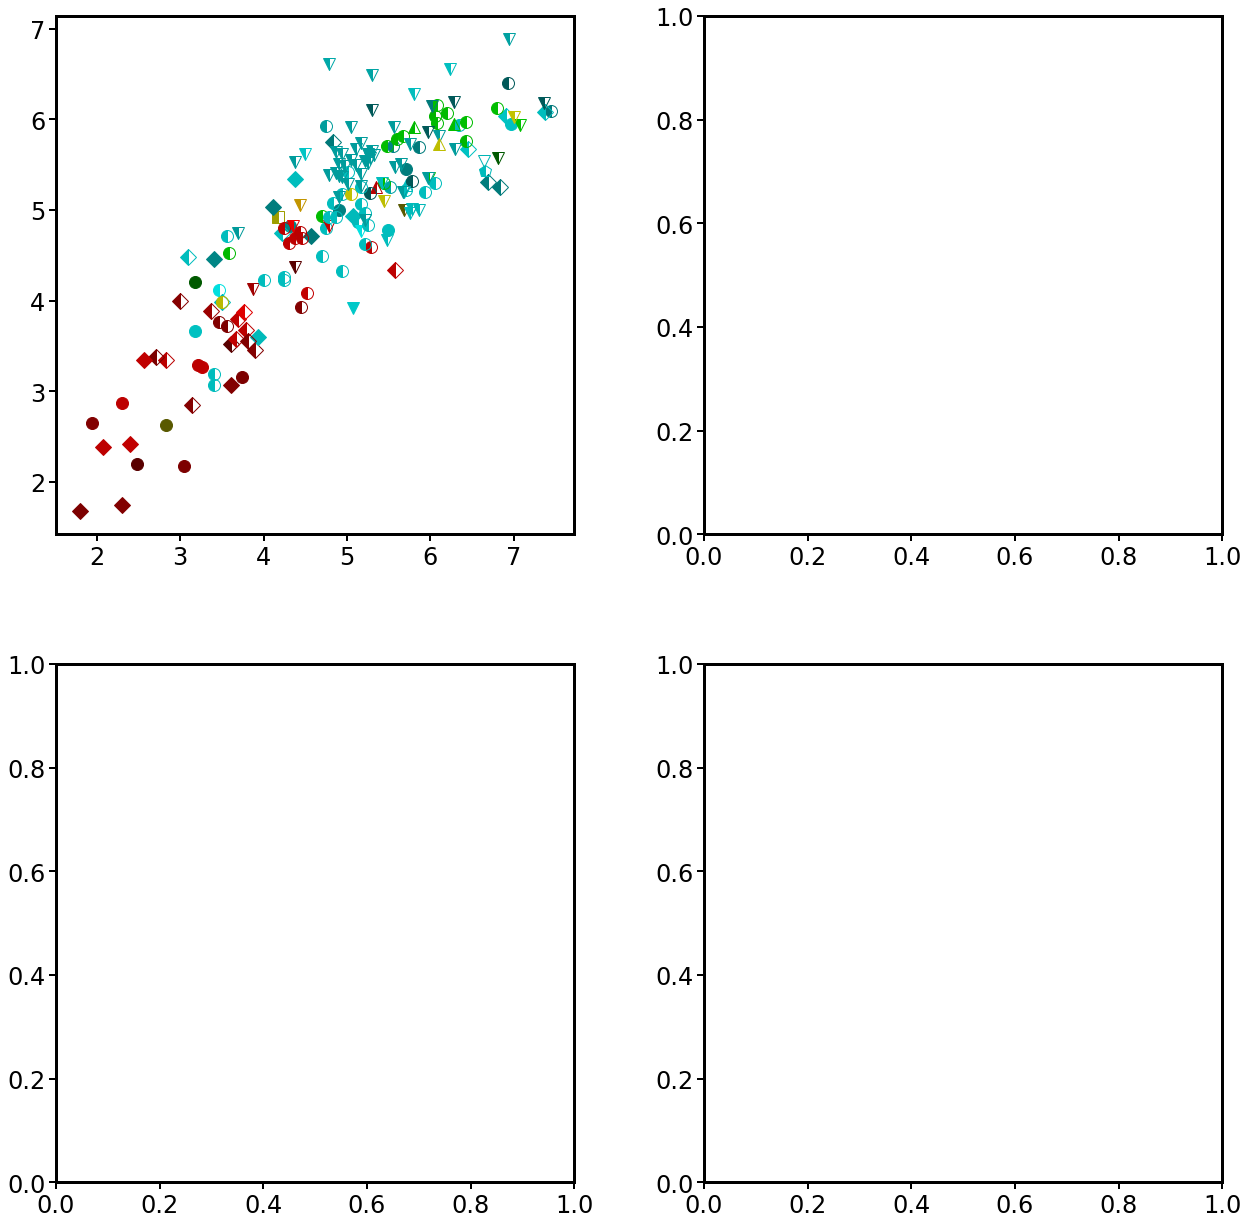

In [92]:
# Make fancy plots of test set error 

# Set up the subplot parameters - again we want square panels not square subplots, so we do things manually
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)



##### TOP LEFT: parity plot of median model
actual_all = []
preds_all = []
idxs_all = []

# plot training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    idxs_all.append(idx)
    ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=12)
    #ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker='o',fillstyle='full',linestyle=style,markersize=12)
    #ax[0][0].text(y_train.loc[idx],ytpred[ii],ii,fontsize=8)
# plot perfect prediction line and +/-50% error bounds (latter good for DOE presentations, bad for publications)
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

# set appropriate axis labels and title
if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
if 'tLD80' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,80}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,80}$)')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    idxs_all.append(idx)
    ax[0][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=8)
    #ax[0][0].plot(y_whold[idx],ypred[ii],color=batch_colors[rawdata_df['BatchID'][idx]],marker='o',fillstyle='full',linestyle=style,markersize=8)
    # test sample in orange
    ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

# plot legend for test sample
#if response == 'tLD75 (min)':
#    ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
#    ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
  
# calculate error metrics
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# set text position for the approporiate response variable
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    
##### TOP RIGHT: symbol legend
ax[0][1].axis('off') # no bounding box
ax[0][1].set_xlim([0,10]) # set grid for plotting symbols on
ax[0][1].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[0][1].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot temp legends
ax[0][1].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[0][1].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[0][1].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 0.5 suns: triangles
N_suns_stress = 0.5
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-8*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-12*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-16*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+ill_x*pitch,origin[1]-20*pitch/5,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot illumination legends
ax[0][1].text(origin[0]+(ill_x-0.2)*pitch,origin[1] + 0.9,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] + 0.33*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (4/5 - 0.33)*pitch,'0.5 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (8/5 - 0.33)*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (12/5 - 0.33)*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (16/5 - 0.33)*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+ill_x*pitch,origin[1] - (20/5 - 0.33)*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[0][1].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=15)

# plot O2 legends
ax[0][1].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[0][1].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[0][1].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')


##### BOTTOM LEFT: test set error distribution
ax[1][0].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[1][0].set_xlabel('Test Error [%]')
ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
              'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
              'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

##### BOTTOM RIGHT: coefficients of the median model

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[1][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[1][1].set_xticklabels(fancy_labels,rotation=90)
ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1][1].set_title('Coefficients of the Median Model')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
fig.text(0,0.95,'a',fontsize=36,weight='bold')
fig.text(0,0.45,'b',fontsize=36,weight='bold')
fig.text(0.5,0.45,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

viridis = cm.get_cmap('viridis', 256)
c_min = np.nanmin(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))
c_max = np.nanmax(np.log(rawdata_df['Bleach Rate (polyfit) (1/min)']))


d_fig, diag_ax = plt.subplots() # initialize axis for diagnostic plots
residuals = actual_all-preds_all

for ii in range(len(rawdata_df)):
    bleach_color = viridis((np.log(rawdata_df['Bleach Rate (polyfit) (1/min)'].iloc[ii]) - c_min)/(c_max-c_min)) 
    diag_ax.plot(actual_all[ii],residuals[ii],color='blue',marker='.',linestyle=' ')
    diag_ax.text(actual_all[ii],residuals[ii],idxs_all[ii],fontsize=8)
diag_ax.set_xlabel('Observed Value $y$')
diag_ax.set_ylabel('Residuals $y\ - \hat{y}$')

std_resids = (residuals-np.mean(residuals))/np.std(residuals)
# initialize axis for qq plot
new_fig = plt.figure()
import statsmodels.api as sm
sm.qqplot(std_resids,line='45')


# 10. Make a Big Figure 4

Plot the most sophisticated physics-inspired models, using leave-one-out testing in the top row and normal operating conditions testing in the bottom row.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 2 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48

##### TOP PANEL: parity plot for model with leave-one-out testing

# train the model
# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = n_trials-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E',
                 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]
    
    fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }
    
    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model',fontsize=title_size)
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=axis_lab_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

###### BOTTOM ROW: plot the model trained on accelerated testing conditions tested on normal operating conditions

# find indices in the mother dataframe corresponding to 1 sun test conditions,
# which we definte  as "normal operating conditions"
NOP_indices = rawdata_df[rawdata_df['Illum (Nsuns)'] == 1].index

# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = 1
#n_trials=5

# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e9)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y) - len(NOP_indices)- 1

# initialize error metrics for test set
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE = np.zeros(n_trials) # mean absolute error

# for the whole dataset
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# initialize a dataframe to keep track of model coefficients
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)

kk = 0

# Recalculate NOP indices based on which runs make it through the dropna() filter
NOP_indices = coded_df.loc[NOP_indices].dropna().index

# And do test-train split
X_whold = X.loc[NOP_indices].copy()
y_whold = Y.loc[NOP_indices].copy()
X_train = X.drop(index=NOP_indices).copy()
y_train = Y.drop(index=NOP_indices).copy()

# standardize the data according to the mean and variance of the training dataset
z_means = []
z_stds = []

for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    print(col_mean)
    z_means.append(col_mean)
    z_stds.append(col_std)
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold


# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

# make predictions on the test and training data
#ypred=final_model.predict(np.array(X_whold).reshape(1,-1)) # when test set is a single sample
ypred=final_model.predict(np.array(X_whold)) # when test set n > 1
ytpred=final_model.predict(X_train)

# calculate error metrics on test set
#RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
#R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold), ypred))
R2[kk] = metrics.r2_score(np.array(y_whold), ypred)
MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
MAE[kk] = np.mean(np.abs(y_whold-ypred))

# put the whole dataset back together (note that this will create arrays, not DFs)
y_net = np.concatenate([y_train,y_whold])
y_pred_net = np.concatenate([ytpred,ypred])

# calculate error metrics on entire set
R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

# calculate error metrics on training set
R2_train[kk] = metrics.r2_score(y_train, ytpred)
MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

# plot training data with markers corresponding to environmental + compositional conditions

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
ax[1][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = rawdata_df['Temp (deg C)'][idx]
    RH = rawdata_df['RH (%)'][idx]
    pct_O2 = rawdata_df['Oxygen (%)'][idx]
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = rawdata_df['MA fraction'][idx]
    ax[1][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=marker_size,fillstyle=fill,linestyle=style)
    ax[1][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=30,color='xkcd:orange')                

# save the model coefficients
coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

coeffs_df.rename(columns = new_dict, inplace = True)
try:
    coeffs_df.rename(columns = second_order_dict, inplace = True)
except:
    pass

coeffs = coeffs_df.columns

avgs = np.mean(coeffs_df)
error = np.std(coeffs_df)

bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

bars_df = pd.DataFrame(avgs)
bars_df = bars_df.rename(columns={0:'avgs'})
bars_df['coeffs'] = bars_df.index
bars_df['avgs'] = np.abs(bars_df['avgs'])
bars_df['error'] = error
bars_df['colors'] = bar_colors
bars_df = bars_df.sort_values(by = 'avgs', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['avgs'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['avgs'] > nz_bars_df['error']]

fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\\theta_\mathrm{H_2O}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhOx_rate_P':'$P_\mathrm{O_2}\mathrm{exp}N_\mathrm{suns}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                    }

fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    fancy_labels.append(fancy_labels_dict[coeff])
    
ax[1][1].bar(sig_bars_df['coeffs'],sig_bars_df['avgs'],yerr=sig_bars_df['error'],color=sig_bars_df['colors'])
ax[1][1].set_xticklabels(labels=fancy_labels,rotation=90,fontsize=axis_lab_size)

ax[1][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
ax[1][1].set_title('Model Coefficients',fontsize=title_size)

# plot the symbol legend
ax[1][2].axis('off') # no bounding box
ax[1][2].set_xlim([0,10]) # set grid for plotting symbols on
ax[1][2].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[1][2].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[1][2].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[1][2].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[1][2].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[1][2].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[1][2].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[1][2].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[1][2].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[1][2].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# row titles
fig.text(-0.02, 3/4, 'Leave-One-Out Testing', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/4, 'Normal Op. Cond. Testing', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,1/2-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,1/2-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,1/2-v_offset,'f',fontsize=60,weight='bold')

for i in range(2):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

In [ ]:
MAE_pct

# 11. Make a Large Figure 2 for the Paper

Here we want a high-level comparison of the predictions made by the models with and without the environmental features, linear features only.

In [ ]:
# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

axis_lab_size = 36
title_size=48
    
# set up the model

# first determine whether to do a log transform or not, then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset
n_trials = len(Y)


# set up search parameters for cross-validation, which will be used to select the hyperparameter
# range of hyperparameters to test
param_vals = np.logspace(-3,3,num=31)
parameters = {'alpha': param_vals}
# model to implement - LASSO, Ridge, etc.
model = Lasso(max_iter=1e8)
# scoring metric - MSE, R2, etc.
metric = 'neg_mean_squared_error'
# how many folds to do in k-fold cross-validation - 5 is standard
folds = len(Y)-1

# feature sets to test: currently use only early time and early time + linear
feature_sets = [
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5']
                ,
                ['dTrdt','dLDdt','dPLdt',
                 'ddTr0','ddLD0','ddPL0',
                 'Ld1','Ld2','Ld3','Ld4','Ld5',
                 'Tr1','Tr2','Tr3','Tr4','Tr5',
                 'PL1','PL2','PL3','PL4','PL5',
                 'A','P_H2O','P_O2','D','E']
                ,
                #['dTrdt','dLDdt','dPLdt',
                # 'ddTr0','ddLD0','ddPL0',
                # 'Ld1','Ld2','Ld3','Ld4','Ld5',
                # 'Tr1','Tr2','Tr3','Tr4','Tr5',
                # 'PL1','PL2','PL3','PL4','PL5',
                # 'A','P_H2O','P_O2','D','E',
                # 'PhotoOx_rate','Hydration_rate','delS_mix',]
                ]

# define metrics to keep track of for each feature set
performance_metrics = ['Mean Test Set Error (%)','Median Test Set Error (%)','Std Dev Test Set Error (%)',
                       'Mean Test Set Error','Median Test Set Error','Std Dev Test Set Error',
                       'Mean Training Set Error (%)','Median Training Set Error (%)','Std Dev Training Set Error (%)',
                       'Mean Training Set Error','Median Training Set Error','Std Dev Training Set Error',
                       'Mean Full Set Error (%)','Median Full Set Error (%)','Std Dev Full Set Error (%)',
                       'Mean Full Set Error','Median Full Set Error','Std Dev Full Set Error',
                       'Mean Training Set R2', 'Median Training Set R2','Std Dev Training Set R2',
                       'MA-Rich Error (%)','Balanced Error (%)','FACs-Rich Error (%)',
                       'MA-Rich R2 (%)','Balanced R2 (%)','FACs-Rich R2 (%)',
                      ]
performance_metalist = []

# keep track of coefficients
coeffs_DFs = []

# Loop over model echelons
for j, echelon in enumerate(feature_sets):
    
    # initialize the list of error/performance metrics
    performance_list = []
    
    X = coded_df.drop(columns=response).copy()
    X = X[echelon]
    
    # initialize error metrics for test set
    R2 = np.zeros(n_trials) # coefficient of determination
    RMSE = np.zeros(n_trials) # RMS error
    MAE_pct = np.zeros(n_trials) # mean absolute error, percent
    MAE = np.zeros(n_trials) # mean absolute error

    # for the whole dataset
    MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
    MAE_overall = np.zeros(n_trials) # mean absolute error, percent
    R2_overall = np.zeros(n_trials) # coefficient of determination

    # for the training set
    MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
    MAE_train = np.zeros(n_trials) # mean absolute error, percent
    R2_train = np.zeros(n_trials) # coefficient of determination

    # error on linear scale
    linear_error = np.zeros(n_trials)

    # initialize a dataframe to keep track of model coefficients
    coeffs_df = pd.DataFrame(columns=X.columns)

    # Loop over test sets
    for kk in range(n_trials):
    
    
        # Partition the TT split
        X_whold = X.iloc[kk].copy()
        y_whold = Y.iloc[kk:kk+1].copy()
        X_train = X.drop(X.index[kk]).copy()
        y_train = Y.drop(X.index[kk]).copy()

        # standardize the data according to the mean and variance of the training dataset
        for col in X_train.columns:
            # get mean and variance of features in the test set
            col_mean = np.mean(X_train[col])
            col_std = np.std(X_train[col])
            # standardize the features in the training set
            z_train = (X_train[col] - col_mean)/col_std
            X_train[col] = z_train
            # standardize the features in the test set
            z_whold = (X_whold[col] - col_mean)/col_std
            X_whold[col] = z_whold

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_train,y_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # and retrain the final model on the full training set
        final_model = Lasso(alpha=alpha)
        final_model.fit(X_train,y_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)

        # calculate error metrics on test set
        RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
        R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
        MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
        MAE[kk] = np.mean(np.abs(y_whold-ypred))

        # put the whole dataset back together (note that this will create arrays, not DFs)
        y_net = np.concatenate([y_train,y_whold])
        y_pred_net = np.concatenate([ytpred,ypred])

        # calculate error metrics on entire set
        R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
        MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
        MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)

        # calculate error metrics on training set
        R2_train[kk] = metrics.r2_score(y_train, ytpred)
        MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
        MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)

        linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100

    
        # save the model coefficients
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))
        
        # Save coefficients and error metrics
        
    # append performance metrics for the test set
    performance_list.append(np.mean(MAE_pct))
    performance_list.append(np.median(MAE_pct))
    performance_list.append(np.std(MAE_pct))
    performance_list.append(np.mean(MAE))
    performance_list.append(np.median(MAE))
    performance_list.append(np.std(MAE))
    # append performance metrics for the training set
    performance_list.append(np.mean(MAE_pct_train))
    performance_list.append(np.median(MAE_pct_train))
    performance_list.append(np.std(MAE_pct_train))    
    performance_list.append(np.mean(MAE_train))
    performance_list.append(np.median(MAE_train))
    performance_list.append(np.std(MAE_train))
    # append performance metrics for the full set
    performance_list.append(np.mean(MAE_pct_overall))
    performance_list.append(np.median(MAE_pct_overall))
    performance_list.append(np.std(MAE_pct_overall))
    performance_list.append(np.mean(MAE_overall))
    performance_list.append(np.median(MAE_overall))
    performance_list.append(np.std(MAE_overall))
    # append training set R2
    performance_list.append(np.mean(R2_train))
    performance_list.append(np.median(R2_train))
    performance_list.append(np.std(R2_train))
    
    # append dataframe of coefficients
    coeffs_DFs.append(coeffs_df)
        
    # Find the median model and train it
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    print(idx)
    
    kk = idx
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()

    # standardize the data according to the mean and variance of the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold

    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)

    # print winning HP value if desired...
    #print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']

    # and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)

    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)
    
    # save the model coefficients
    coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=X.columns))    
    
    # convert labels "A", "B", etc. back to physically meaningful names
    new_dict = {
        "A":"Temp",
        "B":"RH",
        'C':'O2',
        'D':'Nsuns',
        'E':'MA_frac'
    }
    coeffs_df.rename(columns = new_dict, inplace = True)

    coeffs = coeffs_df.columns # save coefficient names
    
    # Plot the median model, indexed by composition, in the left panel
    # ax[ii][0].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_train.loc[idx],ytpred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[2][j+1].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # label the plot
    ax[2][j+1].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[2][j+1].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    if j == 0 and i != 2:
        ax[0][j].set_title('Model with Median Performance',fontsize=title_size)
    
    # set axis limits
    ax[2][j+1].set_xlim([0.5,8])
    ax[2][j+1].set_ylim([0.5,8])

    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[2][j+1].plot(y_whold[idx],ypred[ii],color=MA_cmp(MA_frac),marker='o',markersize=15)
    
    # calculate the error metrics on the MA-rich data
    MA_rich_act = []
    MA_rich_pred = []
    
    # scan over training set...
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_train.loc[idx])
            MA_rich_pred.append(ytpred[ii])

    # ...and over test set
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac > 0.66:
            MA_rich_act.append(y_whold.loc[idx])
            MA_rich_pred.append(ypred[ii])
    
    # calculate error and append to list
    MA_rich_act = np.array(MA_rich_act) 
    MA_rich_pred = np.array(MA_rich_pred) 
    MA_rich_R2 = r2_score(MA_rich_act,MA_rich_pred)
    MA_rich_MAE_pct = np.abs((MA_rich_pred - MA_rich_act)/MA_rich_act)*100
    performance_list.append(np.mean(MA_rich_MAE_pct))
    
    # do the same for the balanced MA 
    MA_bal_act = []
    MA_bal_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_train.loc[idx])
            MA_bal_pred.append(ytpred[ii])
            
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.66 and MA_frac > 0.33:
            MA_bal_act.append(y_whold.loc[idx])
            MA_bal_pred.append(ypred[ii])
   
    MA_bal_act = np.array(MA_bal_act) 
    MA_bal_pred = np.array(MA_bal_pred) 
    MA_bal_R2 = r2_score(MA_bal_act,MA_bal_pred)
    MA_bal_MAE_pct = np.abs((MA_bal_pred - MA_bal_act)/MA_bal_act)*100
    performance_list.append(np.mean(MA_bal_MAE_pct))
    
    # and the FA/Cs rich compositions
    MA_lean_act = []
    MA_lean_pred = []

    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_train.loc[idx])
            MA_lean_pred.append(ytpred[ii])

    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        MA_frac = rawdata_df['MA fraction'][idx]
        if MA_frac < 0.33:
            MA_lean_act.append(y_whold.loc[idx])
            MA_lean_pred.append(ypred[ii])
            
    MA_lean_act = np.array(MA_lean_act) 
    MA_lean_pred = np.array(MA_lean_pred) 
    MA_lean_R2 = r2_score(MA_lean_act,MA_lean_pred)
    MA_lean_MAE_pct = np.abs((MA_lean_pred - MA_lean_act)/MA_lean_act)*100
    performance_list.append(np.mean(MA_lean_MAE_pct))
    
    # append the composition-subdivided R2 scores too
    performance_list.append(MA_rich_R2)
    performance_list.append(MA_bal_R2)
    performance_list.append(MA_lean_R2)
    
    # append the list of error and performance metrics to the meta-list
    performance_metalist.append(performance_list)
    
    # Plot the median model's coefficients in the middle panel
    # ax[j][1].plot(...)
    # identify the index corresponding to the median model
    idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
    med_idx = idx # save the median index in a less ambiguous form
    coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

    # assign bar colors to coefficient values
    bar_colors_med_model = []
    if response == 'Bleach Rate (fit to 5% inc) (1/min)':
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:red')
            else:
                bar_colors_med_model.append('xkcd:blue')
    else:
        for jj in range(len(coeffs_med_model)):
            if np.sign(coeffs_med_model[jj]) == 1:
                bar_colors_med_model.append('xkcd:blue')
            else:
                bar_colors_med_model.append('xkcd:red')

    # make a DataFrame for bar plotting of the median model's coefficients
    med_model_bars_df = pd.DataFrame(coeffs_med_model) 
    med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
    med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
    med_model_bars_df.index = coeffs_df.columns # make the DF indices equal to the coefficient names
    med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
    med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
    med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

    # identify the nonzero coefficients
    sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

    # redefine the fancy coefficients
    fancy_labels=[]
    for coeff in sig_bars_med_model['coeffs']:
        fancy_labels.append(fancy_labels_dict[coeff])

    # and make the plot
    ax[j][1].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
    ax[j][1].set_xticklabels(fancy_labels,rotation=90,fontsize=axis_lab_size)
    ax[j][1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$',fontsize=axis_lab_size)
    ax[j][1].set_title('Coefficients of the Median Model')
    
    # Plot the test set error histogram in the right panel
    # ax[j][2].hist(...)
    ax[j][2].hist(MAE_pct,color='xkcd:cerulean',alpha=0.8,edgecolor='black',histtype='bar')
    ax[j][2].set_xlabel('Mean Test Error [%]',fontsize=title_size)
    ax[j][2].set_ylabel('Frequency',fontsize=axis_lab_size)
    ax[j][2].set_title('Histogram of Testing Error',fontsize=title_size)
    ax[j][2].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
    ax[j][2].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
                  'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top',fontsize=40)
    ax[j][2].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
                  'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top',fontsize=40)

    # Plot the median model, indexed by environment, in the bottom row
    # ax[2][j].plot(...)
    for ii in range(len(y_train)):
        idx = y_train.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

    # plot perfect prediction line and +/-50% error bounds
    plotRange = np.linspace(1,7.5,num=101)
    ax[j][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
    #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
    
    # set axis labels
    ax[j][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    ax[j][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=axis_lab_size)
    
    # set axis limits
    ax[j][0].set_xlim([0.5,8])
    ax[j][0].set_ylim([0.5,8])
    
    # plot legend for test sample
    ax[j][0].plot(4,1.5,marker='*',markersize=30,color='xkcd:orange')
    ax[j][0].text(4.2,1.48,'Test Sample',fontsize=40,weight='bold',color='xkcd:orange',va='center')
    
    # set title depending on iteration



    # plot test data as above
    for ii in range(len(y_whold)):
        idx = y_whold.index[ii]
        T = rawdata_df['Temp (deg C)'][idx]
        RH = rawdata_df['RH (%)'][idx]
        pct_O2 = rawdata_df['Oxygen (%)'][idx]
        N_suns_stress = rawdata_df['Illum (Nsuns)'][idx]
        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
        MA_frac = rawdata_df['MA fraction'][idx]
        ax[j][0].plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)
        ax[j][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=marker_size,color='xkcd:orange')

        
ax[2][1].set_title('Early-Time Features',fontsize=title_size)
ax[2][2].set_title('Early-Time + Env\'t + Comp. Features',fontsize=title_size)

# plot the symbol legend
ax[2][0].axis('off') # no bounding box
ax[2][0].set_xlim([0,10]) # set grid for plotting symbols on
ax[2][0].set_ylim([0,10]) 

origin = (1,7) # corner to start plotting from
pitch = 1.5 # spacing between symbols

# plot temperature/humidity symbols, defined by color
pct_O2 = 21
N_suns_stress = 8
for ii in range(4): # iterate over 4 temps
    for jj in range(5): # iterate over 5 RHs
        T = 25 + ii*20
        RH = jj*20

        color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)

        ax[2][0].plot(origin[0]+ii*pitch,origin[1]-jj*pitch,color=color,marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot temp legends
ax[2][0].text(origin[0],origin[1]+0.5*pitch,'25 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+pitch,origin[1]+0.5*pitch,'45 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+2*pitch,origin[1]+0.5*pitch,'65 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+3*pitch,origin[1]+0.5*pitch,'85 $\degree$C',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+1.5*pitch,origin[1]+pitch,'Temperature',fontsize=25,ha='center',va='center')

# plot RH legends
ax[2][0].text(origin[0]-0.25*pitch,origin[1],'0%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-pitch,'20%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-2*pitch,'40%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-3*pitch,'60%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-0.25*pitch,origin[1]-4*pitch,'80%',fontsize=20,ha='right',va='center')
ax[2][0].text(origin[0]-1.125*pitch,origin[1]-2*pitch,'Relative Humidity',fontsize=25,ha='center',va='center',rotation=90)

# plot illumination symbols, defined by shape
T = 25
RH = 60

ill_x = 4 # how many pitches "east" of the origin to plot illumination symbols

# dark: pentagons
N_suns_stress = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1],color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 1 sun: inverted triangles
N_suns_stress = 1
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 8 suns: circles
N_suns_stress = 8
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 16 suns: squares
N_suns_stress = 16
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# 32 suns: diamonds
N_suns_stress = 32
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+ill_x*pitch,origin[1]-4*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot illumination legends
ax[2][0].text(origin[0]+(ill_x-0.2)*pitch,origin[1]+1.25,'Illumination',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]+0.5*pitch,'0 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-0.5*pitch,'1 sun',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-1.5*pitch,'8 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-2.5*pitch,'16 suns',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+ill_x*pitch,origin[1]-3.5*pitch,'32 suns',fontsize=20,ha='center',va='center')

# plot atmosphere symbols, defined by fill
atm_x = 5 # how many pitches "east" of orign to plot atmosphere symbols

N_suns_stress = 8

# N2: open symbols
pct_O2 = 0
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][2].plot(origin[0]+atm_x*pitch,origin[1]-1*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# air: half-filled symbols
pct_O2 = 21
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-2*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# O2: filled symbols
pct_O2 = 100
color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
ax[2][0].plot(origin[0]+atm_x*pitch,origin[1]-3*pitch,color='k',marker=marker,fillstyle=fill,linestyle=style,markersize=marker_size)

# plot O2 legends
ax[2][0].text(origin[0]+(atm_x-0.2)*pitch,origin[1],'Atmosphere',rotation=45,fontsize=25,va='bottom')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-0.5*pitch,'N$_2$',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-1.5*pitch,'Air',fontsize=20,ha='center',va='center')
ax[2][0].text(origin[0]+atm_x*pitch,origin[1]-2.5*pitch,'O$_2$',fontsize=20,ha='center',va='center')

# set full legend title
ax[2][0].text(origin[0]+2.5*pitch,origin[1]+1.75*pitch,'Symbol Legend',fontsize=32,ha='center',weight='bold')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')

##### FINAL FIGURE ANNOTATIONS

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# panel labels
v_offset = 0.02
fig.text(0,1-v_offset,'a',fontsize=60,weight='bold')
fig.text(1/3,1-v_offset,'b',fontsize=60,weight='bold')
fig.text(2/3,1-v_offset,'c',fontsize=60,weight='bold')
fig.text(0,2/3-v_offset,'d',fontsize=60,weight='bold')
fig.text(1/3,2/3-v_offset,'e',fontsize=60,weight='bold')
fig.text(2/3,2/3-v_offset,'f',fontsize=60,weight='bold')
fig.text(0,1/3-v_offset,'g',fontsize=60,weight='bold')
fig.text(1/3,1/3-v_offset,'h',fontsize=60,weight='bold')
fig.text(2/3,1/3-v_offset,'i',fontsize=60,weight='bold')

# add colorbars to composition color plots

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)



####### NEW FIGURE: #######


# Make some plots of model performance statistics
echelons = ['Early-Time','+Linear Envt.','+Physics-Inspired']
performance_DF = pd.DataFrame(performance_metalist,columns=performance_metrics,index=echelons[:2])

fig2, ax2 = plt.subplots(1,2,figsize=(20,9.5))

# left panel: error broken down by composition
ax2[0].plot(performance_DF.index,performance_DF['MA-Rich Error (%)'],'s--',color=(1,0,0),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['Balanced Error (%)'],'s--',color=(0.5,0,0.5),markersize=12)
ax2[0].plot(performance_DF.index,performance_DF['FACs-Rich Error (%)'],'s--',color=(0,0,1),markersize=12)
ax2[0].set_ylabel('Mean Error (%)',fontsize=14)
ax2[0].tick_params(axis='x', rotation=45)
ax2[0].set_title('Evolution of Composition Parity',fontsize=24)
ax2[0].legend(['MA-Rich','Balanced','MA-Lean'],fontsize=20,loc='upper right',frameon=False)

# right panel: test and training set error
ax2[1].plot(performance_DF.index,performance_DF['Mean Test Set Error (%)'],'^-',color=(0,0.5,1),markersize=12)
ax2[1].plot(performance_DF.index,performance_DF['Mean Training Set Error (%)'],'^--',color=(0,0.5,1),markersize=12)
ax2[1].set_ylabel('Mean Error (%)',color=(0,0.5,1),fontsize=16)
ax2[1].tick_params(axis='y', labelcolor=(0,0.5,1))
ax2[1].tick_params(axis='x', rotation=45)
ax2[1].set_title('Evolution of Overall Performance ',fontsize=24)
ax2[1].legend(['Test Set','Training Set'],fontsize=20,loc='upper center',frameon=False)
# also training set R2
#ax_21 = ax2[1].twinx()
#ax_21.plot(performance_DF.index,performance_DF['Mean Training Set R2'],'^--',color=(1,0,0),markersize=12)
#ax_21.set_ylabel('Training Set $R^2$',color=(1,0,0))
#ax_21.tick_params(axis='y', labelcolor=(1,0,0))


In [ ]:
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 3 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 
    
# Global size to use for figure markers
marker_size = 25

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.46
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

# colorbar position and dimensions, in figure coordinates 
cb_xpos = 0.80
cb_ypos = 0.06
cb_dx = 0.14
cb_dy = 0.01

cb = fig.add_axes([cb_xpos,cb_ypos,cb_dx,cb_dy])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cb.imshow(gradient, aspect='auto', cmap=MA_cmp)
cb.set_yticks([])
cb.set_xticks([])
cb.set_title('$x$')
fig.text(cb_xpos,cb_ypos-0.005,'FA$_{0.83}$Cs$_{0.17}$PbI$_3$',color=MA_cmp(0), ha='center',va='top',fontsize=28)
fig.text(cb_xpos+cb_dx,cb_ypos-0.005,'MAPbI$_3$',color=MA_cmp(1.0), ha='center',va='top',fontsize=28)

for i in range(3):
    for j in range (3):
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)

ax[1][0].set_xlabel('Observed ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_ylabel('Predicted ln($t_{L_D,75}$)',fontsize=36)
ax[1][0].set_title('+Linear Env\'t and Comp.',fontsize=48)

# row titles
fig.text(-0.02, 5/6, 'Early-Time Features Only', fontsize=48, rotation=90, ha='center', va='center')
fig.text(-0.02, 1/2, '+ Linear Env\'t and Comp. Features', fontsize=48, rotation=90, ha='center', va='center')

# 12. Adsorption Calculations 

Text(0.8, 2.2, 'Guo et al.')

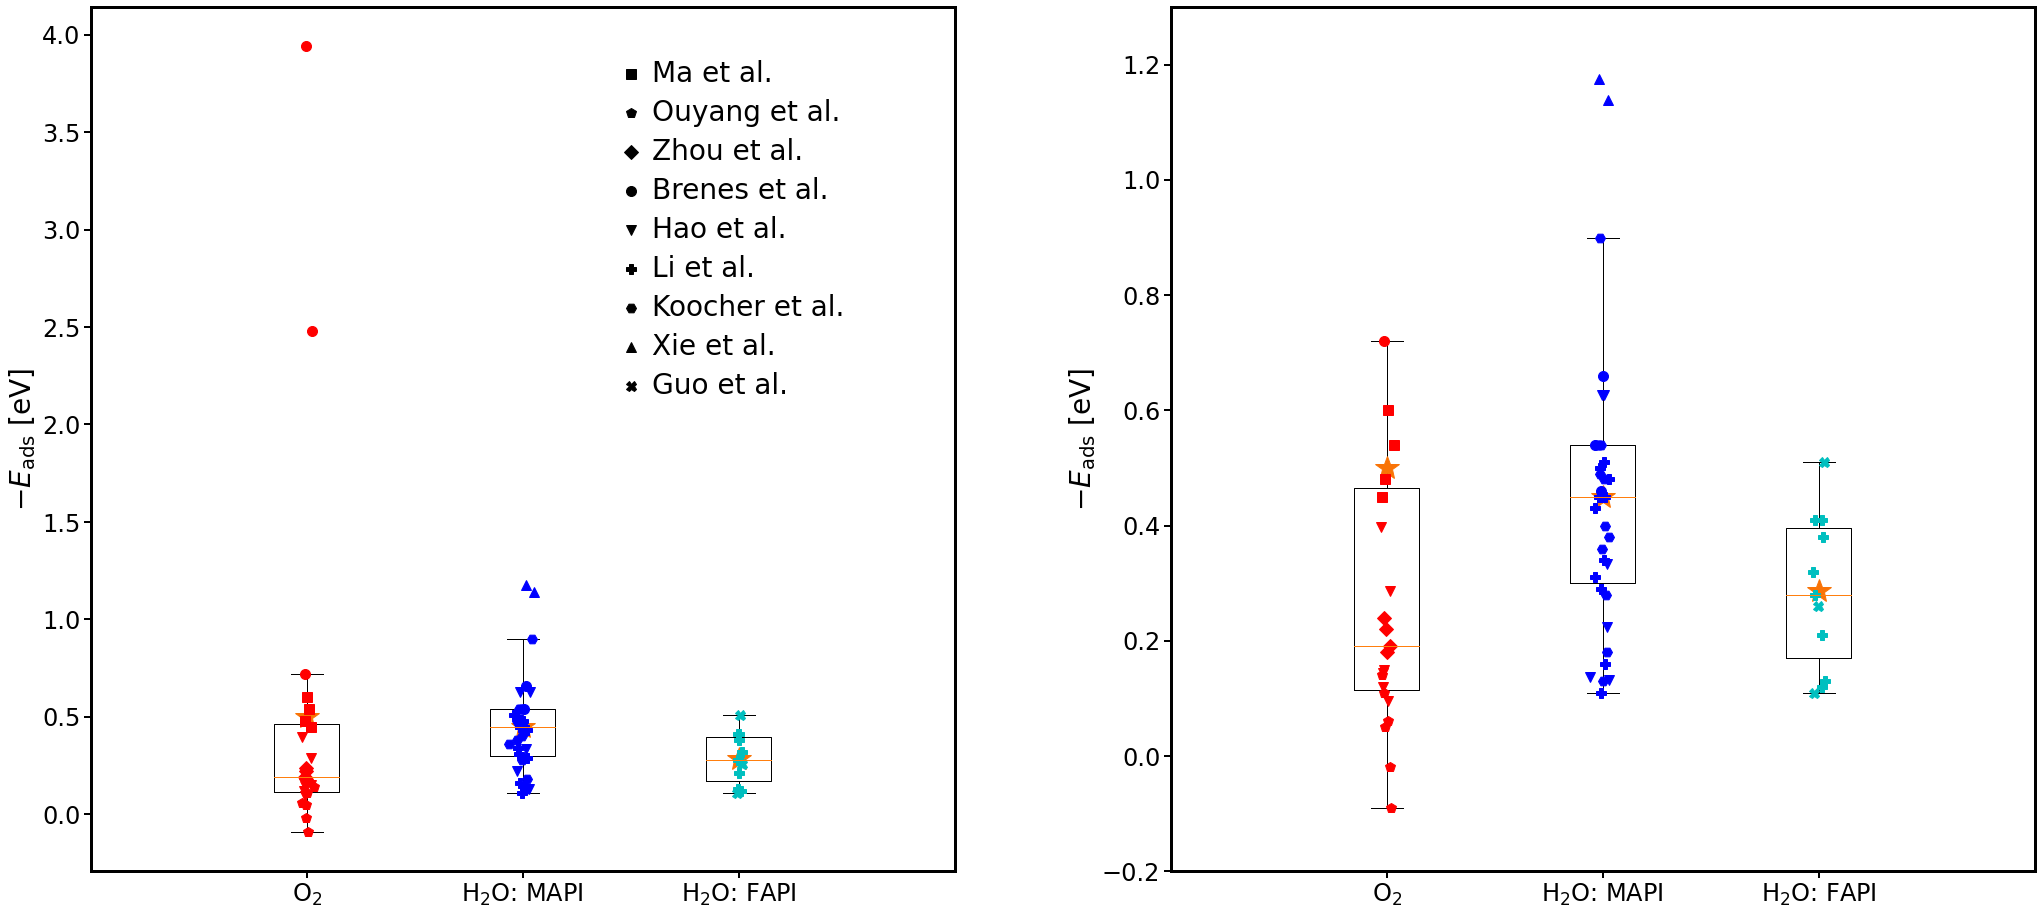

In [2]:
import random

O2_Ma = [-0.45,-0.48,-0.6,-0.54]
O2_Ouyang = [-0.14,-0.06,-0.11,-0.05,0.02,0.09]
O2_Zhou = [-0.19,-0.22,-0.24,-0.18]
O2_Brenes = [-3.94,-2.48,-0.72]
O2_Hao = [-0.398,-0.096,-0.12,-0.144,-0.15,-0.287]

O2_all = np.array(O2_Ma + O2_Ouyang + O2_Zhou + O2_Brenes + O2_Hao)

H2O_MAPI_Li = [-0.48,-0.34,-0.45,-0.45,-0.31,-0.45,-0.16,-0.11,-0.29,-0.51,-0.43,-0.5]
H2O_MAPI_Koocher = [-0.49,-0.36,-0.48,-0.4,-0.38,-0.9,-0.18,-0.13,-0.28,-0.54,-0.54,-0.54]
H2O_MAPI_Brenes = [-0.66,-0.46,-0.54]
H2O_MAPI_Hao = [-0.627,-0.627,-0.224,-0.137,-0.131,-0.333,]
H2O_MAPI_Xie = [-1.17594,-1.13924]

H2O_MAPI_all = np.array(H2O_MAPI_Li + H2O_MAPI_Koocher + H2O_MAPI_Brenes + H2O_MAPI_Hao + H2O_MAPI_Xie)

H2O_FAPI_Li = [-0.12,-0.21,-0.28,-0.32,-0.41,-0.38,-0.13,-0.41]
H2O_FAPI_Guo = [-0.26,-0.51,-0.11]

H2O_FAPI_all = np.array(H2O_FAPI_Li + H2O_FAPI_Guo)


# Start by initializing the figure: 3 x 3 square panels
panel_size = 15 # absolute size of a single panel, inches(?)
n_plots_x = 2 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_y):
    row_panel_list = []
    for jj in range(n_plots_x):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list) 

ax[0][0].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])
ax[0][1].boxplot([-O2_all,-H2O_MAPI_all,-H2O_FAPI_all],labels=['O$_2$','H$_2$O: MAPI','H$_2$O: FAPI'],showfliers=False,positions=[0,0.5,1])

def jittery_vector(length,noise_mean,noise_std):
    
    vector = np.zeros(length)
    for i in range(length):
        vector[i] += random.gauss(noise_mean,noise_std)
    
    return vector


ax[0][0].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][0].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][0].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][0].plot(1,np.mean(-H2O_FAPI_all),'c*',markersize=25,color='xkcd:orange')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][0].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][0].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][1].plot(0,np.mean(-O2_all),'r*',markersize=25,color='xkcd:orange')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ma)),0,0.01),-np.array(O2_Ma),
         color='r',marker='s',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Ouyang)),0,0.01),-np.array(O2_Ouyang),
         color='r',marker='p',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Zhou)),0,0.01),-np.array(O2_Zhou),
         color='r',marker='D',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Brenes)),0,0.01),-np.array(O2_Brenes),
         color='r',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(jittery_vector(len(np.array(O2_Hao)),0,0.01),-np.array(O2_Hao),
         color='r',marker='v',markersize=10,linestyle=' ')

ax[0][1].plot(0.5,np.mean(-H2O_MAPI_all),'b*',markersize=25,color='xkcd:orange')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Li)),0,0.01),-np.array(H2O_MAPI_Li),
         color='b',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Koocher)),0,0.01),-np.array(H2O_MAPI_Koocher),
         color='b',marker='H',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Brenes)),0,0.01),-np.array(H2O_MAPI_Brenes),
         color='b',marker='o',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Hao)),0,0.01),-np.array(H2O_MAPI_Hao),
         color='b',marker='v',markersize=10,linestyle=' ')
ax[0][1].plot(0.5+jittery_vector(len(np.array(H2O_MAPI_Xie)),0,0.01),-np.array(H2O_MAPI_Xie),
         color='b',marker='^',markersize=10,linestyle=' ')

ax[0][1].plot(1,np.mean(-H2O_FAPI_all),'*',markersize=25,color='xkcd:orange')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Li)),0,0.01),-np.array(H2O_FAPI_Li),
         color='c',marker='P',markersize=10,linestyle=' ')
ax[0][1].plot(1+jittery_vector(len(np.array(H2O_FAPI_Guo)),0,0.01),-np.array(H2O_FAPI_Guo),
         color='c',marker='X',markersize=10,linestyle=' ')

ax[0][1].set_ylim([-0.2,1.3])
ax[0][1].set_ylabel('$-E_\mathrm{ads}$ [eV]')

ax[0][0].plot(0.75,3.8,color='k',marker='s',markersize=10)
ax[0][0].text(0.8,3.8,'Ma et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.6,color='k',marker='p',markersize=10)
ax[0][0].text(0.8,3.6,'Ouyang et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.4,color='k',marker='D',markersize=10)
ax[0][0].text(0.8,3.4,'Zhou et al.',ha='left',va='center')
ax[0][0].plot(0.75,3.2,color='k',marker='o',markersize=10)
ax[0][0].text(0.8,3.2,'Brenes et al.',ha='left',va='center')
ax[0][0].plot(0.75,3,color='k',marker='v',markersize=10)
ax[0][0].text(0.8,3,'Hao et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.8,color='k',marker='P',markersize=10)
ax[0][0].text(0.8,2.8,'Li et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.6,color='k',marker='H',markersize=10)
ax[0][0].text(0.8,2.6,'Koocher et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.4,color='k',marker='^',markersize=10)
ax[0][0].text(0.8,2.4,'Xie et al.',ha='left',va='center')
ax[0][0].plot(0.75,2.2,color='k',marker='X',markersize=10)
ax[0][0].text(0.8,2.2,'Guo et al.',ha='left',va='center')


In [ ]:
np.median(H2O_FAPI_all)

# Conformal Prediction

Use the Jackknife+ algorithm to establish confidence intervals and look at test reproducibility

## BEWARE: This block has to train 99 x 98 / 2 (= almost 5000) models, so it takes forever (~2 hours) to run. Use wisely.


In [61]:
##### Regenerate the dataset with all the features

# full dataset: features + response
terms_to_keep = Ryan_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = rawdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = 10 # how many folds to do in k-fold cross-validation - 5 is standard


##### Start the Jackknife+ algorithm

# initialize matrices containing summary data
fij = np.zeros([n_trials,n_trials]) # prediction on sample i holding out samples i and j
fji = np.zeros([n_trials,n_trials]) # prediction on sample j holding out samples i and j
Rij = np.zeros([n_trials,n_trials]) # residual on sample i holding out samples i and j
Rji = np.zeros([n_trials,n_trials]) # residual on sample j holding out samples i and j


# Outer loop: iterate over samples in the test set
for j in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[j].copy()
    y_whold = Y.iloc[j:j+1].copy()
    X_train = X.drop(X.index[j]).copy()
    y_train = Y.drop(X.index[j]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # Inner loop: hold samples out one at a time from the training set
    for i in range(j):
        
        # keep track of things
        print('Holding out samples',(i,j))
        
        # partition training and test sets again
        X_val = X_train.iloc[i].copy()
        y_val = y_train.iloc[i:i+1].copy()
        X_val_train = X_train.drop(X_train.index[i]).copy()
        y_val_train = y_train.drop(X_train.index[i]).copy()

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_val_train,y_val_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        # mu_ij: model trained holding samples i and j out
        mu_ij = Lasso(alpha=alpha)
        mu_ij.fit(X_val_train,y_val_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=mu_ij.predict(np.array(X_val).reshape(1,-1))
        ytpred=mu_ij.predict(X_val_train)         
        
        # test predictions on held-out samples i and j
        fij[i,j] = mu_ij.predict(np.array(X_val).reshape(1,-1))
        fji[j,i] = mu_ij.predict(np.array(X_whold).reshape(1,-1))
        
        # calculate residuals on those predictions
        Rij[i,j] = np.abs(y_val - fij[i,j])
        Rji[j,i] = np.abs(y_whold - fji[j,i])



Number of Runs Total: 214
Number of Runs That Fail After Prediction Horizon: 181
Holding out samples (0, 1)
{'alpha': 0.01}
Holding out samples (0, 2)
{'alpha': 0.01}
Holding out samples (1, 2)
{'alpha': 0.01}
Holding out samples (0, 3)
{'alpha': 0.01}
Holding out samples (1, 3)
{'alpha': 0.01}
Holding out samples (2, 3)
{'alpha': 0.00630957344480193}
Holding out samples (0, 4)
{'alpha': 0.01}
Holding out samples (1, 4)
{'alpha': 0.01}
Holding out samples (2, 4)
{'alpha': 0.01}
Holding out samples (3, 4)
{'alpha': 0.001}
Holding out samples (0, 5)
{'alpha': 0.01}
Holding out samples (1, 5)
{'alpha': 0.01}
Holding out samples (2, 5)
{'alpha': 0.00630957344480193}
Holding out samples (3, 5)
{'alpha': 0.01}
Holding out samples (4, 5)
{'alpha': 0.01}
Holding out samples (0, 6)
{'alpha': 0.01}
Holding out samples (1, 6)
{'alpha': 0.01}
Holding out samples (2, 6)
{'alpha': 0.00630957344480193}
Holding out samples (3, 6)
{'alpha': 0.01}
Holding out samples (4, 6)
{'alpha': 0.01}
Holding out s

{'alpha': 0.01}
Holding out samples (2, 19)
{'alpha': 0.00630957344480193}
Holding out samples (3, 19)
{'alpha': 0.01}
Holding out samples (4, 19)
{'alpha': 0.01}
Holding out samples (5, 19)
{'alpha': 0.01}
Holding out samples (6, 19)
{'alpha': 0.01}
Holding out samples (7, 19)
{'alpha': 0.01}
Holding out samples (8, 19)
{'alpha': 0.001}
Holding out samples (9, 19)
{'alpha': 0.01}
Holding out samples (10, 19)
{'alpha': 0.01}
Holding out samples (11, 19)
{'alpha': 0.01}
Holding out samples (12, 19)
{'alpha': 0.01}
Holding out samples (13, 19)
{'alpha': 0.01}
Holding out samples (14, 19)
{'alpha': 0.001}
Holding out samples (15, 19)
{'alpha': 0.01}
Holding out samples (16, 19)
{'alpha': 0.01}
Holding out samples (17, 19)
{'alpha': 0.00630957344480193}
Holding out samples (18, 19)
{'alpha': 0.00630957344480193}
Holding out samples (0, 20)
{'alpha': 0.01}
Holding out samples (1, 20)
{'alpha': 0.01}
Holding out samples (2, 20)
{'alpha': 0.01}
Holding out samples (3, 20)
{'alpha': 0.001}
Hol

{'alpha': 0.00630957344480193}
Holding out samples (20, 26)
{'alpha': 0.001}
Holding out samples (21, 26)
{'alpha': 0.001}
Holding out samples (22, 26)
{'alpha': 0.001}
Holding out samples (23, 26)
{'alpha': 0.001}
Holding out samples (24, 26)
{'alpha': 0.001}
Holding out samples (25, 26)
{'alpha': 0.00630957344480193}
Holding out samples (0, 27)
{'alpha': 0.01}
Holding out samples (1, 27)
{'alpha': 0.01}
Holding out samples (2, 27)
{'alpha': 0.00630957344480193}
Holding out samples (3, 27)
{'alpha': 0.01}
Holding out samples (4, 27)
{'alpha': 0.01}
Holding out samples (5, 27)
{'alpha': 0.01}
Holding out samples (6, 27)
{'alpha': 0.00630957344480193}
Holding out samples (7, 27)
{'alpha': 0.01}
Holding out samples (8, 27)
{'alpha': 0.001}
Holding out samples (9, 27)
{'alpha': 0.01}
Holding out samples (10, 27)
{'alpha': 0.00630957344480193}
Holding out samples (11, 27)
{'alpha': 0.00630957344480193}
Holding out samples (12, 27)
{'alpha': 0.01}
Holding out samples (13, 27)
{'alpha': 0.00

{'alpha': 0.001}
Holding out samples (23, 32)
{'alpha': 0.001}
Holding out samples (24, 32)
{'alpha': 0.001}
Holding out samples (25, 32)
{'alpha': 0.01}
Holding out samples (26, 32)
{'alpha': 0.001}
Holding out samples (27, 32)
{'alpha': 0.01}
Holding out samples (28, 32)
{'alpha': 0.001}
Holding out samples (29, 32)
{'alpha': 0.01}
Holding out samples (30, 32)
{'alpha': 0.001}
Holding out samples (31, 32)
{'alpha': 0.01}
Holding out samples (0, 33)
{'alpha': 0.01}
Holding out samples (1, 33)
{'alpha': 0.01}
Holding out samples (2, 33)
{'alpha': 0.001584893192461114}
Holding out samples (3, 33)
{'alpha': 0.01}
Holding out samples (4, 33)
{'alpha': 0.01}
Holding out samples (5, 33)
{'alpha': 0.01}
Holding out samples (6, 33)
{'alpha': 0.001}
Holding out samples (7, 33)
{'alpha': 0.01}
Holding out samples (8, 33)
{'alpha': 0.001}
Holding out samples (9, 33)
{'alpha': 0.01}
Holding out samples (10, 33)
{'alpha': 0.001}
Holding out samples (11, 33)
{'alpha': 0.01}
Holding out samples (12,

{'alpha': 0.001}
Holding out samples (24, 37)
{'alpha': 0.001}
Holding out samples (25, 37)
{'alpha': 0.001}
Holding out samples (26, 37)
{'alpha': 0.001}
Holding out samples (27, 37)
{'alpha': 0.001}
Holding out samples (28, 37)
{'alpha': 0.001}
Holding out samples (29, 37)
{'alpha': 0.001}
Holding out samples (30, 37)
{'alpha': 0.001}
Holding out samples (31, 37)
{'alpha': 0.01}
Holding out samples (32, 37)
{'alpha': 0.001}
Holding out samples (33, 37)
{'alpha': 0.001}
Holding out samples (34, 37)
{'alpha': 0.001}
Holding out samples (35, 37)
{'alpha': 0.001}
Holding out samples (36, 37)
{'alpha': 0.001}
Holding out samples (0, 38)
{'alpha': 0.00630957344480193}
Holding out samples (1, 38)
{'alpha': 0.00630957344480193}
Holding out samples (2, 38)
{'alpha': 0.00630957344480193}
Holding out samples (3, 38)
{'alpha': 0.00630957344480193}
Holding out samples (4, 38)
{'alpha': 0.00630957344480193}
Holding out samples (5, 38)
{'alpha': 0.00630957344480193}
Holding out samples (6, 38)
{'al

{'alpha': 0.001}
Holding out samples (35, 41)
{'alpha': 0.001}
Holding out samples (36, 41)
{'alpha': 0.001}
Holding out samples (37, 41)
{'alpha': 0.001}
Holding out samples (38, 41)
{'alpha': 0.00630957344480193}
Holding out samples (39, 41)
{'alpha': 0.001}
Holding out samples (40, 41)
{'alpha': 0.01}
Holding out samples (0, 42)
{'alpha': 0.00630957344480193}
Holding out samples (1, 42)
{'alpha': 0.00630957344480193}
Holding out samples (2, 42)
{'alpha': 0.00630957344480193}
Holding out samples (3, 42)
{'alpha': 0.00630957344480193}
Holding out samples (4, 42)
{'alpha': 0.00630957344480193}
Holding out samples (5, 42)
{'alpha': 0.00630957344480193}
Holding out samples (6, 42)
{'alpha': 0.00630957344480193}
Holding out samples (7, 42)
{'alpha': 0.01}
Holding out samples (8, 42)
{'alpha': 0.001}
Holding out samples (9, 42)
{'alpha': 0.00630957344480193}
Holding out samples (10, 42)
{'alpha': 0.00630957344480193}
Holding out samples (11, 42)
{'alpha': 0.00630957344480193}
Holding out s

{'alpha': 0.001}
Holding out samples (23, 45)
{'alpha': 0.00630957344480193}
Holding out samples (24, 45)
{'alpha': 0.001}
Holding out samples (25, 45)
{'alpha': 0.00630957344480193}
Holding out samples (26, 45)
{'alpha': 0.001}
Holding out samples (27, 45)
{'alpha': 0.00630957344480193}
Holding out samples (28, 45)
{'alpha': 0.001}
Holding out samples (29, 45)
{'alpha': 0.01}
Holding out samples (30, 45)
{'alpha': 0.001}
Holding out samples (31, 45)
{'alpha': 0.00630957344480193}
Holding out samples (32, 45)
{'alpha': 0.00630957344480193}
Holding out samples (33, 45)
{'alpha': 0.001}
Holding out samples (34, 45)
{'alpha': 0.001}
Holding out samples (35, 45)
{'alpha': 0.001}
Holding out samples (36, 45)
{'alpha': 0.00630957344480193}
Holding out samples (37, 45)
{'alpha': 0.001}
Holding out samples (38, 45)
{'alpha': 0.003981071705534973}
Holding out samples (39, 45)
{'alpha': 0.00630957344480193}
Holding out samples (40, 45)
{'alpha': 0.01}
Holding out samples (41, 45)
{'alpha': 0.006

{'alpha': 0.00630957344480193}
Holding out samples (45, 48)
{'alpha': 0.00630957344480193}
Holding out samples (46, 48)
{'alpha': 0.01}
Holding out samples (47, 48)
{'alpha': 0.00630957344480193}
Holding out samples (0, 49)
{'alpha': 0.01}
Holding out samples (1, 49)
{'alpha': 0.01}
Holding out samples (2, 49)
{'alpha': 0.01}
Holding out samples (3, 49)
{'alpha': 0.01}
Holding out samples (4, 49)
{'alpha': 0.001584893192461114}
Holding out samples (5, 49)
{'alpha': 0.01}
Holding out samples (6, 49)
{'alpha': 0.01}
Holding out samples (7, 49)
{'alpha': 0.01}
Holding out samples (8, 49)
{'alpha': 0.001}
Holding out samples (9, 49)
{'alpha': 0.01}
Holding out samples (10, 49)
{'alpha': 0.01}
Holding out samples (11, 49)
{'alpha': 0.01}
Holding out samples (12, 49)
{'alpha': 0.01}
Holding out samples (13, 49)
{'alpha': 0.01}
Holding out samples (14, 49)
{'alpha': 0.001}
Holding out samples (15, 49)
{'alpha': 0.01}
Holding out samples (16, 49)
{'alpha': 0.01}
Holding out samples (17, 49)
{'

{'alpha': 0.001}
Holding out samples (15, 52)
{'alpha': 0.00630957344480193}
Holding out samples (16, 52)
{'alpha': 0.01}
Holding out samples (17, 52)
{'alpha': 0.00630957344480193}
Holding out samples (18, 52)
{'alpha': 0.00630957344480193}
Holding out samples (19, 52)
{'alpha': 0.00630957344480193}
Holding out samples (20, 52)
{'alpha': 0.001}
Holding out samples (21, 52)
{'alpha': 0.00630957344480193}
Holding out samples (22, 52)
{'alpha': 0.001}
Holding out samples (23, 52)
{'alpha': 0.001}
Holding out samples (24, 52)
{'alpha': 0.001}
Holding out samples (25, 52)
{'alpha': 0.00630957344480193}
Holding out samples (26, 52)
{'alpha': 0.001}
Holding out samples (27, 52)
{'alpha': 0.00630957344480193}
Holding out samples (28, 52)
{'alpha': 0.001}
Holding out samples (29, 52)
{'alpha': 0.001}
Holding out samples (30, 52)
{'alpha': 0.001}
Holding out samples (31, 52)
{'alpha': 0.01}
Holding out samples (32, 52)
{'alpha': 0.001}
Holding out samples (33, 52)
{'alpha': 0.001}
Holding out s

{'alpha': 0.001}
Holding out samples (18, 55)
{'alpha': 0.001}
Holding out samples (19, 55)
{'alpha': 0.001}
Holding out samples (20, 55)
{'alpha': 0.001}
Holding out samples (21, 55)
{'alpha': 0.001}
Holding out samples (22, 55)
{'alpha': 0.001}
Holding out samples (23, 55)
{'alpha': 0.001}
Holding out samples (24, 55)
{'alpha': 0.001}
Holding out samples (25, 55)
{'alpha': 0.001}
Holding out samples (26, 55)
{'alpha': 0.001}
Holding out samples (27, 55)
{'alpha': 0.001}
Holding out samples (28, 55)
{'alpha': 0.001}
Holding out samples (29, 55)
{'alpha': 0.001}
Holding out samples (30, 55)
{'alpha': 0.001}
Holding out samples (31, 55)
{'alpha': 0.001}
Holding out samples (32, 55)
{'alpha': 0.001}
Holding out samples (33, 55)
{'alpha': 0.001}
Holding out samples (34, 55)
{'alpha': 0.001}
Holding out samples (35, 55)
{'alpha': 0.001}
Holding out samples (36, 55)
{'alpha': 0.001}
Holding out samples (37, 55)
{'alpha': 0.001}
Holding out samples (38, 55)
{'alpha': 0.00630957344480193}
Hol

{'alpha': 0.00630957344480193}
Holding out samples (11, 58)
{'alpha': 0.00630957344480193}
Holding out samples (12, 58)
{'alpha': 0.00630957344480193}
Holding out samples (13, 58)
{'alpha': 0.00630957344480193}
Holding out samples (14, 58)
{'alpha': 0.00630957344480193}
Holding out samples (15, 58)
{'alpha': 0.00630957344480193}
Holding out samples (16, 58)
{'alpha': 0.00630957344480193}
Holding out samples (17, 58)
{'alpha': 0.00630957344480193}
Holding out samples (18, 58)
{'alpha': 0.00630957344480193}
Holding out samples (19, 58)
{'alpha': 0.00630957344480193}
Holding out samples (20, 58)
{'alpha': 0.01}
Holding out samples (21, 58)
{'alpha': 0.00630957344480193}
Holding out samples (22, 58)
{'alpha': 0.00630957344480193}
Holding out samples (23, 58)
{'alpha': 0.00630957344480193}
Holding out samples (24, 58)
{'alpha': 0.0025118864315095794}
Holding out samples (25, 58)
{'alpha': 0.00630957344480193}
Holding out samples (26, 58)
{'alpha': 0.00630957344480193}
Holding out samples (2

{'alpha': 0.001}
Holding out samples (47, 60)
{'alpha': 0.00630957344480193}
Holding out samples (48, 60)
{'alpha': 0.001}
Holding out samples (49, 60)
{'alpha': 0.001}
Holding out samples (50, 60)
{'alpha': 0.001}
Holding out samples (51, 60)
{'alpha': 0.00630957344480193}
Holding out samples (52, 60)
{'alpha': 0.001}
Holding out samples (53, 60)
{'alpha': 0.001}
Holding out samples (54, 60)
{'alpha': 0.001}
Holding out samples (55, 60)
{'alpha': 0.001}
Holding out samples (56, 60)
{'alpha': 0.001}
Holding out samples (57, 60)
{'alpha': 0.001}
Holding out samples (58, 60)
{'alpha': 0.00630957344480193}
Holding out samples (59, 60)
{'alpha': 0.001}
Holding out samples (0, 61)
{'alpha': 0.001}
Holding out samples (1, 61)
{'alpha': 0.00630957344480193}
Holding out samples (2, 61)
{'alpha': 0.00630957344480193}
Holding out samples (3, 61)
{'alpha': 0.001}
Holding out samples (4, 61)
{'alpha': 0.001}
Holding out samples (5, 61)
{'alpha': 0.001}
Holding out samples (6, 61)
{'alpha': 0.001}


{'alpha': 0.001}
Holding out samples (31, 63)
{'alpha': 0.001}
Holding out samples (32, 63)
{'alpha': 0.001}
Holding out samples (33, 63)
{'alpha': 0.001}
Holding out samples (34, 63)
{'alpha': 0.001}
Holding out samples (35, 63)
{'alpha': 0.001}
Holding out samples (36, 63)
{'alpha': 0.001}
Holding out samples (37, 63)
{'alpha': 0.001}
Holding out samples (38, 63)
{'alpha': 0.001}
Holding out samples (39, 63)
{'alpha': 0.001}
Holding out samples (40, 63)
{'alpha': 0.01}
Holding out samples (41, 63)
{'alpha': 0.001}
Holding out samples (42, 63)
{'alpha': 0.001}
Holding out samples (43, 63)
{'alpha': 0.001}
Holding out samples (44, 63)
{'alpha': 0.001}
Holding out samples (45, 63)
{'alpha': 0.001}
Holding out samples (46, 63)
{'alpha': 0.001}
Holding out samples (47, 63)
{'alpha': 0.001}
Holding out samples (48, 63)
{'alpha': 0.001}
Holding out samples (49, 63)
{'alpha': 0.001}
Holding out samples (50, 63)
{'alpha': 0.001}
Holding out samples (51, 63)
{'alpha': 0.001}
Holding out sample

{'alpha': 0.001}
Holding out samples (63, 65)
{'alpha': 0.001}
Holding out samples (64, 65)
{'alpha': 0.001}
Holding out samples (0, 66)
{'alpha': 0.00630957344480193}
Holding out samples (1, 66)
{'alpha': 0.00630957344480193}
Holding out samples (2, 66)
{'alpha': 0.00630957344480193}
Holding out samples (3, 66)
{'alpha': 0.00630957344480193}
Holding out samples (4, 66)
{'alpha': 0.00630957344480193}
Holding out samples (5, 66)
{'alpha': 0.00630957344480193}
Holding out samples (6, 66)
{'alpha': 0.00630957344480193}
Holding out samples (7, 66)
{'alpha': 0.01}
Holding out samples (8, 66)
{'alpha': 0.001}
Holding out samples (9, 66)
{'alpha': 0.00630957344480193}
Holding out samples (10, 66)
{'alpha': 0.00630957344480193}
Holding out samples (11, 66)
{'alpha': 0.00630957344480193}
Holding out samples (12, 66)
{'alpha': 0.00630957344480193}
Holding out samples (13, 66)
{'alpha': 0.00630957344480193}
Holding out samples (14, 66)
{'alpha': 0.001}
Holding out samples (15, 66)
{'alpha': 0.006

{'alpha': 0.01}
Holding out samples (22, 68)
{'alpha': 0.001}
Holding out samples (23, 68)
{'alpha': 0.01}
Holding out samples (24, 68)
{'alpha': 0.001}
Holding out samples (25, 68)
{'alpha': 0.01}
Holding out samples (26, 68)
{'alpha': 0.00630957344480193}
Holding out samples (27, 68)
{'alpha': 0.01}
Holding out samples (28, 68)
{'alpha': 0.01}
Holding out samples (29, 68)
{'alpha': 0.01}
Holding out samples (30, 68)
{'alpha': 0.01}
Holding out samples (31, 68)
{'alpha': 0.01}
Holding out samples (32, 68)
{'alpha': 0.01}
Holding out samples (33, 68)
{'alpha': 0.01}
Holding out samples (34, 68)
{'alpha': 0.00630957344480193}
Holding out samples (35, 68)
{'alpha': 0.00630957344480193}
Holding out samples (36, 68)
{'alpha': 0.01}
Holding out samples (37, 68)
{'alpha': 0.001}
Holding out samples (38, 68)
{'alpha': 0.00630957344480193}
Holding out samples (39, 68)
{'alpha': 0.01}
Holding out samples (40, 68)
{'alpha': 0.01584893192461114}
Holding out samples (41, 68)
{'alpha': 0.01}
Holdin

{'alpha': 0.00630957344480193}
Holding out samples (51, 70)
{'alpha': 0.00630957344480193}
Holding out samples (52, 70)
{'alpha': 0.00630957344480193}
Holding out samples (53, 70)
{'alpha': 0.001}
Holding out samples (54, 70)
{'alpha': 0.00630957344480193}
Holding out samples (55, 70)
{'alpha': 0.001}
Holding out samples (56, 70)
{'alpha': 0.001}
Holding out samples (57, 70)
{'alpha': 0.00630957344480193}
Holding out samples (58, 70)
{'alpha': 0.00630957344480193}
Holding out samples (59, 70)
{'alpha': 0.001}
Holding out samples (60, 70)
{'alpha': 0.001}
Holding out samples (61, 70)
{'alpha': 0.001}
Holding out samples (62, 70)
{'alpha': 0.001}
Holding out samples (63, 70)
{'alpha': 0.001}
Holding out samples (64, 70)
{'alpha': 0.001}
Holding out samples (65, 70)
{'alpha': 0.001}
Holding out samples (66, 70)
{'alpha': 0.001}
Holding out samples (67, 70)
{'alpha': 0.001}
Holding out samples (68, 70)
{'alpha': 0.001}
Holding out samples (69, 70)
{'alpha': 0.001}
Holding out samples (0, 7

{'alpha': 0.001}
Holding out samples (63, 72)
{'alpha': 0.001}
Holding out samples (64, 72)
{'alpha': 0.001}
Holding out samples (65, 72)
{'alpha': 0.001}
Holding out samples (66, 72)
{'alpha': 0.00630957344480193}
Holding out samples (67, 72)
{'alpha': 0.001}
Holding out samples (68, 72)
{'alpha': 0.001}
Holding out samples (69, 72)
{'alpha': 0.001}
Holding out samples (70, 72)
{'alpha': 0.001}
Holding out samples (71, 72)
{'alpha': 0.001}
Holding out samples (0, 73)
{'alpha': 0.01}
Holding out samples (1, 73)
{'alpha': 0.00630957344480193}
Holding out samples (2, 73)
{'alpha': 0.00630957344480193}
Holding out samples (3, 73)
{'alpha': 0.00630957344480193}
Holding out samples (4, 73)
{'alpha': 0.001}
Holding out samples (5, 73)
{'alpha': 0.00630957344480193}
Holding out samples (6, 73)
{'alpha': 0.00630957344480193}
Holding out samples (7, 73)
{'alpha': 0.01}
Holding out samples (8, 73)
{'alpha': 0.001}
Holding out samples (9, 73)
{'alpha': 0.00630957344480193}
Holding out samples (10

{'alpha': 0.00630957344480193}
Holding out samples (2, 75)
{'alpha': 0.00630957344480193}
Holding out samples (3, 75)
{'alpha': 0.00630957344480193}
Holding out samples (4, 75)
{'alpha': 0.001}
Holding out samples (5, 75)
{'alpha': 0.00630957344480193}
Holding out samples (6, 75)
{'alpha': 0.00630957344480193}
Holding out samples (7, 75)
{'alpha': 0.01}
Holding out samples (8, 75)
{'alpha': 0.001}
Holding out samples (9, 75)
{'alpha': 0.00630957344480193}
Holding out samples (10, 75)
{'alpha': 0.00630957344480193}
Holding out samples (11, 75)
{'alpha': 0.00630957344480193}
Holding out samples (12, 75)
{'alpha': 0.00630957344480193}
Holding out samples (13, 75)
{'alpha': 0.00630957344480193}
Holding out samples (14, 75)
{'alpha': 0.001}
Holding out samples (15, 75)
{'alpha': 0.00630957344480193}
Holding out samples (16, 75)
{'alpha': 0.00630957344480193}
Holding out samples (17, 75)
{'alpha': 0.00630957344480193}
Holding out samples (18, 75)
{'alpha': 0.001}
Holding out samples (19, 75)

{'alpha': 0.01}
Holding out samples (8, 77)
{'alpha': 0.001}
Holding out samples (9, 77)
{'alpha': 0.00630957344480193}
Holding out samples (10, 77)
{'alpha': 0.00630957344480193}
Holding out samples (11, 77)
{'alpha': 0.00630957344480193}
Holding out samples (12, 77)
{'alpha': 0.00630957344480193}
Holding out samples (13, 77)
{'alpha': 0.00630957344480193}
Holding out samples (14, 77)
{'alpha': 0.001}
Holding out samples (15, 77)
{'alpha': 0.00630957344480193}
Holding out samples (16, 77)
{'alpha': 0.00630957344480193}
Holding out samples (17, 77)
{'alpha': 0.00630957344480193}
Holding out samples (18, 77)
{'alpha': 0.001}
Holding out samples (19, 77)
{'alpha': 0.00630957344480193}
Holding out samples (20, 77)
{'alpha': 0.001}
Holding out samples (21, 77)
{'alpha': 0.001}
Holding out samples (22, 77)
{'alpha': 0.001}
Holding out samples (23, 77)
{'alpha': 0.001}
Holding out samples (24, 77)
{'alpha': 0.001}
Holding out samples (25, 77)
{'alpha': 0.00630957344480193}
Holding out sample

{'alpha': 0.001}
Holding out samples (21, 79)
{'alpha': 0.001}
Holding out samples (22, 79)
{'alpha': 0.001}
Holding out samples (23, 79)
{'alpha': 0.001}
Holding out samples (24, 79)
{'alpha': 0.001}
Holding out samples (25, 79)
{'alpha': 0.001}
Holding out samples (26, 79)
{'alpha': 0.001}
Holding out samples (27, 79)
{'alpha': 0.001}
Holding out samples (28, 79)
{'alpha': 0.001}
Holding out samples (29, 79)
{'alpha': 0.001}
Holding out samples (30, 79)
{'alpha': 0.001}
Holding out samples (31, 79)
{'alpha': 0.01}
Holding out samples (32, 79)
{'alpha': 0.001}
Holding out samples (33, 79)
{'alpha': 0.001}
Holding out samples (34, 79)
{'alpha': 0.001}
Holding out samples (35, 79)
{'alpha': 0.001}
Holding out samples (36, 79)
{'alpha': 0.001}
Holding out samples (37, 79)
{'alpha': 0.001}
Holding out samples (38, 79)
{'alpha': 0.00630957344480193}
Holding out samples (39, 79)
{'alpha': 0.001}
Holding out samples (40, 79)
{'alpha': 0.01}
Holding out samples (41, 79)
{'alpha': 0.001}
Holdi

{'alpha': 0.001}
Holding out samples (28, 81)
{'alpha': 0.001}
Holding out samples (29, 81)
{'alpha': 0.001}
Holding out samples (30, 81)
{'alpha': 0.001}
Holding out samples (31, 81)
{'alpha': 0.01}
Holding out samples (32, 81)
{'alpha': 0.001}
Holding out samples (33, 81)
{'alpha': 0.001}
Holding out samples (34, 81)
{'alpha': 0.001}
Holding out samples (35, 81)
{'alpha': 0.001}
Holding out samples (36, 81)
{'alpha': 0.001}
Holding out samples (37, 81)
{'alpha': 0.001}
Holding out samples (38, 81)
{'alpha': 0.00630957344480193}
Holding out samples (39, 81)
{'alpha': 0.001}
Holding out samples (40, 81)
{'alpha': 0.01}
Holding out samples (41, 81)
{'alpha': 0.001}
Holding out samples (42, 81)
{'alpha': 0.00630957344480193}
Holding out samples (43, 81)
{'alpha': 0.01}
Holding out samples (44, 81)
{'alpha': 0.001}
Holding out samples (45, 81)
{'alpha': 0.00630957344480193}
Holding out samples (46, 81)
{'alpha': 0.0025118864315095794}
Holding out samples (47, 81)
{'alpha': 0.0063095734448

{'alpha': 0.00630957344480193}
Holding out samples (27, 83)
{'alpha': 0.00630957344480193}
Holding out samples (28, 83)
{'alpha': 0.001}
Holding out samples (29, 83)
{'alpha': 0.001}
Holding out samples (30, 83)
{'alpha': 0.001}
Holding out samples (31, 83)
{'alpha': 0.01}
Holding out samples (32, 83)
{'alpha': 0.00630957344480193}
Holding out samples (33, 83)
{'alpha': 0.001}
Holding out samples (34, 83)
{'alpha': 0.00630957344480193}
Holding out samples (35, 83)
{'alpha': 0.001}
Holding out samples (36, 83)
{'alpha': 0.00630957344480193}
Holding out samples (37, 83)
{'alpha': 0.001}
Holding out samples (38, 83)
{'alpha': 0.00630957344480193}
Holding out samples (39, 83)
{'alpha': 0.00630957344480193}
Holding out samples (40, 83)
{'alpha': 0.01}
Holding out samples (41, 83)
{'alpha': 0.001}
Holding out samples (42, 83)
{'alpha': 0.00630957344480193}
Holding out samples (43, 83)
{'alpha': 0.01}
Holding out samples (44, 83)
{'alpha': 0.00630957344480193}
Holding out samples (45, 83)
{'a

{'alpha': 0.001}
Holding out samples (25, 85)
{'alpha': 0.00630957344480193}
Holding out samples (26, 85)
{'alpha': 0.00630957344480193}
Holding out samples (27, 85)
{'alpha': 0.00630957344480193}
Holding out samples (28, 85)
{'alpha': 0.001}
Holding out samples (29, 85)
{'alpha': 0.001}
Holding out samples (30, 85)
{'alpha': 0.001}
Holding out samples (31, 85)
{'alpha': 0.00630957344480193}
Holding out samples (32, 85)
{'alpha': 0.00630957344480193}
Holding out samples (33, 85)
{'alpha': 0.001}
Holding out samples (34, 85)
{'alpha': 0.003981071705534973}
Holding out samples (35, 85)
{'alpha': 0.001}
Holding out samples (36, 85)
{'alpha': 0.00630957344480193}
Holding out samples (37, 85)
{'alpha': 0.001}
Holding out samples (38, 85)
{'alpha': 0.00630957344480193}
Holding out samples (39, 85)
{'alpha': 0.00630957344480193}
Holding out samples (40, 85)
{'alpha': 0.01}
Holding out samples (41, 85)
{'alpha': 0.001}
Holding out samples (42, 85)
{'alpha': 0.003981071705534973}
Holding out sa

{'alpha': 0.003981071705534973}
Holding out samples (19, 87)
{'alpha': 0.00630957344480193}
Holding out samples (20, 87)
{'alpha': 0.01}
Holding out samples (21, 87)
{'alpha': 0.00630957344480193}
Holding out samples (22, 87)
{'alpha': 0.001584893192461114}
Holding out samples (23, 87)
{'alpha': 0.00630957344480193}
Holding out samples (24, 87)
{'alpha': 0.00630957344480193}
Holding out samples (25, 87)
{'alpha': 0.00630957344480193}
Holding out samples (26, 87)
{'alpha': 0.00630957344480193}
Holding out samples (27, 87)
{'alpha': 0.00630957344480193}
Holding out samples (28, 87)
{'alpha': 0.003981071705534973}
Holding out samples (29, 87)
{'alpha': 0.00630957344480193}
Holding out samples (30, 87)
{'alpha': 0.01}
Holding out samples (31, 87)
{'alpha': 0.00630957344480193}
Holding out samples (32, 87)
{'alpha': 0.00630957344480193}
Holding out samples (33, 87)
{'alpha': 0.01}
Holding out samples (34, 87)
{'alpha': 0.00630957344480193}
Holding out samples (35, 87)
{'alpha': 0.0063095734

{'alpha': 0.00630957344480193}
Holding out samples (76, 88)
{'alpha': 0.00630957344480193}
Holding out samples (77, 88)
{'alpha': 0.00630957344480193}
Holding out samples (78, 88)
{'alpha': 0.003981071705534973}
Holding out samples (79, 88)
{'alpha': 0.00630957344480193}
Holding out samples (80, 88)
{'alpha': 0.00630957344480193}
Holding out samples (81, 88)
{'alpha': 0.00630957344480193}
Holding out samples (82, 88)
{'alpha': 0.00630957344480193}
Holding out samples (83, 88)
{'alpha': 0.00630957344480193}
Holding out samples (84, 88)
{'alpha': 0.0025118864315095794}
Holding out samples (85, 88)
{'alpha': 0.00630957344480193}
Holding out samples (86, 88)
{'alpha': 0.00630957344480193}
Holding out samples (87, 88)
{'alpha': 0.00630957344480193}
Holding out samples (0, 89)
{'alpha': 0.01}
Holding out samples (1, 89)
{'alpha': 0.00630957344480193}
Holding out samples (2, 89)
{'alpha': 0.00630957344480193}
Holding out samples (3, 89)
{'alpha': 0.00630957344480193}
Holding out samples (4, 8

{'alpha': 0.00630957344480193}
Holding out samples (50, 90)
{'alpha': 0.00630957344480193}
Holding out samples (51, 90)
{'alpha': 0.00630957344480193}
Holding out samples (52, 90)
{'alpha': 0.00630957344480193}
Holding out samples (53, 90)
{'alpha': 0.003981071705534973}
Holding out samples (54, 90)
{'alpha': 0.00630957344480193}
Holding out samples (55, 90)
{'alpha': 0.001}
Holding out samples (56, 90)
{'alpha': 0.001}
Holding out samples (57, 90)
{'alpha': 0.00630957344480193}
Holding out samples (58, 90)
{'alpha': 0.00630957344480193}
Holding out samples (59, 90)
{'alpha': 0.001}
Holding out samples (60, 90)
{'alpha': 0.001}
Holding out samples (61, 90)
{'alpha': 0.001}
Holding out samples (62, 90)
{'alpha': 0.0025118864315095794}
Holding out samples (63, 90)
{'alpha': 0.001}
Holding out samples (64, 90)
{'alpha': 0.001}
Holding out samples (65, 90)
{'alpha': 0.00630957344480193}
Holding out samples (66, 90)
{'alpha': 0.003981071705534973}
Holding out samples (67, 90)
{'alpha': 0.00

{'alpha': 0.001}
Holding out samples (30, 92)
{'alpha': 0.001}
Holding out samples (31, 92)
{'alpha': 0.00630957344480193}
Holding out samples (32, 92)
{'alpha': 0.001}
Holding out samples (33, 92)
{'alpha': 0.001}
Holding out samples (34, 92)
{'alpha': 0.001}
Holding out samples (35, 92)
{'alpha': 0.001}
Holding out samples (36, 92)
{'alpha': 0.001}
Holding out samples (37, 92)
{'alpha': 0.001}
Holding out samples (38, 92)
{'alpha': 0.00630957344480193}
Holding out samples (39, 92)
{'alpha': 0.001}
Holding out samples (40, 92)
{'alpha': 0.01}
Holding out samples (41, 92)
{'alpha': 0.001}
Holding out samples (42, 92)
{'alpha': 0.001}
Holding out samples (43, 92)
{'alpha': 0.01}
Holding out samples (44, 92)
{'alpha': 0.001}
Holding out samples (45, 92)
{'alpha': 0.001}
Holding out samples (46, 92)
{'alpha': 0.001}
Holding out samples (47, 92)
{'alpha': 0.00630957344480193}
Holding out samples (48, 92)
{'alpha': 0.001}
Holding out samples (49, 92)
{'alpha': 0.001}
Holding out samples (50

{'alpha': 0.00630957344480193}
Holding out samples (10, 94)
{'alpha': 0.00630957344480193}
Holding out samples (11, 94)
{'alpha': 0.00630957344480193}
Holding out samples (12, 94)
{'alpha': 0.00630957344480193}
Holding out samples (13, 94)
{'alpha': 0.00630957344480193}
Holding out samples (14, 94)
{'alpha': 0.00630957344480193}
Holding out samples (15, 94)
{'alpha': 0.00630957344480193}
Holding out samples (16, 94)
{'alpha': 0.00630957344480193}
Holding out samples (17, 94)
{'alpha': 0.00630957344480193}
Holding out samples (18, 94)
{'alpha': 0.00630957344480193}
Holding out samples (19, 94)
{'alpha': 0.00630957344480193}
Holding out samples (20, 94)
{'alpha': 0.00630957344480193}
Holding out samples (21, 94)
{'alpha': 0.00630957344480193}
Holding out samples (22, 94)
{'alpha': 0.00630957344480193}
Holding out samples (23, 94)
{'alpha': 0.00630957344480193}
Holding out samples (24, 94)
{'alpha': 0.00630957344480193}
Holding out samples (25, 94)
{'alpha': 0.00630957344480193}
Holding o

{'alpha': 0.001}
Holding out samples (61, 95)
{'alpha': 0.001}
Holding out samples (62, 95)
{'alpha': 0.001}
Holding out samples (63, 95)
{'alpha': 0.001}
Holding out samples (64, 95)
{'alpha': 0.001}
Holding out samples (65, 95)
{'alpha': 0.001}
Holding out samples (66, 95)
{'alpha': 0.001}
Holding out samples (67, 95)
{'alpha': 0.001}
Holding out samples (68, 95)
{'alpha': 0.001}
Holding out samples (69, 95)
{'alpha': 0.001}
Holding out samples (70, 95)
{'alpha': 0.001}
Holding out samples (71, 95)
{'alpha': 0.001}
Holding out samples (72, 95)
{'alpha': 0.001}
Holding out samples (73, 95)
{'alpha': 0.001}
Holding out samples (74, 95)
{'alpha': 0.001}
Holding out samples (75, 95)
{'alpha': 0.001}
Holding out samples (76, 95)
{'alpha': 0.001}
Holding out samples (77, 95)
{'alpha': 0.001}
Holding out samples (78, 95)
{'alpha': 0.001}
Holding out samples (79, 95)
{'alpha': 0.001}
Holding out samples (80, 95)
{'alpha': 0.001}
Holding out samples (81, 95)
{'alpha': 0.001}
Holding out sampl

{'alpha': 0.001}
Holding out samples (36, 97)
{'alpha': 0.00630957344480193}
Holding out samples (37, 97)
{'alpha': 0.001}
Holding out samples (38, 97)
{'alpha': 0.00630957344480193}
Holding out samples (39, 97)
{'alpha': 0.00630957344480193}
Holding out samples (40, 97)
{'alpha': 0.01}
Holding out samples (41, 97)
{'alpha': 0.001}
Holding out samples (42, 97)
{'alpha': 0.00630957344480193}
Holding out samples (43, 97)
{'alpha': 0.01}
Holding out samples (44, 97)
{'alpha': 0.00630957344480193}
Holding out samples (45, 97)
{'alpha': 0.00630957344480193}
Holding out samples (46, 97)
{'alpha': 0.00630957344480193}
Holding out samples (47, 97)
{'alpha': 0.00630957344480193}
Holding out samples (48, 97)
{'alpha': 0.00630957344480193}
Holding out samples (49, 97)
{'alpha': 0.001}
Holding out samples (50, 97)
{'alpha': 0.00630957344480193}
Holding out samples (51, 97)
{'alpha': 0.00630957344480193}
Holding out samples (52, 97)
{'alpha': 0.00630957344480193}
Holding out samples (53, 97)
{'alph

{'alpha': 0.00630957344480193}
Holding out samples (2, 99)
{'alpha': 0.00630957344480193}
Holding out samples (3, 99)
{'alpha': 0.00630957344480193}
Holding out samples (4, 99)
{'alpha': 0.001}
Holding out samples (5, 99)
{'alpha': 0.00630957344480193}
Holding out samples (6, 99)
{'alpha': 0.00630957344480193}
Holding out samples (7, 99)
{'alpha': 0.01}
Holding out samples (8, 99)
{'alpha': 0.001}
Holding out samples (9, 99)
{'alpha': 0.00630957344480193}
Holding out samples (10, 99)
{'alpha': 0.00630957344480193}
Holding out samples (11, 99)
{'alpha': 0.00630957344480193}
Holding out samples (12, 99)
{'alpha': 0.00630957344480193}
Holding out samples (13, 99)
{'alpha': 0.00630957344480193}
Holding out samples (14, 99)
{'alpha': 0.001}
Holding out samples (15, 99)
{'alpha': 0.00630957344480193}
Holding out samples (16, 99)
{'alpha': 0.01}
Holding out samples (17, 99)
{'alpha': 0.00630957344480193}
Holding out samples (18, 99)
{'alpha': 0.001}
Holding out samples (19, 99)
{'alpha': 0.00

{'alpha': 0.00630957344480193}
Holding out samples (58, 100)
{'alpha': 0.00630957344480193}
Holding out samples (59, 100)
{'alpha': 0.001}
Holding out samples (60, 100)
{'alpha': 0.001}
Holding out samples (61, 100)
{'alpha': 0.001}
Holding out samples (62, 100)
{'alpha': 0.001}
Holding out samples (63, 100)
{'alpha': 0.001}
Holding out samples (64, 100)
{'alpha': 0.001}
Holding out samples (65, 100)
{'alpha': 0.001}
Holding out samples (66, 100)
{'alpha': 0.00630957344480193}
Holding out samples (67, 100)
{'alpha': 0.001}
Holding out samples (68, 100)
{'alpha': 0.001}
Holding out samples (69, 100)
{'alpha': 0.001}
Holding out samples (70, 100)
{'alpha': 0.001}
Holding out samples (71, 100)
{'alpha': 0.001}
Holding out samples (72, 100)
{'alpha': 0.00630957344480193}
Holding out samples (73, 100)
{'alpha': 0.001}
Holding out samples (74, 100)
{'alpha': 0.00630957344480193}
Holding out samples (75, 100)
{'alpha': 0.001}
Holding out samples (76, 100)
{'alpha': 0.001}
Holding out samples 

{'alpha': 0.001}
Holding out samples (24, 102)
{'alpha': 0.001}
Holding out samples (25, 102)
{'alpha': 0.00630957344480193}
Holding out samples (26, 102)
{'alpha': 0.00630957344480193}
Holding out samples (27, 102)
{'alpha': 0.00630957344480193}
Holding out samples (28, 102)
{'alpha': 0.001}
Holding out samples (29, 102)
{'alpha': 0.001}
Holding out samples (30, 102)
{'alpha': 0.001}
Holding out samples (31, 102)
{'alpha': 0.01}
Holding out samples (32, 102)
{'alpha': 0.001}
Holding out samples (33, 102)
{'alpha': 0.001}
Holding out samples (34, 102)
{'alpha': 0.001}
Holding out samples (35, 102)
{'alpha': 0.001}
Holding out samples (36, 102)
{'alpha': 0.00630957344480193}
Holding out samples (37, 102)
{'alpha': 0.001}
Holding out samples (38, 102)
{'alpha': 0.00630957344480193}
Holding out samples (39, 102)
{'alpha': 0.00630957344480193}
Holding out samples (40, 102)
{'alpha': 0.01}
Holding out samples (41, 102)
{'alpha': 0.001}
Holding out samples (42, 102)
{'alpha': 0.0063095734448

{'alpha': 0.001}
Holding out samples (81, 103)
{'alpha': 0.001}
Holding out samples (82, 103)
{'alpha': 0.001}
Holding out samples (83, 103)
{'alpha': 0.001}
Holding out samples (84, 103)
{'alpha': 0.001}
Holding out samples (85, 103)
{'alpha': 0.001}
Holding out samples (86, 103)
{'alpha': 0.001}
Holding out samples (87, 103)
{'alpha': 0.01}
Holding out samples (88, 103)
{'alpha': 0.00630957344480193}
Holding out samples (89, 103)
{'alpha': 0.001}
Holding out samples (90, 103)
{'alpha': 0.00630957344480193}
Holding out samples (91, 103)
{'alpha': 0.001}
Holding out samples (92, 103)
{'alpha': 0.001}
Holding out samples (93, 103)
{'alpha': 0.001}
Holding out samples (94, 103)
{'alpha': 0.00630957344480193}
Holding out samples (95, 103)
{'alpha': 0.001}
Holding out samples (96, 103)
{'alpha': 0.001}
Holding out samples (97, 103)
{'alpha': 0.001}
Holding out samples (98, 103)
{'alpha': 0.001}
Holding out samples (99, 103)
{'alpha': 0.001}
Holding out samples (100, 103)
{'alpha': 0.001}
H

{'alpha': 0.00630957344480193}
Holding out samples (20, 105)
{'alpha': 0.001}
Holding out samples (21, 105)
{'alpha': 0.001}
Holding out samples (22, 105)
{'alpha': 0.001}
Holding out samples (23, 105)
{'alpha': 0.001}
Holding out samples (24, 105)
{'alpha': 0.001}
Holding out samples (25, 105)
{'alpha': 0.001}
Holding out samples (26, 105)
{'alpha': 0.001}
Holding out samples (27, 105)
{'alpha': 0.001}
Holding out samples (28, 105)
{'alpha': 0.001}
Holding out samples (29, 105)
{'alpha': 0.001}
Holding out samples (30, 105)
{'alpha': 0.001}
Holding out samples (31, 105)
{'alpha': 0.00630957344480193}
Holding out samples (32, 105)
{'alpha': 0.001}
Holding out samples (33, 105)
{'alpha': 0.001}
Holding out samples (34, 105)
{'alpha': 0.001}
Holding out samples (35, 105)
{'alpha': 0.001}
Holding out samples (36, 105)
{'alpha': 0.001}
Holding out samples (37, 105)
{'alpha': 0.001}
Holding out samples (38, 105)
{'alpha': 0.00630957344480193}
Holding out samples (39, 105)
{'alpha': 0.001}
H

{'alpha': 0.00630957344480193}
Holding out samples (71, 106)
{'alpha': 0.00630957344480193}
Holding out samples (72, 106)
{'alpha': 0.00630957344480193}
Holding out samples (73, 106)
{'alpha': 0.00630957344480193}
Holding out samples (74, 106)
{'alpha': 0.00630957344480193}
Holding out samples (75, 106)
{'alpha': 0.00630957344480193}
Holding out samples (76, 106)
{'alpha': 0.01}
Holding out samples (77, 106)
{'alpha': 0.00630957344480193}
Holding out samples (78, 106)
{'alpha': 0.001}
Holding out samples (79, 106)
{'alpha': 0.01}
Holding out samples (80, 106)
{'alpha': 0.01}
Holding out samples (81, 106)
{'alpha': 0.01}
Holding out samples (82, 106)
{'alpha': 0.01}
Holding out samples (83, 106)
{'alpha': 0.01}
Holding out samples (84, 106)
{'alpha': 0.001}
Holding out samples (85, 106)
{'alpha': 0.00630957344480193}
Holding out samples (86, 106)
{'alpha': 0.01}
Holding out samples (87, 106)
{'alpha': 0.01}
Holding out samples (88, 106)
{'alpha': 0.00630957344480193}
Holding out samples

{'alpha': 0.00630957344480193}
Holding out samples (7, 108)
{'alpha': 0.01}
Holding out samples (8, 108)
{'alpha': 0.001}
Holding out samples (9, 108)
{'alpha': 0.00630957344480193}
Holding out samples (10, 108)
{'alpha': 0.00630957344480193}
Holding out samples (11, 108)
{'alpha': 0.00630957344480193}
Holding out samples (12, 108)
{'alpha': 0.00630957344480193}
Holding out samples (13, 108)
{'alpha': 0.00630957344480193}
Holding out samples (14, 108)
{'alpha': 0.001}
Holding out samples (15, 108)
{'alpha': 0.00630957344480193}
Holding out samples (16, 108)
{'alpha': 0.01}
Holding out samples (17, 108)
{'alpha': 0.00630957344480193}
Holding out samples (18, 108)
{'alpha': 0.001}
Holding out samples (19, 108)
{'alpha': 0.00630957344480193}
Holding out samples (20, 108)
{'alpha': 0.001}
Holding out samples (21, 108)
{'alpha': 0.001}
Holding out samples (22, 108)
{'alpha': 0.001}
Holding out samples (23, 108)
{'alpha': 0.001}
Holding out samples (24, 108)
{'alpha': 0.001}
Holding out samp

{'alpha': 0.00630957344480193}
Holding out samples (54, 109)
{'alpha': 0.00630957344480193}
Holding out samples (55, 109)
{'alpha': 0.001}
Holding out samples (56, 109)
{'alpha': 0.001}
Holding out samples (57, 109)
{'alpha': 0.00630957344480193}
Holding out samples (58, 109)
{'alpha': 0.00630957344480193}
Holding out samples (59, 109)
{'alpha': 0.00630957344480193}
Holding out samples (60, 109)
{'alpha': 0.00630957344480193}
Holding out samples (61, 109)
{'alpha': 0.00630957344480193}
Holding out samples (62, 109)
{'alpha': 0.00630957344480193}
Holding out samples (63, 109)
{'alpha': 0.001}
Holding out samples (64, 109)
{'alpha': 0.00630957344480193}
Holding out samples (65, 109)
{'alpha': 0.00630957344480193}
Holding out samples (66, 109)
{'alpha': 0.00630957344480193}
Holding out samples (67, 109)
{'alpha': 0.00630957344480193}
Holding out samples (68, 109)
{'alpha': 0.00630957344480193}
Holding out samples (69, 109)
{'alpha': 0.001}
Holding out samples (70, 109)
{'alpha': 0.0063095

{'alpha': 0.01}
Holding out samples (98, 110)
{'alpha': 0.01}
Holding out samples (99, 110)
{'alpha': 0.01}
Holding out samples (100, 110)
{'alpha': 0.01}
Holding out samples (101, 110)
{'alpha': 0.01}
Holding out samples (102, 110)
{'alpha': 0.01}
Holding out samples (103, 110)
{'alpha': 0.01}
Holding out samples (104, 110)
{'alpha': 0.01584893192461114}
Holding out samples (105, 110)
{'alpha': 0.01}
Holding out samples (106, 110)
{'alpha': 0.01}
Holding out samples (107, 110)
{'alpha': 0.01}
Holding out samples (108, 110)
{'alpha': 0.01}
Holding out samples (109, 110)
{'alpha': 0.00630957344480193}
Holding out samples (0, 111)
{'alpha': 0.00630957344480193}
Holding out samples (1, 111)
{'alpha': 0.00630957344480193}
Holding out samples (2, 111)
{'alpha': 0.00630957344480193}
Holding out samples (3, 111)
{'alpha': 0.00630957344480193}
Holding out samples (4, 111)
{'alpha': 0.00630957344480193}
Holding out samples (5, 111)
{'alpha': 0.00630957344480193}
Holding out samples (6, 111)
{'a

{'alpha': 0.00630957344480193}
Holding out samples (32, 112)
{'alpha': 0.001}
Holding out samples (33, 112)
{'alpha': 0.001}
Holding out samples (34, 112)
{'alpha': 0.001}
Holding out samples (35, 112)
{'alpha': 0.001}
Holding out samples (36, 112)
{'alpha': 0.00630957344480193}
Holding out samples (37, 112)
{'alpha': 0.001}
Holding out samples (38, 112)
{'alpha': 0.00630957344480193}
Holding out samples (39, 112)
{'alpha': 0.00630957344480193}
Holding out samples (40, 112)
{'alpha': 0.01}
Holding out samples (41, 112)
{'alpha': 0.001}
Holding out samples (42, 112)
{'alpha': 0.003981071705534973}
Holding out samples (43, 112)
{'alpha': 0.01}
Holding out samples (44, 112)
{'alpha': 0.001}
Holding out samples (45, 112)
{'alpha': 0.00630957344480193}
Holding out samples (46, 112)
{'alpha': 0.00630957344480193}
Holding out samples (47, 112)
{'alpha': 0.00630957344480193}
Holding out samples (48, 112)
{'alpha': 0.00630957344480193}
Holding out samples (49, 112)
{'alpha': 0.00158489319246111

{'alpha': 0.001}
Holding out samples (70, 113)
{'alpha': 0.00630957344480193}
Holding out samples (71, 113)
{'alpha': 0.00630957344480193}
Holding out samples (72, 113)
{'alpha': 0.00630957344480193}
Holding out samples (73, 113)
{'alpha': 0.00630957344480193}
Holding out samples (74, 113)
{'alpha': 0.00630957344480193}
Holding out samples (75, 113)
{'alpha': 0.00630957344480193}
Holding out samples (76, 113)
{'alpha': 0.00630957344480193}
Holding out samples (77, 113)
{'alpha': 0.00630957344480193}
Holding out samples (78, 113)
{'alpha': 0.00630957344480193}
Holding out samples (79, 113)
{'alpha': 0.00630957344480193}
Holding out samples (80, 113)
{'alpha': 0.00630957344480193}
Holding out samples (81, 113)
{'alpha': 0.00630957344480193}
Holding out samples (82, 113)
{'alpha': 0.00630957344480193}
Holding out samples (83, 113)
{'alpha': 0.00630957344480193}
Holding out samples (84, 113)
{'alpha': 0.0025118864315095794}
Holding out samples (85, 113)
{'alpha': 0.00630957344480193}
Holdi

{'alpha': 0.00630957344480193}
Holding out samples (95, 114)
{'alpha': 0.00630957344480193}
Holding out samples (96, 114)
{'alpha': 0.00630957344480193}
Holding out samples (97, 114)
{'alpha': 0.00630957344480193}
Holding out samples (98, 114)
{'alpha': 0.00630957344480193}
Holding out samples (99, 114)
{'alpha': 0.00630957344480193}
Holding out samples (100, 114)
{'alpha': 0.00630957344480193}
Holding out samples (101, 114)
{'alpha': 0.01}
Holding out samples (102, 114)
{'alpha': 0.00630957344480193}
Holding out samples (103, 114)
{'alpha': 0.00630957344480193}
Holding out samples (104, 114)
{'alpha': 0.01584893192461114}
Holding out samples (105, 114)
{'alpha': 0.00630957344480193}
Holding out samples (106, 114)
{'alpha': 0.00630957344480193}
Holding out samples (107, 114)
{'alpha': 0.00630957344480193}
Holding out samples (108, 114)
{'alpha': 0.00630957344480193}
Holding out samples (109, 114)
{'alpha': 0.00630957344480193}
Holding out samples (110, 114)
{'alpha': 0.0063095734448019

{'alpha': 0.00630957344480193}
Holding out samples (22, 116)
{'alpha': 0.001}
Holding out samples (23, 116)
{'alpha': 0.00630957344480193}
Holding out samples (24, 116)
{'alpha': 0.001}
Holding out samples (25, 116)
{'alpha': 0.00630957344480193}
Holding out samples (26, 116)
{'alpha': 0.00630957344480193}
Holding out samples (27, 116)
{'alpha': 0.00630957344480193}
Holding out samples (28, 116)
{'alpha': 0.00630957344480193}
Holding out samples (29, 116)
{'alpha': 0.001}
Holding out samples (30, 116)
{'alpha': 0.00630957344480193}
Holding out samples (31, 116)
{'alpha': 0.00630957344480193}
Holding out samples (32, 116)
{'alpha': 0.00630957344480193}
Holding out samples (33, 116)
{'alpha': 0.001}
Holding out samples (34, 116)
{'alpha': 0.00630957344480193}
Holding out samples (35, 116)
{'alpha': 0.00630957344480193}
Holding out samples (36, 116)
{'alpha': 0.00630957344480193}
Holding out samples (37, 116)
{'alpha': 0.001}
Holding out samples (38, 116)
{'alpha': 0.00630957344480193}
Ho

{'alpha': 0.00630957344480193}
Holding out samples (53, 117)
{'alpha': 0.00630957344480193}
Holding out samples (54, 117)
{'alpha': 0.00630957344480193}
Holding out samples (55, 117)
{'alpha': 0.001}
Holding out samples (56, 117)
{'alpha': 0.001}
Holding out samples (57, 117)
{'alpha': 0.00630957344480193}
Holding out samples (58, 117)
{'alpha': 0.00630957344480193}
Holding out samples (59, 117)
{'alpha': 0.001}
Holding out samples (60, 117)
{'alpha': 0.001}
Holding out samples (61, 117)
{'alpha': 0.001}
Holding out samples (62, 117)
{'alpha': 0.001}
Holding out samples (63, 117)
{'alpha': 0.001}
Holding out samples (64, 117)
{'alpha': 0.001}
Holding out samples (65, 117)
{'alpha': 0.001}
Holding out samples (66, 117)
{'alpha': 0.003981071705534973}
Holding out samples (67, 117)
{'alpha': 0.001}
Holding out samples (68, 117)
{'alpha': 0.00630957344480193}
Holding out samples (69, 117)
{'alpha': 0.001}
Holding out samples (70, 117)
{'alpha': 0.001}
Holding out samples (71, 117)
{'alpha'

{'alpha': 0.001}
Holding out samples (90, 118)
{'alpha': 0.001}
Holding out samples (91, 118)
{'alpha': 0.001}
Holding out samples (92, 118)
{'alpha': 0.001}
Holding out samples (93, 118)
{'alpha': 0.001}
Holding out samples (94, 118)
{'alpha': 0.00630957344480193}
Holding out samples (95, 118)
{'alpha': 0.001}
Holding out samples (96, 118)
{'alpha': 0.001}
Holding out samples (97, 118)
{'alpha': 0.001}
Holding out samples (98, 118)
{'alpha': 0.001}
Holding out samples (99, 118)
{'alpha': 0.001}
Holding out samples (100, 118)
{'alpha': 0.001}
Holding out samples (101, 118)
{'alpha': 0.001}
Holding out samples (102, 118)
{'alpha': 0.001}
Holding out samples (103, 118)
{'alpha': 0.001}
Holding out samples (104, 118)
{'alpha': 0.01584893192461114}
Holding out samples (105, 118)
{'alpha': 0.001}
Holding out samples (106, 118)
{'alpha': 0.00630957344480193}
Holding out samples (107, 118)
{'alpha': 0.01}
Holding out samples (108, 118)
{'alpha': 0.001}
Holding out samples (109, 118)
{'alpha':

{'alpha': 0.00630957344480193}
Holding out samples (13, 120)
{'alpha': 0.00630957344480193}
Holding out samples (14, 120)
{'alpha': 0.001}
Holding out samples (15, 120)
{'alpha': 0.00630957344480193}
Holding out samples (16, 120)
{'alpha': 0.00630957344480193}
Holding out samples (17, 120)
{'alpha': 0.00630957344480193}
Holding out samples (18, 120)
{'alpha': 0.001}
Holding out samples (19, 120)
{'alpha': 0.00630957344480193}
Holding out samples (20, 120)
{'alpha': 0.001}
Holding out samples (21, 120)
{'alpha': 0.001}
Holding out samples (22, 120)
{'alpha': 0.001}
Holding out samples (23, 120)
{'alpha': 0.001}
Holding out samples (24, 120)
{'alpha': 0.001}
Holding out samples (25, 120)
{'alpha': 0.00630957344480193}
Holding out samples (26, 120)
{'alpha': 0.00630957344480193}
Holding out samples (27, 120)
{'alpha': 0.00630957344480193}
Holding out samples (28, 120)
{'alpha': 0.001}
Holding out samples (29, 120)
{'alpha': 0.001}
Holding out samples (30, 120)
{'alpha': 0.001}
Holding out

{'alpha': 0.00630957344480193}
Holding out samples (46, 121)
{'alpha': 0.00630957344480193}
Holding out samples (47, 121)
{'alpha': 0.00630957344480193}
Holding out samples (48, 121)
{'alpha': 0.00630957344480193}
Holding out samples (49, 121)
{'alpha': 0.00630957344480193}
Holding out samples (50, 121)
{'alpha': 0.00630957344480193}
Holding out samples (51, 121)
{'alpha': 0.00630957344480193}
Holding out samples (52, 121)
{'alpha': 0.00630957344480193}
Holding out samples (53, 121)
{'alpha': 0.00630957344480193}
Holding out samples (54, 121)
{'alpha': 0.00630957344480193}
Holding out samples (55, 121)
{'alpha': 0.001}
Holding out samples (56, 121)
{'alpha': 0.001}
Holding out samples (57, 121)
{'alpha': 0.00630957344480193}
Holding out samples (58, 121)
{'alpha': 0.00630957344480193}
Holding out samples (59, 121)
{'alpha': 0.00630957344480193}
Holding out samples (60, 121)
{'alpha': 0.00630957344480193}
Holding out samples (61, 121)
{'alpha': 0.00630957344480193}
Holding out samples (

{'alpha': 0.001}
Holding out samples (68, 122)
{'alpha': 0.001}
Holding out samples (69, 122)
{'alpha': 0.001}
Holding out samples (70, 122)
{'alpha': 0.001}
Holding out samples (71, 122)
{'alpha': 0.001}
Holding out samples (72, 122)
{'alpha': 0.00630957344480193}
Holding out samples (73, 122)
{'alpha': 0.001}
Holding out samples (74, 122)
{'alpha': 0.00630957344480193}
Holding out samples (75, 122)
{'alpha': 0.001}
Holding out samples (76, 122)
{'alpha': 0.001}
Holding out samples (77, 122)
{'alpha': 0.001}
Holding out samples (78, 122)
{'alpha': 0.001}
Holding out samples (79, 122)
{'alpha': 0.001}
Holding out samples (80, 122)
{'alpha': 0.001}
Holding out samples (81, 122)
{'alpha': 0.001}
Holding out samples (82, 122)
{'alpha': 0.01}
Holding out samples (83, 122)
{'alpha': 0.001}
Holding out samples (84, 122)
{'alpha': 0.001}
Holding out samples (85, 122)
{'alpha': 0.001}
Holding out samples (86, 122)
{'alpha': 0.001}
Holding out samples (87, 122)
{'alpha': 0.01}
Holding out sampl

{'alpha': 0.00630957344480193}
Holding out samples (98, 123)
{'alpha': 0.00630957344480193}
Holding out samples (99, 123)
{'alpha': 0.001}
Holding out samples (100, 123)
{'alpha': 0.00630957344480193}
Holding out samples (101, 123)
{'alpha': 0.001}
Holding out samples (102, 123)
{'alpha': 0.001}
Holding out samples (103, 123)
{'alpha': 0.00630957344480193}
Holding out samples (104, 123)
{'alpha': 0.01584893192461114}
Holding out samples (105, 123)
{'alpha': 0.001}
Holding out samples (106, 123)
{'alpha': 0.00630957344480193}
Holding out samples (107, 123)
{'alpha': 0.01}
Holding out samples (108, 123)
{'alpha': 0.001}
Holding out samples (109, 123)
{'alpha': 0.00630957344480193}
Holding out samples (110, 123)
{'alpha': 0.00630957344480193}
Holding out samples (111, 123)
{'alpha': 0.00630957344480193}
Holding out samples (112, 123)
{'alpha': 0.00630957344480193}
Holding out samples (113, 123)
{'alpha': 0.00630957344480193}
Holding out samples (114, 123)
{'alpha': 0.00630957344480193}
Ho

{'alpha': 0.001}
Holding out samples (5, 125)
{'alpha': 0.00630957344480193}
Holding out samples (6, 125)
{'alpha': 0.00630957344480193}
Holding out samples (7, 125)
{'alpha': 0.01}
Holding out samples (8, 125)
{'alpha': 0.001}
Holding out samples (9, 125)
{'alpha': 0.00630957344480193}
Holding out samples (10, 125)
{'alpha': 0.00630957344480193}
Holding out samples (11, 125)
{'alpha': 0.00630957344480193}
Holding out samples (12, 125)
{'alpha': 0.00630957344480193}
Holding out samples (13, 125)
{'alpha': 0.00630957344480193}
Holding out samples (14, 125)
{'alpha': 0.001}
Holding out samples (15, 125)
{'alpha': 0.00630957344480193}
Holding out samples (16, 125)
{'alpha': 0.00630957344480193}
Holding out samples (17, 125)
{'alpha': 0.00630957344480193}
Holding out samples (18, 125)
{'alpha': 0.001}
Holding out samples (19, 125)
{'alpha': 0.00630957344480193}
Holding out samples (20, 125)
{'alpha': 0.001}
Holding out samples (21, 125)
{'alpha': 0.001}
Holding out samples (22, 125)
{'alph

{'alpha': 0.001}
Holding out samples (38, 126)
{'alpha': 0.00630957344480193}
Holding out samples (39, 126)
{'alpha': 0.00630957344480193}
Holding out samples (40, 126)
{'alpha': 0.01}
Holding out samples (41, 126)
{'alpha': 0.00630957344480193}
Holding out samples (42, 126)
{'alpha': 0.00630957344480193}
Holding out samples (43, 126)
{'alpha': 0.00630957344480193}
Holding out samples (44, 126)
{'alpha': 0.00630957344480193}
Holding out samples (45, 126)
{'alpha': 0.00630957344480193}
Holding out samples (46, 126)
{'alpha': 0.00630957344480193}
Holding out samples (47, 126)
{'alpha': 0.00630957344480193}
Holding out samples (48, 126)
{'alpha': 0.00630957344480193}
Holding out samples (49, 126)
{'alpha': 0.001}
Holding out samples (50, 126)
{'alpha': 0.00630957344480193}
Holding out samples (51, 126)
{'alpha': 0.00630957344480193}
Holding out samples (52, 126)
{'alpha': 0.00630957344480193}
Holding out samples (53, 126)
{'alpha': 0.00630957344480193}
Holding out samples (54, 126)
{'alph

{'alpha': 0.001}
Holding out samples (70, 127)
{'alpha': 0.001}
Holding out samples (71, 127)
{'alpha': 0.001}
Holding out samples (72, 127)
{'alpha': 0.001}
Holding out samples (73, 127)
{'alpha': 0.001}
Holding out samples (74, 127)
{'alpha': 0.001}
Holding out samples (75, 127)
{'alpha': 0.001}
Holding out samples (76, 127)
{'alpha': 0.001}
Holding out samples (77, 127)
{'alpha': 0.001}
Holding out samples (78, 127)
{'alpha': 0.001}
Holding out samples (79, 127)
{'alpha': 0.001}
Holding out samples (80, 127)
{'alpha': 0.001}
Holding out samples (81, 127)
{'alpha': 0.001}
Holding out samples (82, 127)
{'alpha': 0.001}
Holding out samples (83, 127)
{'alpha': 0.001}
Holding out samples (84, 127)
{'alpha': 0.001}
Holding out samples (85, 127)
{'alpha': 0.001}
Holding out samples (86, 127)
{'alpha': 0.001}
Holding out samples (87, 127)
{'alpha': 0.01}
Holding out samples (88, 127)
{'alpha': 0.00630957344480193}
Holding out samples (89, 127)
{'alpha': 0.001}
Holding out samples (90, 127)


{'alpha': 0.001}
Holding out samples (104, 128)
{'alpha': 0.01584893192461114}
Holding out samples (105, 128)
{'alpha': 0.001}
Holding out samples (106, 128)
{'alpha': 0.01}
Holding out samples (107, 128)
{'alpha': 0.01}
Holding out samples (108, 128)
{'alpha': 0.001}
Holding out samples (109, 128)
{'alpha': 0.00630957344480193}
Holding out samples (110, 128)
{'alpha': 0.01}
Holding out samples (111, 128)
{'alpha': 0.001}
Holding out samples (112, 128)
{'alpha': 0.001}
Holding out samples (113, 128)
{'alpha': 0.00630957344480193}
Holding out samples (114, 128)
{'alpha': 0.00630957344480193}
Holding out samples (115, 128)
{'alpha': 0.001}
Holding out samples (116, 128)
{'alpha': 0.00630957344480193}
Holding out samples (117, 128)
{'alpha': 0.00630957344480193}
Holding out samples (118, 128)
{'alpha': 0.001}
Holding out samples (119, 128)
{'alpha': 0.001}
Holding out samples (120, 128)
{'alpha': 0.001}
Holding out samples (121, 128)
{'alpha': 0.00630957344480193}
Holding out samples (122

{'alpha': 0.01}
Holding out samples (4, 130)
{'alpha': 0.001}
Holding out samples (5, 130)
{'alpha': 0.01}
Holding out samples (6, 130)
{'alpha': 0.01}
Holding out samples (7, 130)
{'alpha': 0.01}
Holding out samples (8, 130)
{'alpha': 0.001}
Holding out samples (9, 130)
{'alpha': 0.01}
Holding out samples (10, 130)
{'alpha': 0.00630957344480193}
Holding out samples (11, 130)
{'alpha': 0.01}
Holding out samples (12, 130)
{'alpha': 0.01}
Holding out samples (13, 130)
{'alpha': 0.01}
Holding out samples (14, 130)
{'alpha': 0.001}
Holding out samples (15, 130)
{'alpha': 0.01}
Holding out samples (16, 130)
{'alpha': 0.01}
Holding out samples (17, 130)
{'alpha': 0.01}
Holding out samples (18, 130)
{'alpha': 0.001}
Holding out samples (19, 130)
{'alpha': 0.00630957344480193}
Holding out samples (20, 130)
{'alpha': 0.001}
Holding out samples (21, 130)
{'alpha': 0.00630957344480193}
Holding out samples (22, 130)
{'alpha': 0.001}
Holding out samples (23, 130)
{'alpha': 0.00630957344480193}
Hold

{'alpha': 0.00630957344480193}
Holding out samples (35, 131)
{'alpha': 0.001}
Holding out samples (36, 131)
{'alpha': 0.00630957344480193}
Holding out samples (37, 131)
{'alpha': 0.001}
Holding out samples (38, 131)
{'alpha': 0.00630957344480193}
Holding out samples (39, 131)
{'alpha': 0.00630957344480193}
Holding out samples (40, 131)
{'alpha': 0.01}
Holding out samples (41, 131)
{'alpha': 0.001}
Holding out samples (42, 131)
{'alpha': 0.00630957344480193}
Holding out samples (43, 131)
{'alpha': 0.01}
Holding out samples (44, 131)
{'alpha': 0.00630957344480193}
Holding out samples (45, 131)
{'alpha': 0.00630957344480193}
Holding out samples (46, 131)
{'alpha': 0.00630957344480193}
Holding out samples (47, 131)
{'alpha': 0.00630957344480193}
Holding out samples (48, 131)
{'alpha': 0.00630957344480193}
Holding out samples (49, 131)
{'alpha': 0.001584893192461114}
Holding out samples (50, 131)
{'alpha': 0.00630957344480193}
Holding out samples (51, 131)
{'alpha': 0.01}
Holding out sample

{'alpha': 0.001}
Holding out samples (63, 132)
{'alpha': 0.001}
Holding out samples (64, 132)
{'alpha': 0.001}
Holding out samples (65, 132)
{'alpha': 0.001}
Holding out samples (66, 132)
{'alpha': 0.001}
Holding out samples (67, 132)
{'alpha': 0.001}
Holding out samples (68, 132)
{'alpha': 0.001}
Holding out samples (69, 132)
{'alpha': 0.001}
Holding out samples (70, 132)
{'alpha': 0.001}
Holding out samples (71, 132)
{'alpha': 0.001}
Holding out samples (72, 132)
{'alpha': 0.001}
Holding out samples (73, 132)
{'alpha': 0.001}
Holding out samples (74, 132)
{'alpha': 0.001}
Holding out samples (75, 132)
{'alpha': 0.001}
Holding out samples (76, 132)
{'alpha': 0.001}
Holding out samples (77, 132)
{'alpha': 0.001}
Holding out samples (78, 132)
{'alpha': 0.001}
Holding out samples (79, 132)
{'alpha': 0.001}
Holding out samples (80, 132)
{'alpha': 0.001}
Holding out samples (81, 132)
{'alpha': 0.001}
Holding out samples (82, 132)
{'alpha': 0.01}
Holding out samples (83, 132)
{'alpha': 0.00

{'alpha': 0.001}
Holding out samples (94, 133)
{'alpha': 0.00630957344480193}
Holding out samples (95, 133)
{'alpha': 0.001}
Holding out samples (96, 133)
{'alpha': 0.001}
Holding out samples (97, 133)
{'alpha': 0.001}
Holding out samples (98, 133)
{'alpha': 0.001}
Holding out samples (99, 133)
{'alpha': 0.001}
Holding out samples (100, 133)
{'alpha': 0.001}
Holding out samples (101, 133)
{'alpha': 0.001}
Holding out samples (102, 133)
{'alpha': 0.001}
Holding out samples (103, 133)
{'alpha': 0.001}
Holding out samples (104, 133)
{'alpha': 0.01584893192461114}
Holding out samples (105, 133)
{'alpha': 0.001}
Holding out samples (106, 133)
{'alpha': 0.01}
Holding out samples (107, 133)
{'alpha': 0.01}
Holding out samples (108, 133)
{'alpha': 0.001}
Holding out samples (109, 133)
{'alpha': 0.00630957344480193}
Holding out samples (110, 133)
{'alpha': 0.01}
Holding out samples (111, 133)
{'alpha': 0.001}
Holding out samples (112, 133)
{'alpha': 0.001}
Holding out samples (113, 133)
{'alpha

{'alpha': 0.00630957344480193}
Holding out samples (122, 134)
{'alpha': 0.00630957344480193}
Holding out samples (123, 134)
{'alpha': 0.00630957344480193}
Holding out samples (124, 134)
{'alpha': 0.001}
Holding out samples (125, 134)
{'alpha': 0.001}
Holding out samples (126, 134)
{'alpha': 0.001}
Holding out samples (127, 134)
{'alpha': 0.001}
Holding out samples (128, 134)
{'alpha': 0.001}
Holding out samples (129, 134)
{'alpha': 0.001}
Holding out samples (130, 134)
{'alpha': 0.001}
Holding out samples (131, 134)
{'alpha': 0.001}
Holding out samples (132, 134)
{'alpha': 0.001}
Holding out samples (133, 134)
{'alpha': 0.001}
Holding out samples (0, 135)
{'alpha': 0.01}
Holding out samples (1, 135)
{'alpha': 0.01}
Holding out samples (2, 135)
{'alpha': 0.00630957344480193}
Holding out samples (3, 135)
{'alpha': 0.01}
Holding out samples (4, 135)
{'alpha': 0.001}
Holding out samples (5, 135)
{'alpha': 0.01}
Holding out samples (6, 135)
{'alpha': 0.00630957344480193}
Holding out samples

{'alpha': 0.00630957344480193}
Holding out samples (14, 136)
{'alpha': 0.001}
Holding out samples (15, 136)
{'alpha': 0.01}
Holding out samples (16, 136)
{'alpha': 0.01}
Holding out samples (17, 136)
{'alpha': 0.01}
Holding out samples (18, 136)
{'alpha': 0.001}
Holding out samples (19, 136)
{'alpha': 0.00630957344480193}
Holding out samples (20, 136)
{'alpha': 0.001}
Holding out samples (21, 136)
{'alpha': 0.00630957344480193}
Holding out samples (22, 136)
{'alpha': 0.001}
Holding out samples (23, 136)
{'alpha': 0.00630957344480193}
Holding out samples (24, 136)
{'alpha': 0.001}
Holding out samples (25, 136)
{'alpha': 0.00630957344480193}
Holding out samples (26, 136)
{'alpha': 0.00630957344480193}
Holding out samples (27, 136)
{'alpha': 0.00630957344480193}
Holding out samples (28, 136)
{'alpha': 0.001}
Holding out samples (29, 136)
{'alpha': 0.001}
Holding out samples (30, 136)
{'alpha': 0.001}
Holding out samples (31, 136)
{'alpha': 0.01}
Holding out samples (32, 136)
{'alpha': 0.0

{'alpha': 0.001}
Holding out samples (38, 137)
{'alpha': 0.00630957344480193}
Holding out samples (39, 137)
{'alpha': 0.00630957344480193}
Holding out samples (40, 137)
{'alpha': 0.01}
Holding out samples (41, 137)
{'alpha': 0.00630957344480193}
Holding out samples (42, 137)
{'alpha': 0.00630957344480193}
Holding out samples (43, 137)
{'alpha': 0.01}
Holding out samples (44, 137)
{'alpha': 0.00630957344480193}
Holding out samples (45, 137)
{'alpha': 0.00630957344480193}
Holding out samples (46, 137)
{'alpha': 0.01}
Holding out samples (47, 137)
{'alpha': 0.00630957344480193}
Holding out samples (48, 137)
{'alpha': 0.00630957344480193}
Holding out samples (49, 137)
{'alpha': 0.001584893192461114}
Holding out samples (50, 137)
{'alpha': 0.00630957344480193}
Holding out samples (51, 137)
{'alpha': 0.01}
Holding out samples (52, 137)
{'alpha': 0.00630957344480193}
Holding out samples (53, 137)
{'alpha': 0.00630957344480193}
Holding out samples (54, 137)
{'alpha': 0.00630957344480193}
Holdi

{'alpha': 0.001}
Holding out samples (60, 138)
{'alpha': 0.001}
Holding out samples (61, 138)
{'alpha': 0.001}
Holding out samples (62, 138)
{'alpha': 0.001}
Holding out samples (63, 138)
{'alpha': 0.001}
Holding out samples (64, 138)
{'alpha': 0.001}
Holding out samples (65, 138)
{'alpha': 0.001}
Holding out samples (66, 138)
{'alpha': 0.001}
Holding out samples (67, 138)
{'alpha': 0.001}
Holding out samples (68, 138)
{'alpha': 0.001}
Holding out samples (69, 138)
{'alpha': 0.001}
Holding out samples (70, 138)
{'alpha': 0.001}
Holding out samples (71, 138)
{'alpha': 0.001}
Holding out samples (72, 138)
{'alpha': 0.001}
Holding out samples (73, 138)
{'alpha': 0.001}
Holding out samples (74, 138)
{'alpha': 0.001}
Holding out samples (75, 138)
{'alpha': 0.001}
Holding out samples (76, 138)
{'alpha': 0.001}
Holding out samples (77, 138)
{'alpha': 0.001}
Holding out samples (78, 138)
{'alpha': 0.001}
Holding out samples (79, 138)
{'alpha': 0.001}
Holding out samples (80, 138)
{'alpha': 0.0

{'alpha': 0.001}
Holding out samples (84, 139)
{'alpha': 0.001}
Holding out samples (85, 139)
{'alpha': 0.001}
Holding out samples (86, 139)
{'alpha': 0.001}
Holding out samples (87, 139)
{'alpha': 0.01}
Holding out samples (88, 139)
{'alpha': 0.00630957344480193}
Holding out samples (89, 139)
{'alpha': 0.001}
Holding out samples (90, 139)
{'alpha': 0.00630957344480193}
Holding out samples (91, 139)
{'alpha': 0.001}
Holding out samples (92, 139)
{'alpha': 0.001}
Holding out samples (93, 139)
{'alpha': 0.001}
Holding out samples (94, 139)
{'alpha': 0.00630957344480193}
Holding out samples (95, 139)
{'alpha': 0.001}
Holding out samples (96, 139)
{'alpha': 0.001}
Holding out samples (97, 139)
{'alpha': 0.001}
Holding out samples (98, 139)
{'alpha': 0.001}
Holding out samples (99, 139)
{'alpha': 0.001}
Holding out samples (100, 139)
{'alpha': 0.01}
Holding out samples (101, 139)
{'alpha': 0.001}
Holding out samples (102, 139)
{'alpha': 0.001}
Holding out samples (103, 139)
{'alpha': 0.001}

{'alpha': 0.001}
Holding out samples (111, 140)
{'alpha': 0.001}
Holding out samples (112, 140)
{'alpha': 0.001}
Holding out samples (113, 140)
{'alpha': 0.00630957344480193}
Holding out samples (114, 140)
{'alpha': 0.00630957344480193}
Holding out samples (115, 140)
{'alpha': 0.001}
Holding out samples (116, 140)
{'alpha': 0.001}
Holding out samples (117, 140)
{'alpha': 0.001}
Holding out samples (118, 140)
{'alpha': 0.001}
Holding out samples (119, 140)
{'alpha': 0.001}
Holding out samples (120, 140)
{'alpha': 0.001}
Holding out samples (121, 140)
{'alpha': 0.00630957344480193}
Holding out samples (122, 140)
{'alpha': 0.001}
Holding out samples (123, 140)
{'alpha': 0.001}
Holding out samples (124, 140)
{'alpha': 0.001}
Holding out samples (125, 140)
{'alpha': 0.001}
Holding out samples (126, 140)
{'alpha': 0.001}
Holding out samples (127, 140)
{'alpha': 0.001}
Holding out samples (128, 140)
{'alpha': 0.001}
Holding out samples (129, 140)
{'alpha': 0.001}
Holding out samples (130, 140

{'alpha': 0.001}
Holding out samples (132, 141)
{'alpha': 0.001}
Holding out samples (133, 141)
{'alpha': 0.001}
Holding out samples (134, 141)
{'alpha': 0.001}
Holding out samples (135, 141)
{'alpha': 0.001}
Holding out samples (136, 141)
{'alpha': 0.001}
Holding out samples (137, 141)
{'alpha': 0.00630957344480193}
Holding out samples (138, 141)
{'alpha': 0.001}
Holding out samples (139, 141)
{'alpha': 0.001}
Holding out samples (140, 141)
{'alpha': 0.001}
Holding out samples (0, 142)
{'alpha': 0.01}
Holding out samples (1, 142)
{'alpha': 0.01}
Holding out samples (2, 142)
{'alpha': 0.00630957344480193}
Holding out samples (3, 142)
{'alpha': 0.00630957344480193}
Holding out samples (4, 142)
{'alpha': 0.01}
Holding out samples (5, 142)
{'alpha': 0.00630957344480193}
Holding out samples (6, 142)
{'alpha': 0.01}
Holding out samples (7, 142)
{'alpha': 0.01}
Holding out samples (8, 142)
{'alpha': 0.001}
Holding out samples (9, 142)
{'alpha': 0.01}
Holding out samples (10, 142)
{'alpha': 0

{'alpha': 0.001}
Holding out samples (9, 143)
{'alpha': 0.00630957344480193}
Holding out samples (10, 143)
{'alpha': 0.00630957344480193}
Holding out samples (11, 143)
{'alpha': 0.00630957344480193}
Holding out samples (12, 143)
{'alpha': 0.00630957344480193}
Holding out samples (13, 143)
{'alpha': 0.00630957344480193}
Holding out samples (14, 143)
{'alpha': 0.001}
Holding out samples (15, 143)
{'alpha': 0.00630957344480193}
Holding out samples (16, 143)
{'alpha': 0.01}
Holding out samples (17, 143)
{'alpha': 0.01}
Holding out samples (18, 143)
{'alpha': 0.001}
Holding out samples (19, 143)
{'alpha': 0.00630957344480193}
Holding out samples (20, 143)
{'alpha': 0.001}
Holding out samples (21, 143)
{'alpha': 0.001}
Holding out samples (22, 143)
{'alpha': 0.001}
Holding out samples (23, 143)
{'alpha': 0.001}
Holding out samples (24, 143)
{'alpha': 0.001}
Holding out samples (25, 143)
{'alpha': 0.00630957344480193}
Holding out samples (26, 143)
{'alpha': 0.001}
Holding out samples (27, 143

{'alpha': 0.001}
Holding out samples (33, 144)
{'alpha': 0.001}
Holding out samples (34, 144)
{'alpha': 0.001}
Holding out samples (35, 144)
{'alpha': 0.001}
Holding out samples (36, 144)
{'alpha': 0.001}
Holding out samples (37, 144)
{'alpha': 0.001}
Holding out samples (38, 144)
{'alpha': 0.001}
Holding out samples (39, 144)
{'alpha': 0.001}
Holding out samples (40, 144)
{'alpha': 0.01}
Holding out samples (41, 144)
{'alpha': 0.001}
Holding out samples (42, 144)
{'alpha': 0.001}
Holding out samples (43, 144)
{'alpha': 0.001}
Holding out samples (44, 144)
{'alpha': 0.001}
Holding out samples (45, 144)
{'alpha': 0.001}
Holding out samples (46, 144)
{'alpha': 0.001}
Holding out samples (47, 144)
{'alpha': 0.001}
Holding out samples (48, 144)
{'alpha': 0.001}
Holding out samples (49, 144)
{'alpha': 0.001}
Holding out samples (50, 144)
{'alpha': 0.001}
Holding out samples (51, 144)
{'alpha': 0.001}
Holding out samples (52, 144)
{'alpha': 0.001}
Holding out samples (53, 144)
{'alpha': 0.00

{'alpha': 0.001}
Holding out samples (62, 145)
{'alpha': 0.001}
Holding out samples (63, 145)
{'alpha': 0.001}
Holding out samples (64, 145)
{'alpha': 0.001}
Holding out samples (65, 145)
{'alpha': 0.001}
Holding out samples (66, 145)
{'alpha': 0.001}
Holding out samples (67, 145)
{'alpha': 0.001}
Holding out samples (68, 145)
{'alpha': 0.001}
Holding out samples (69, 145)
{'alpha': 0.001}
Holding out samples (70, 145)
{'alpha': 0.001}
Holding out samples (71, 145)
{'alpha': 0.001}
Holding out samples (72, 145)
{'alpha': 0.001}
Holding out samples (73, 145)
{'alpha': 0.001}
Holding out samples (74, 145)
{'alpha': 0.001}
Holding out samples (75, 145)
{'alpha': 0.001}
Holding out samples (76, 145)
{'alpha': 0.001}
Holding out samples (77, 145)
{'alpha': 0.001}
Holding out samples (78, 145)
{'alpha': 0.001}
Holding out samples (79, 145)
{'alpha': 0.001}
Holding out samples (80, 145)
{'alpha': 0.001}
Holding out samples (81, 145)
{'alpha': 0.001}
Holding out samples (82, 145)
{'alpha': 0.0

{'alpha': 0.001}
Holding out samples (79, 146)
{'alpha': 0.001}
Holding out samples (80, 146)
{'alpha': 0.001}
Holding out samples (81, 146)
{'alpha': 0.001}
Holding out samples (82, 146)
{'alpha': 0.001}
Holding out samples (83, 146)
{'alpha': 0.001}
Holding out samples (84, 146)
{'alpha': 0.001}
Holding out samples (85, 146)
{'alpha': 0.001}
Holding out samples (86, 146)
{'alpha': 0.001}
Holding out samples (87, 146)
{'alpha': 0.01}
Holding out samples (88, 146)
{'alpha': 0.00630957344480193}
Holding out samples (89, 146)
{'alpha': 0.001}
Holding out samples (90, 146)
{'alpha': 0.00630957344480193}
Holding out samples (91, 146)
{'alpha': 0.001}
Holding out samples (92, 146)
{'alpha': 0.001}
Holding out samples (93, 146)
{'alpha': 0.001}
Holding out samples (94, 146)
{'alpha': 0.00630957344480193}
Holding out samples (95, 146)
{'alpha': 0.001}
Holding out samples (96, 146)
{'alpha': 0.001}
Holding out samples (97, 146)
{'alpha': 0.001}
Holding out samples (98, 146)
{'alpha': 0.001}
Ho

{'alpha': 0.001}
Holding out samples (92, 147)
{'alpha': 0.001}
Holding out samples (93, 147)
{'alpha': 0.001}
Holding out samples (94, 147)
{'alpha': 0.00630957344480193}
Holding out samples (95, 147)
{'alpha': 0.001}
Holding out samples (96, 147)
{'alpha': 0.001}
Holding out samples (97, 147)
{'alpha': 0.001}
Holding out samples (98, 147)
{'alpha': 0.001}
Holding out samples (99, 147)
{'alpha': 0.001}
Holding out samples (100, 147)
{'alpha': 0.001}
Holding out samples (101, 147)
{'alpha': 0.001}
Holding out samples (102, 147)
{'alpha': 0.001}
Holding out samples (103, 147)
{'alpha': 0.001}
Holding out samples (104, 147)
{'alpha': 0.01584893192461114}
Holding out samples (105, 147)
{'alpha': 0.001}
Holding out samples (106, 147)
{'alpha': 0.01}
Holding out samples (107, 147)
{'alpha': 0.01}
Holding out samples (108, 147)
{'alpha': 0.001}
Holding out samples (109, 147)
{'alpha': 0.00630957344480193}
Holding out samples (110, 147)
{'alpha': 0.01}
Holding out samples (111, 147)
{'alpha':

{'alpha': 0.01584893192461114}
Holding out samples (105, 148)
{'alpha': 0.001}
Holding out samples (106, 148)
{'alpha': 0.01}
Holding out samples (107, 148)
{'alpha': 0.01}
Holding out samples (108, 148)
{'alpha': 0.001}
Holding out samples (109, 148)
{'alpha': 0.00630957344480193}
Holding out samples (110, 148)
{'alpha': 0.01}
Holding out samples (111, 148)
{'alpha': 0.001}
Holding out samples (112, 148)
{'alpha': 0.001}
Holding out samples (113, 148)
{'alpha': 0.00630957344480193}
Holding out samples (114, 148)
{'alpha': 0.00630957344480193}
Holding out samples (115, 148)
{'alpha': 0.001}
Holding out samples (116, 148)
{'alpha': 0.00630957344480193}
Holding out samples (117, 148)
{'alpha': 0.00630957344480193}
Holding out samples (118, 148)
{'alpha': 0.001}
Holding out samples (119, 148)
{'alpha': 0.001}
Holding out samples (120, 148)
{'alpha': 0.001}
Holding out samples (121, 148)
{'alpha': 0.00630957344480193}
Holding out samples (122, 148)
{'alpha': 0.001}
Holding out samples (123

{'alpha': 0.00630957344480193}
Holding out samples (115, 149)
{'alpha': 0.001}
Holding out samples (116, 149)
{'alpha': 0.00630957344480193}
Holding out samples (117, 149)
{'alpha': 0.00630957344480193}
Holding out samples (118, 149)
{'alpha': 0.001}
Holding out samples (119, 149)
{'alpha': 0.001}
Holding out samples (120, 149)
{'alpha': 0.001}
Holding out samples (121, 149)
{'alpha': 0.00630957344480193}
Holding out samples (122, 149)
{'alpha': 0.00630957344480193}
Holding out samples (123, 149)
{'alpha': 0.00630957344480193}
Holding out samples (124, 149)
{'alpha': 0.001}
Holding out samples (125, 149)
{'alpha': 0.001}
Holding out samples (126, 149)
{'alpha': 0.001}
Holding out samples (127, 149)
{'alpha': 0.001}
Holding out samples (128, 149)
{'alpha': 0.001}
Holding out samples (129, 149)
{'alpha': 0.001}
Holding out samples (130, 149)
{'alpha': 0.001}
Holding out samples (131, 149)
{'alpha': 0.001}
Holding out samples (132, 149)
{'alpha': 0.001}
Holding out samples (133, 149)
{'al

{'alpha': 0.00630957344480193}
Holding out samples (124, 150)
{'alpha': 0.001}
Holding out samples (125, 150)
{'alpha': 0.001}
Holding out samples (126, 150)
{'alpha': 0.001}
Holding out samples (127, 150)
{'alpha': 0.001}
Holding out samples (128, 150)
{'alpha': 0.001}
Holding out samples (129, 150)
{'alpha': 0.001}
Holding out samples (130, 150)
{'alpha': 0.001}
Holding out samples (131, 150)
{'alpha': 0.001}
Holding out samples (132, 150)
{'alpha': 0.001}
Holding out samples (133, 150)
{'alpha': 0.001}
Holding out samples (134, 150)
{'alpha': 0.001}
Holding out samples (135, 150)
{'alpha': 0.001}
Holding out samples (136, 150)
{'alpha': 0.001}
Holding out samples (137, 150)
{'alpha': 0.001}
Holding out samples (138, 150)
{'alpha': 0.001}
Holding out samples (139, 150)
{'alpha': 0.001}
Holding out samples (140, 150)
{'alpha': 0.001}
Holding out samples (141, 150)
{'alpha': 0.001}
Holding out samples (142, 150)
{'alpha': 0.001}
Holding out samples (143, 150)
{'alpha': 0.001}
Holding o

{'alpha': 0.001}
Holding out samples (134, 151)
{'alpha': 0.001}
Holding out samples (135, 151)
{'alpha': 0.001}
Holding out samples (136, 151)
{'alpha': 0.001}
Holding out samples (137, 151)
{'alpha': 0.001}
Holding out samples (138, 151)
{'alpha': 0.001}
Holding out samples (139, 151)
{'alpha': 0.001}
Holding out samples (140, 151)
{'alpha': 0.001}
Holding out samples (141, 151)
{'alpha': 0.001}
Holding out samples (142, 151)
{'alpha': 0.001}
Holding out samples (143, 151)
{'alpha': 0.001}
Holding out samples (144, 151)
{'alpha': 0.001}
Holding out samples (145, 151)
{'alpha': 0.001}
Holding out samples (146, 151)
{'alpha': 0.001}
Holding out samples (147, 151)
{'alpha': 0.001}
Holding out samples (148, 151)
{'alpha': 0.001}
Holding out samples (149, 151)
{'alpha': 0.001}
Holding out samples (150, 151)
{'alpha': 0.001}
Holding out samples (0, 152)
{'alpha': 0.00630957344480193}
Holding out samples (1, 152)
{'alpha': 0.00630957344480193}
Holding out samples (2, 152)
{'alpha': 0.006309

{'alpha': 0.001}
Holding out samples (141, 152)
{'alpha': 0.001}
Holding out samples (142, 152)
{'alpha': 0.001}
Holding out samples (143, 152)
{'alpha': 0.001}
Holding out samples (144, 152)
{'alpha': 0.001}
Holding out samples (145, 152)
{'alpha': 0.001}
Holding out samples (146, 152)
{'alpha': 0.001}
Holding out samples (147, 152)
{'alpha': 0.001}
Holding out samples (148, 152)
{'alpha': 0.001}
Holding out samples (149, 152)
{'alpha': 0.001}
Holding out samples (150, 152)
{'alpha': 0.001}
Holding out samples (151, 152)
{'alpha': 0.001}
Holding out samples (0, 153)
{'alpha': 0.00630957344480193}
Holding out samples (1, 153)
{'alpha': 0.00630957344480193}
Holding out samples (2, 153)
{'alpha': 0.00630957344480193}
Holding out samples (3, 153)
{'alpha': 0.00630957344480193}
Holding out samples (4, 153)
{'alpha': 0.001}
Holding out samples (5, 153)
{'alpha': 0.00630957344480193}
Holding out samples (6, 153)
{'alpha': 0.00630957344480193}
Holding out samples (7, 153)
{'alpha': 0.01}
Hold

{'alpha': 0.001}
Holding out samples (148, 153)
{'alpha': 0.001}
Holding out samples (149, 153)
{'alpha': 0.001}
Holding out samples (150, 153)
{'alpha': 0.001}
Holding out samples (151, 153)
{'alpha': 0.001}
Holding out samples (152, 153)
{'alpha': 0.001}
Holding out samples (0, 154)
{'alpha': 0.00630957344480193}
Holding out samples (1, 154)
{'alpha': 0.00630957344480193}
Holding out samples (2, 154)
{'alpha': 0.00630957344480193}
Holding out samples (3, 154)
{'alpha': 0.00630957344480193}
Holding out samples (4, 154)
{'alpha': 0.001}
Holding out samples (5, 154)
{'alpha': 0.00630957344480193}
Holding out samples (6, 154)
{'alpha': 0.00630957344480193}
Holding out samples (7, 154)
{'alpha': 0.01}
Holding out samples (8, 154)
{'alpha': 0.001}
Holding out samples (9, 154)
{'alpha': 0.00630957344480193}
Holding out samples (10, 154)
{'alpha': 0.00630957344480193}
Holding out samples (11, 154)
{'alpha': 0.00630957344480193}
Holding out samples (12, 154)
{'alpha': 0.00630957344480193}
Hol

{'alpha': 0.00630957344480193}
Holding out samples (2, 155)
{'alpha': 0.00630957344480193}
Holding out samples (3, 155)
{'alpha': 0.00630957344480193}
Holding out samples (4, 155)
{'alpha': 0.00630957344480193}
Holding out samples (5, 155)
{'alpha': 0.00630957344480193}
Holding out samples (6, 155)
{'alpha': 0.00630957344480193}
Holding out samples (7, 155)
{'alpha': 0.01}
Holding out samples (8, 155)
{'alpha': 0.001}
Holding out samples (9, 155)
{'alpha': 0.00630957344480193}
Holding out samples (10, 155)
{'alpha': 0.00630957344480193}
Holding out samples (11, 155)
{'alpha': 0.00630957344480193}
Holding out samples (12, 155)
{'alpha': 0.00630957344480193}
Holding out samples (13, 155)
{'alpha': 0.00630957344480193}
Holding out samples (14, 155)
{'alpha': 0.001}
Holding out samples (15, 155)
{'alpha': 0.00630957344480193}
Holding out samples (16, 155)
{'alpha': 0.00630957344480193}
Holding out samples (17, 155)
{'alpha': 0.00630957344480193}
Holding out samples (18, 155)
{'alpha': 0.00

{'alpha': 0.00630957344480193}
Holding out samples (2, 156)
{'alpha': 0.00630957344480193}
Holding out samples (3, 156)
{'alpha': 0.00630957344480193}
Holding out samples (4, 156)
{'alpha': 0.00630957344480193}
Holding out samples (5, 156)
{'alpha': 0.00630957344480193}
Holding out samples (6, 156)
{'alpha': 0.00630957344480193}
Holding out samples (7, 156)
{'alpha': 0.01}
Holding out samples (8, 156)
{'alpha': 0.001}
Holding out samples (9, 156)
{'alpha': 0.00630957344480193}
Holding out samples (10, 156)
{'alpha': 0.00630957344480193}
Holding out samples (11, 156)
{'alpha': 0.00630957344480193}
Holding out samples (12, 156)
{'alpha': 0.00630957344480193}
Holding out samples (13, 156)
{'alpha': 0.00630957344480193}
Holding out samples (14, 156)
{'alpha': 0.001}
Holding out samples (15, 156)
{'alpha': 0.00630957344480193}
Holding out samples (16, 156)
{'alpha': 0.00630957344480193}
Holding out samples (17, 156)
{'alpha': 0.00630957344480193}
Holding out samples (18, 156)
{'alpha': 0.00

{'alpha': 0.00630957344480193}
Holding out samples (3, 157)
{'alpha': 0.00630957344480193}
Holding out samples (4, 157)
{'alpha': 0.001}
Holding out samples (5, 157)
{'alpha': 0.00630957344480193}
Holding out samples (6, 157)
{'alpha': 0.00630957344480193}
Holding out samples (7, 157)
{'alpha': 0.01}
Holding out samples (8, 157)
{'alpha': 0.001}
Holding out samples (9, 157)
{'alpha': 0.00630957344480193}
Holding out samples (10, 157)
{'alpha': 0.00630957344480193}
Holding out samples (11, 157)
{'alpha': 0.00630957344480193}
Holding out samples (12, 157)
{'alpha': 0.00630957344480193}
Holding out samples (13, 157)
{'alpha': 0.00630957344480193}
Holding out samples (14, 157)
{'alpha': 0.001}
Holding out samples (15, 157)
{'alpha': 0.00630957344480193}
Holding out samples (16, 157)
{'alpha': 0.00630957344480193}
Holding out samples (17, 157)
{'alpha': 0.00630957344480193}
Holding out samples (18, 157)
{'alpha': 0.001}
Holding out samples (19, 157)
{'alpha': 0.00630957344480193}
Holding ou

{'alpha': 0.00630957344480193}
Holding out samples (6, 158)
{'alpha': 0.00630957344480193}
Holding out samples (7, 158)
{'alpha': 0.01}
Holding out samples (8, 158)
{'alpha': 0.001}
Holding out samples (9, 158)
{'alpha': 0.00630957344480193}
Holding out samples (10, 158)
{'alpha': 0.00630957344480193}
Holding out samples (11, 158)
{'alpha': 0.00630957344480193}
Holding out samples (12, 158)
{'alpha': 0.00630957344480193}
Holding out samples (13, 158)
{'alpha': 0.00630957344480193}
Holding out samples (14, 158)
{'alpha': 0.001}
Holding out samples (15, 158)
{'alpha': 0.00630957344480193}
Holding out samples (16, 158)
{'alpha': 0.01}
Holding out samples (17, 158)
{'alpha': 0.00630957344480193}
Holding out samples (18, 158)
{'alpha': 0.001}
Holding out samples (19, 158)
{'alpha': 0.00630957344480193}
Holding out samples (20, 158)
{'alpha': 0.001}
Holding out samples (21, 158)
{'alpha': 0.00630957344480193}
Holding out samples (22, 158)
{'alpha': 0.001}
Holding out samples (23, 158)
{'alph

{'alpha': 0.001}
Holding out samples (9, 159)
{'alpha': 0.00630957344480193}
Holding out samples (10, 159)
{'alpha': 0.00630957344480193}
Holding out samples (11, 159)
{'alpha': 0.00630957344480193}
Holding out samples (12, 159)
{'alpha': 0.00630957344480193}
Holding out samples (13, 159)
{'alpha': 0.00630957344480193}
Holding out samples (14, 159)
{'alpha': 0.001}
Holding out samples (15, 159)
{'alpha': 0.00630957344480193}
Holding out samples (16, 159)
{'alpha': 0.01}
Holding out samples (17, 159)
{'alpha': 0.00630957344480193}
Holding out samples (18, 159)
{'alpha': 0.001}
Holding out samples (19, 159)
{'alpha': 0.00630957344480193}
Holding out samples (20, 159)
{'alpha': 0.001}
Holding out samples (21, 159)
{'alpha': 0.00630957344480193}
Holding out samples (22, 159)
{'alpha': 0.001}
Holding out samples (23, 159)
{'alpha': 0.00630957344480193}
Holding out samples (24, 159)
{'alpha': 0.001}
Holding out samples (25, 159)
{'alpha': 0.00630957344480193}
Holding out samples (26, 159)
{'

{'alpha': 0.00630957344480193}
Holding out samples (10, 160)
{'alpha': 0.00630957344480193}
Holding out samples (11, 160)
{'alpha': 0.00630957344480193}
Holding out samples (12, 160)
{'alpha': 0.00630957344480193}
Holding out samples (13, 160)
{'alpha': 0.00630957344480193}
Holding out samples (14, 160)
{'alpha': 0.001}
Holding out samples (15, 160)
{'alpha': 0.00630957344480193}
Holding out samples (16, 160)
{'alpha': 0.00630957344480193}
Holding out samples (17, 160)
{'alpha': 0.00630957344480193}
Holding out samples (18, 160)
{'alpha': 0.001}
Holding out samples (19, 160)
{'alpha': 0.00630957344480193}
Holding out samples (20, 160)
{'alpha': 0.001}
Holding out samples (21, 160)
{'alpha': 0.00630957344480193}
Holding out samples (22, 160)
{'alpha': 0.001}
Holding out samples (23, 160)
{'alpha': 0.001}
Holding out samples (24, 160)
{'alpha': 0.001}
Holding out samples (25, 160)
{'alpha': 0.00630957344480193}
Holding out samples (26, 160)
{'alpha': 0.00630957344480193}
Holding out samp

{'alpha': 0.00630957344480193}
Holding out samples (10, 161)
{'alpha': 0.00630957344480193}
Holding out samples (11, 161)
{'alpha': 0.00630957344480193}
Holding out samples (12, 161)
{'alpha': 0.00630957344480193}
Holding out samples (13, 161)
{'alpha': 0.00630957344480193}
Holding out samples (14, 161)
{'alpha': 0.001}
Holding out samples (15, 161)
{'alpha': 0.00630957344480193}
Holding out samples (16, 161)
{'alpha': 0.00630957344480193}
Holding out samples (17, 161)
{'alpha': 0.00630957344480193}
Holding out samples (18, 161)
{'alpha': 0.001}
Holding out samples (19, 161)
{'alpha': 0.00630957344480193}
Holding out samples (20, 161)
{'alpha': 0.001}
Holding out samples (21, 161)
{'alpha': 0.001}
Holding out samples (22, 161)
{'alpha': 0.001}
Holding out samples (23, 161)
{'alpha': 0.001}
Holding out samples (24, 161)
{'alpha': 0.001}
Holding out samples (25, 161)
{'alpha': 0.00630957344480193}
Holding out samples (26, 161)
{'alpha': 0.001}
Holding out samples (27, 161)
{'alpha': 0.00

{'alpha': 0.00630957344480193}
Holding out samples (11, 162)
{'alpha': 0.00630957344480193}
Holding out samples (12, 162)
{'alpha': 0.00630957344480193}
Holding out samples (13, 162)
{'alpha': 0.00630957344480193}
Holding out samples (14, 162)
{'alpha': 0.001}
Holding out samples (15, 162)
{'alpha': 0.00630957344480193}
Holding out samples (16, 162)
{'alpha': 0.00630957344480193}
Holding out samples (17, 162)
{'alpha': 0.00630957344480193}
Holding out samples (18, 162)
{'alpha': 0.001}
Holding out samples (19, 162)
{'alpha': 0.00630957344480193}
Holding out samples (20, 162)
{'alpha': 0.001}
Holding out samples (21, 162)
{'alpha': 0.00630957344480193}
Holding out samples (22, 162)
{'alpha': 0.001}
Holding out samples (23, 162)
{'alpha': 0.001}
Holding out samples (24, 162)
{'alpha': 0.001}
Holding out samples (25, 162)
{'alpha': 0.00630957344480193}
Holding out samples (26, 162)
{'alpha': 0.00630957344480193}
Holding out samples (27, 162)
{'alpha': 0.00630957344480193}
Holding out samp

{'alpha': 0.001}
Holding out samples (9, 163)
{'alpha': 0.00630957344480193}
Holding out samples (10, 163)
{'alpha': 0.00630957344480193}
Holding out samples (11, 163)
{'alpha': 0.00630957344480193}
Holding out samples (12, 163)
{'alpha': 0.00630957344480193}
Holding out samples (13, 163)
{'alpha': 0.00630957344480193}
Holding out samples (14, 163)
{'alpha': 0.001}
Holding out samples (15, 163)
{'alpha': 0.00630957344480193}
Holding out samples (16, 163)
{'alpha': 0.00630957344480193}
Holding out samples (17, 163)
{'alpha': 0.00630957344480193}
Holding out samples (18, 163)
{'alpha': 0.001}
Holding out samples (19, 163)
{'alpha': 0.00630957344480193}
Holding out samples (20, 163)
{'alpha': 0.001}
Holding out samples (21, 163)
{'alpha': 0.00630957344480193}
Holding out samples (22, 163)
{'alpha': 0.001}
Holding out samples (23, 163)
{'alpha': 0.00630957344480193}
Holding out samples (24, 163)
{'alpha': 0.001}
Holding out samples (25, 163)
{'alpha': 0.00630957344480193}
Holding out sampl

{'alpha': 0.001}
Holding out samples (0, 164)
{'alpha': 0.00630957344480193}
Holding out samples (1, 164)
{'alpha': 0.00630957344480193}
Holding out samples (2, 164)
{'alpha': 0.00630957344480193}
Holding out samples (3, 164)
{'alpha': 0.00630957344480193}
Holding out samples (4, 164)
{'alpha': 0.001}
Holding out samples (5, 164)
{'alpha': 0.00630957344480193}
Holding out samples (6, 164)
{'alpha': 0.00630957344480193}
Holding out samples (7, 164)
{'alpha': 0.01}
Holding out samples (8, 164)
{'alpha': 0.001}
Holding out samples (9, 164)
{'alpha': 0.00630957344480193}
Holding out samples (10, 164)
{'alpha': 0.00630957344480193}
Holding out samples (11, 164)
{'alpha': 0.00630957344480193}
Holding out samples (12, 164)
{'alpha': 0.00630957344480193}
Holding out samples (13, 164)
{'alpha': 0.00630957344480193}
Holding out samples (14, 164)
{'alpha': 0.001}
Holding out samples (15, 164)
{'alpha': 0.00630957344480193}
Holding out samples (16, 164)
{'alpha': 0.00630957344480193}
Holding out s

{'alpha': 0.001}
Holding out samples (162, 164)
{'alpha': 0.001}
Holding out samples (163, 164)
{'alpha': 0.001}
Holding out samples (0, 165)
{'alpha': 0.00630957344480193}
Holding out samples (1, 165)
{'alpha': 0.00630957344480193}
Holding out samples (2, 165)
{'alpha': 0.00630957344480193}
Holding out samples (3, 165)
{'alpha': 0.00630957344480193}
Holding out samples (4, 165)
{'alpha': 0.001}
Holding out samples (5, 165)
{'alpha': 0.00630957344480193}
Holding out samples (6, 165)
{'alpha': 0.00630957344480193}
Holding out samples (7, 165)
{'alpha': 0.01}
Holding out samples (8, 165)
{'alpha': 0.001}
Holding out samples (9, 165)
{'alpha': 0.00630957344480193}
Holding out samples (10, 165)
{'alpha': 0.00630957344480193}
Holding out samples (11, 165)
{'alpha': 0.00630957344480193}
Holding out samples (12, 165)
{'alpha': 0.00630957344480193}
Holding out samples (13, 165)
{'alpha': 0.00630957344480193}
Holding out samples (14, 165)
{'alpha': 0.001}
Holding out samples (15, 165)
{'alpha':

{'alpha': 0.001}
Holding out samples (161, 165)
{'alpha': 0.001}
Holding out samples (162, 165)
{'alpha': 0.001}
Holding out samples (163, 165)
{'alpha': 0.001}
Holding out samples (164, 165)
{'alpha': 0.001}
Holding out samples (0, 166)
{'alpha': 0.00630957344480193}
Holding out samples (1, 166)
{'alpha': 0.00630957344480193}
Holding out samples (2, 166)
{'alpha': 0.00630957344480193}
Holding out samples (3, 166)
{'alpha': 0.00630957344480193}
Holding out samples (4, 166)
{'alpha': 0.00630957344480193}
Holding out samples (5, 166)
{'alpha': 0.00630957344480193}
Holding out samples (6, 166)
{'alpha': 0.00630957344480193}
Holding out samples (7, 166)
{'alpha': 0.01}
Holding out samples (8, 166)
{'alpha': 0.001}
Holding out samples (9, 166)
{'alpha': 0.00630957344480193}
Holding out samples (10, 166)
{'alpha': 0.00630957344480193}
Holding out samples (11, 166)
{'alpha': 0.00630957344480193}
Holding out samples (12, 166)
{'alpha': 0.00630957344480193}
Holding out samples (13, 166)
{'alpha

{'alpha': 0.001}
Holding out samples (153, 166)
{'alpha': 0.001}
Holding out samples (154, 166)
{'alpha': 0.001}
Holding out samples (155, 166)
{'alpha': 0.00630957344480193}
Holding out samples (156, 166)
{'alpha': 0.001}
Holding out samples (157, 166)
{'alpha': 0.001}
Holding out samples (158, 166)
{'alpha': 0.001}
Holding out samples (159, 166)
{'alpha': 0.001}
Holding out samples (160, 166)
{'alpha': 0.001}
Holding out samples (161, 166)
{'alpha': 0.001}
Holding out samples (162, 166)
{'alpha': 0.001}
Holding out samples (163, 166)
{'alpha': 0.00630957344480193}
Holding out samples (164, 166)
{'alpha': 0.001}
Holding out samples (165, 166)
{'alpha': 0.001}
Holding out samples (0, 167)
{'alpha': 0.00630957344480193}
Holding out samples (1, 167)
{'alpha': 0.00630957344480193}
Holding out samples (2, 167)
{'alpha': 0.00630957344480193}
Holding out samples (3, 167)
{'alpha': 0.00630957344480193}
Holding out samples (4, 167)
{'alpha': 0.00630957344480193}
Holding out samples (5, 167)
{'

{'alpha': 0.00630957344480193}
Holding out samples (142, 167)
{'alpha': 0.00630957344480193}
Holding out samples (143, 167)
{'alpha': 0.001}
Holding out samples (144, 167)
{'alpha': 0.001}
Holding out samples (145, 167)
{'alpha': 0.001}
Holding out samples (146, 167)
{'alpha': 0.00630957344480193}
Holding out samples (147, 167)
{'alpha': 0.001}
Holding out samples (148, 167)
{'alpha': 0.001}
Holding out samples (149, 167)
{'alpha': 0.00630957344480193}
Holding out samples (150, 167)
{'alpha': 0.001}
Holding out samples (151, 167)
{'alpha': 0.001}
Holding out samples (152, 167)
{'alpha': 0.00630957344480193}
Holding out samples (153, 167)
{'alpha': 0.001}
Holding out samples (154, 167)
{'alpha': 0.001}
Holding out samples (155, 167)
{'alpha': 0.00630957344480193}
Holding out samples (156, 167)
{'alpha': 0.00630957344480193}
Holding out samples (157, 167)
{'alpha': 0.001}
Holding out samples (158, 167)
{'alpha': 0.001}
Holding out samples (159, 167)
{'alpha': 0.001}
Holding out samples (

{'alpha': 0.001}
Holding out samples (134, 168)
{'alpha': 0.001}
Holding out samples (135, 168)
{'alpha': 0.001}
Holding out samples (136, 168)
{'alpha': 0.001}
Holding out samples (137, 168)
{'alpha': 0.001}
Holding out samples (138, 168)
{'alpha': 0.001}
Holding out samples (139, 168)
{'alpha': 0.001}
Holding out samples (140, 168)
{'alpha': 0.001}
Holding out samples (141, 168)
{'alpha': 0.001}
Holding out samples (142, 168)
{'alpha': 0.001}
Holding out samples (143, 168)
{'alpha': 0.001}
Holding out samples (144, 168)
{'alpha': 0.001}
Holding out samples (145, 168)
{'alpha': 0.001}
Holding out samples (146, 168)
{'alpha': 0.001}
Holding out samples (147, 168)
{'alpha': 0.001}
Holding out samples (148, 168)
{'alpha': 0.001}
Holding out samples (149, 168)
{'alpha': 0.001}
Holding out samples (150, 168)
{'alpha': 0.001}
Holding out samples (151, 168)
{'alpha': 0.001}
Holding out samples (152, 168)
{'alpha': 0.001}
Holding out samples (153, 168)
{'alpha': 0.001}
Holding out samples (15

{'alpha': 0.00630957344480193}
Holding out samples (124, 169)
{'alpha': 0.001}
Holding out samples (125, 169)
{'alpha': 0.001}
Holding out samples (126, 169)
{'alpha': 0.0025118864315095794}
Holding out samples (127, 169)
{'alpha': 0.001}
Holding out samples (128, 169)
{'alpha': 0.001}
Holding out samples (129, 169)
{'alpha': 0.001}
Holding out samples (130, 169)
{'alpha': 0.001}
Holding out samples (131, 169)
{'alpha': 0.001}
Holding out samples (132, 169)
{'alpha': 0.001}
Holding out samples (133, 169)
{'alpha': 0.001}
Holding out samples (134, 169)
{'alpha': 0.001}
Holding out samples (135, 169)
{'alpha': 0.001}
Holding out samples (136, 169)
{'alpha': 0.001}
Holding out samples (137, 169)
{'alpha': 0.00630957344480193}
Holding out samples (138, 169)
{'alpha': 0.001}
Holding out samples (139, 169)
{'alpha': 0.001}
Holding out samples (140, 169)
{'alpha': 0.001}
Holding out samples (141, 169)
{'alpha': 0.001}
Holding out samples (142, 169)
{'alpha': 0.001}
Holding out samples (143, 1

{'alpha': 0.001}
Holding out samples (116, 170)
{'alpha': 0.001}
Holding out samples (117, 170)
{'alpha': 0.001}
Holding out samples (118, 170)
{'alpha': 0.001}
Holding out samples (119, 170)
{'alpha': 0.001}
Holding out samples (120, 170)
{'alpha': 0.001}
Holding out samples (121, 170)
{'alpha': 0.00630957344480193}
Holding out samples (122, 170)
{'alpha': 0.001}
Holding out samples (123, 170)
{'alpha': 0.001}
Holding out samples (124, 170)
{'alpha': 0.001}
Holding out samples (125, 170)
{'alpha': 0.001}
Holding out samples (126, 170)
{'alpha': 0.001}
Holding out samples (127, 170)
{'alpha': 0.001}
Holding out samples (128, 170)
{'alpha': 0.001}
Holding out samples (129, 170)
{'alpha': 0.001}
Holding out samples (130, 170)
{'alpha': 0.001}
Holding out samples (131, 170)
{'alpha': 0.001}
Holding out samples (132, 170)
{'alpha': 0.001}
Holding out samples (133, 170)
{'alpha': 0.001}
Holding out samples (134, 170)
{'alpha': 0.001}
Holding out samples (135, 170)
{'alpha': 0.001}
Holding o

{'alpha': 0.01}
Holding out samples (107, 171)
{'alpha': 0.01}
Holding out samples (108, 171)
{'alpha': 0.001}
Holding out samples (109, 171)
{'alpha': 0.00630957344480193}
Holding out samples (110, 171)
{'alpha': 0.01}
Holding out samples (111, 171)
{'alpha': 0.001}
Holding out samples (112, 171)
{'alpha': 0.001}
Holding out samples (113, 171)
{'alpha': 0.00630957344480193}
Holding out samples (114, 171)
{'alpha': 0.00630957344480193}
Holding out samples (115, 171)
{'alpha': 0.001}
Holding out samples (116, 171)
{'alpha': 0.00630957344480193}
Holding out samples (117, 171)
{'alpha': 0.00630957344480193}
Holding out samples (118, 171)
{'alpha': 0.001}
Holding out samples (119, 171)
{'alpha': 0.001}
Holding out samples (120, 171)
{'alpha': 0.001}
Holding out samples (121, 171)
{'alpha': 0.00630957344480193}
Holding out samples (122, 171)
{'alpha': 0.001}
Holding out samples (123, 171)
{'alpha': 0.00630957344480193}
Holding out samples (124, 171)
{'alpha': 0.001}
Holding out samples (125

{'alpha': 0.001}
Holding out samples (97, 172)
{'alpha': 0.001}
Holding out samples (98, 172)
{'alpha': 0.001}
Holding out samples (99, 172)
{'alpha': 0.001}
Holding out samples (100, 172)
{'alpha': 0.001}
Holding out samples (101, 172)
{'alpha': 0.001}
Holding out samples (102, 172)
{'alpha': 0.001}
Holding out samples (103, 172)
{'alpha': 0.001}
Holding out samples (104, 172)
{'alpha': 0.01584893192461114}
Holding out samples (105, 172)
{'alpha': 0.001}
Holding out samples (106, 172)
{'alpha': 0.00630957344480193}
Holding out samples (107, 172)
{'alpha': 0.01}
Holding out samples (108, 172)
{'alpha': 0.001}
Holding out samples (109, 172)
{'alpha': 0.00630957344480193}
Holding out samples (110, 172)
{'alpha': 0.01}
Holding out samples (111, 172)
{'alpha': 0.001}
Holding out samples (112, 172)
{'alpha': 0.001}
Holding out samples (113, 172)
{'alpha': 0.00630957344480193}
Holding out samples (114, 172)
{'alpha': 0.00630957344480193}
Holding out samples (115, 172)
{'alpha': 0.001}
Holdin

{'alpha': 0.001}
Holding out samples (84, 173)
{'alpha': 0.001}
Holding out samples (85, 173)
{'alpha': 0.001}
Holding out samples (86, 173)
{'alpha': 0.001}
Holding out samples (87, 173)
{'alpha': 0.01}
Holding out samples (88, 173)
{'alpha': 0.00630957344480193}
Holding out samples (89, 173)
{'alpha': 0.001}
Holding out samples (90, 173)
{'alpha': 0.00630957344480193}
Holding out samples (91, 173)
{'alpha': 0.001}
Holding out samples (92, 173)
{'alpha': 0.001}
Holding out samples (93, 173)
{'alpha': 0.001}
Holding out samples (94, 173)
{'alpha': 0.00630957344480193}
Holding out samples (95, 173)
{'alpha': 0.001}
Holding out samples (96, 173)
{'alpha': 0.001}
Holding out samples (97, 173)
{'alpha': 0.001}
Holding out samples (98, 173)
{'alpha': 0.001}
Holding out samples (99, 173)
{'alpha': 0.001}
Holding out samples (100, 173)
{'alpha': 0.001}
Holding out samples (101, 173)
{'alpha': 0.001}
Holding out samples (102, 173)
{'alpha': 0.001}
Holding out samples (103, 173)
{'alpha': 0.001

{'alpha': 0.001}
Holding out samples (68, 174)
{'alpha': 0.001}
Holding out samples (69, 174)
{'alpha': 0.001}
Holding out samples (70, 174)
{'alpha': 0.001}
Holding out samples (71, 174)
{'alpha': 0.001}
Holding out samples (72, 174)
{'alpha': 0.001}
Holding out samples (73, 174)
{'alpha': 0.001}
Holding out samples (74, 174)
{'alpha': 0.001}
Holding out samples (75, 174)
{'alpha': 0.001}
Holding out samples (76, 174)
{'alpha': 0.001}
Holding out samples (77, 174)
{'alpha': 0.001}
Holding out samples (78, 174)
{'alpha': 0.001}
Holding out samples (79, 174)
{'alpha': 0.001}
Holding out samples (80, 174)
{'alpha': 0.001}
Holding out samples (81, 174)
{'alpha': 0.001}
Holding out samples (82, 174)
{'alpha': 0.001}
Holding out samples (83, 174)
{'alpha': 0.001}
Holding out samples (84, 174)
{'alpha': 0.001}
Holding out samples (85, 174)
{'alpha': 0.001}
Holding out samples (86, 174)
{'alpha': 0.001}
Holding out samples (87, 174)
{'alpha': 0.01}
Holding out samples (88, 174)
{'alpha': 0.00

{'alpha': 0.00630957344480193}
Holding out samples (51, 175)
{'alpha': 0.00630957344480193}
Holding out samples (52, 175)
{'alpha': 0.00630957344480193}
Holding out samples (53, 175)
{'alpha': 0.00630957344480193}
Holding out samples (54, 175)
{'alpha': 0.00630957344480193}
Holding out samples (55, 175)
{'alpha': 0.001}
Holding out samples (56, 175)
{'alpha': 0.001}
Holding out samples (57, 175)
{'alpha': 0.00630957344480193}
Holding out samples (58, 175)
{'alpha': 0.00630957344480193}
Holding out samples (59, 175)
{'alpha': 0.00630957344480193}
Holding out samples (60, 175)
{'alpha': 0.001}
Holding out samples (61, 175)
{'alpha': 0.001}
Holding out samples (62, 175)
{'alpha': 0.00630957344480193}
Holding out samples (63, 175)
{'alpha': 0.001}
Holding out samples (64, 175)
{'alpha': 0.001}
Holding out samples (65, 175)
{'alpha': 0.00630957344480193}
Holding out samples (66, 175)
{'alpha': 0.00630957344480193}
Holding out samples (67, 175)
{'alpha': 0.00630957344480193}
Holding out samp

{'alpha': 0.00630957344480193}
Holding out samples (14, 176)
{'alpha': 0.001}
Holding out samples (15, 176)
{'alpha': 0.00630957344480193}
Holding out samples (16, 176)
{'alpha': 0.00630957344480193}
Holding out samples (17, 176)
{'alpha': 0.00630957344480193}
Holding out samples (18, 176)
{'alpha': 0.001}
Holding out samples (19, 176)
{'alpha': 0.00630957344480193}
Holding out samples (20, 176)
{'alpha': 0.001}
Holding out samples (21, 176)
{'alpha': 0.00630957344480193}
Holding out samples (22, 176)
{'alpha': 0.001}
Holding out samples (23, 176)
{'alpha': 0.00630957344480193}
Holding out samples (24, 176)
{'alpha': 0.001}
Holding out samples (25, 176)
{'alpha': 0.00630957344480193}
Holding out samples (26, 176)
{'alpha': 0.00630957344480193}
Holding out samples (27, 176)
{'alpha': 0.00630957344480193}
Holding out samples (28, 176)
{'alpha': 0.00630957344480193}
Holding out samples (29, 176)
{'alpha': 0.001}
Holding out samples (30, 176)
{'alpha': 0.001}
Holding out samples (31, 176)


{'alpha': 0.001}
Holding out samples (175, 176)
{'alpha': 0.00630957344480193}
Holding out samples (0, 177)
{'alpha': 0.00630957344480193}
Holding out samples (1, 177)
{'alpha': 0.00630957344480193}
Holding out samples (2, 177)
{'alpha': 0.00630957344480193}
Holding out samples (3, 177)
{'alpha': 0.00630957344480193}
Holding out samples (4, 177)
{'alpha': 0.001}
Holding out samples (5, 177)
{'alpha': 0.00630957344480193}
Holding out samples (6, 177)
{'alpha': 0.00630957344480193}
Holding out samples (7, 177)
{'alpha': 0.01}
Holding out samples (8, 177)
{'alpha': 0.001}
Holding out samples (9, 177)
{'alpha': 0.00630957344480193}
Holding out samples (10, 177)
{'alpha': 0.00630957344480193}
Holding out samples (11, 177)
{'alpha': 0.00630957344480193}
Holding out samples (12, 177)
{'alpha': 0.00630957344480193}
Holding out samples (13, 177)
{'alpha': 0.00630957344480193}
Holding out samples (14, 177)
{'alpha': 0.001}
Holding out samples (15, 177)
{'alpha': 0.00630957344480193}
Holding out 

{'alpha': 0.001}
Holding out samples (163, 177)
{'alpha': 0.001}
Holding out samples (164, 177)
{'alpha': 0.001}
Holding out samples (165, 177)
{'alpha': 0.001}
Holding out samples (166, 177)
{'alpha': 0.001}
Holding out samples (167, 177)
{'alpha': 0.001}
Holding out samples (168, 177)
{'alpha': 0.001}
Holding out samples (169, 177)
{'alpha': 0.001}
Holding out samples (170, 177)
{'alpha': 0.001}
Holding out samples (171, 177)
{'alpha': 0.001}
Holding out samples (172, 177)
{'alpha': 0.001}
Holding out samples (173, 177)
{'alpha': 0.001}
Holding out samples (174, 177)
{'alpha': 0.001}
Holding out samples (175, 177)
{'alpha': 0.00630957344480193}
Holding out samples (176, 177)
{'alpha': 0.001}
Holding out samples (0, 178)
{'alpha': 0.00630957344480193}
Holding out samples (1, 178)
{'alpha': 0.00630957344480193}
Holding out samples (2, 178)
{'alpha': 0.00630957344480193}
Holding out samples (3, 178)
{'alpha': 0.00630957344480193}
Holding out samples (4, 178)
{'alpha': 0.001}
Holding out

{'alpha': 0.001}
Holding out samples (150, 178)
{'alpha': 0.001}
Holding out samples (151, 178)
{'alpha': 0.001}
Holding out samples (152, 178)
{'alpha': 0.001}
Holding out samples (153, 178)
{'alpha': 0.001}
Holding out samples (154, 178)
{'alpha': 0.001}
Holding out samples (155, 178)
{'alpha': 0.001}
Holding out samples (156, 178)
{'alpha': 0.001}
Holding out samples (157, 178)
{'alpha': 0.001}
Holding out samples (158, 178)
{'alpha': 0.001}
Holding out samples (159, 178)
{'alpha': 0.001}
Holding out samples (160, 178)
{'alpha': 0.001}
Holding out samples (161, 178)
{'alpha': 0.001}
Holding out samples (162, 178)
{'alpha': 0.001}
Holding out samples (163, 178)
{'alpha': 0.001}
Holding out samples (164, 178)
{'alpha': 0.001}
Holding out samples (165, 178)
{'alpha': 0.001}
Holding out samples (166, 178)
{'alpha': 0.001}
Holding out samples (167, 178)
{'alpha': 0.001}
Holding out samples (168, 178)
{'alpha': 0.001}
Holding out samples (169, 178)
{'alpha': 0.001}
Holding out samples (17

{'alpha': 0.001}
Holding out samples (133, 179)
{'alpha': 0.001}
Holding out samples (134, 179)
{'alpha': 0.001}
Holding out samples (135, 179)
{'alpha': 0.001}
Holding out samples (136, 179)
{'alpha': 0.001}
Holding out samples (137, 179)
{'alpha': 0.001}
Holding out samples (138, 179)
{'alpha': 0.001}
Holding out samples (139, 179)
{'alpha': 0.001}
Holding out samples (140, 179)
{'alpha': 0.001}
Holding out samples (141, 179)
{'alpha': 0.001}
Holding out samples (142, 179)
{'alpha': 0.001}
Holding out samples (143, 179)
{'alpha': 0.001}
Holding out samples (144, 179)
{'alpha': 0.001}
Holding out samples (145, 179)
{'alpha': 0.001}
Holding out samples (146, 179)
{'alpha': 0.001}
Holding out samples (147, 179)
{'alpha': 0.001}
Holding out samples (148, 179)
{'alpha': 0.001}
Holding out samples (149, 179)
{'alpha': 0.001}
Holding out samples (150, 179)
{'alpha': 0.001}
Holding out samples (151, 179)
{'alpha': 0.001}
Holding out samples (152, 179)
{'alpha': 0.001}
Holding out samples (15

{'alpha': 0.001}
Holding out samples (120, 180)
{'alpha': 0.001}
Holding out samples (121, 180)
{'alpha': 0.00630957344480193}
Holding out samples (122, 180)
{'alpha': 0.001}
Holding out samples (123, 180)
{'alpha': 0.00630957344480193}
Holding out samples (124, 180)
{'alpha': 0.001}
Holding out samples (125, 180)
{'alpha': 0.001}
Holding out samples (126, 180)
{'alpha': 0.001}
Holding out samples (127, 180)
{'alpha': 0.001}
Holding out samples (128, 180)
{'alpha': 0.001}
Holding out samples (129, 180)
{'alpha': 0.001}
Holding out samples (130, 180)
{'alpha': 0.001}
Holding out samples (131, 180)
{'alpha': 0.001}
Holding out samples (132, 180)
{'alpha': 0.001}
Holding out samples (133, 180)
{'alpha': 0.001}
Holding out samples (134, 180)
{'alpha': 0.001}
Holding out samples (135, 180)
{'alpha': 0.001}
Holding out samples (136, 180)
{'alpha': 0.001}
Holding out samples (137, 180)
{'alpha': 0.001}
Holding out samples (138, 180)
{'alpha': 0.001}
Holding out samples (139, 180)
{'alpha': 0.

In [84]:
len(Y)

118

# This Cell Is Not Strictly Necessary but could Save You a Lot of Time

In [64]:
np.savetxt(readpath + '210427_Jackknife_predictions.csv',F) 
np.savetxt(readpath + '210427_Jackknife_residuals.csv',R) 

In [90]:
alpha = 0.05 # parameter for determining quantiles for CI

# construct full residual and prediction matrices
F = fij + fji
R = Rij + Rji

# initialize lower and upper bounds bound of CI
L = np.zeros(n_trials)
U = np.zeros(n_trials)

uppers = F + R
lowers = F - R

medians = np.zeros(n_trials)
means = np.zeros(n_trials)
stds = np.zeros(n_trials)

# loop over all predictions
for i in range(n_trials):
    
    # get rid of the zeros on the diagonal
    up = list(uppers[i,:]) # upper CI bound
    up = up[:i] + up[i+1:]
    lo = list(lowers[i,:]) # lower CI bound
    lo = lo[:i] + lo[i+1:]
    f = list(F[i,:]) # predictions
    f = f[:i] + f[i+1:]
    
    # sort the upper and lower residual distributions 
    up.sort()
    lo.sort()
    
    # calculate the quantiles and add them to the arrays
    L[i] = np.quantile(lo,alpha)
    U[i] = np.quantile(up,1-alpha)
    
    #calculate stats
    medians[i] = np.median(f)
    means[i] = np.mean(f)
    stds[i] = np.std(f)
    


Text(0.5, 1.0, 'Jackknife+: 90% Prediction Intervals')

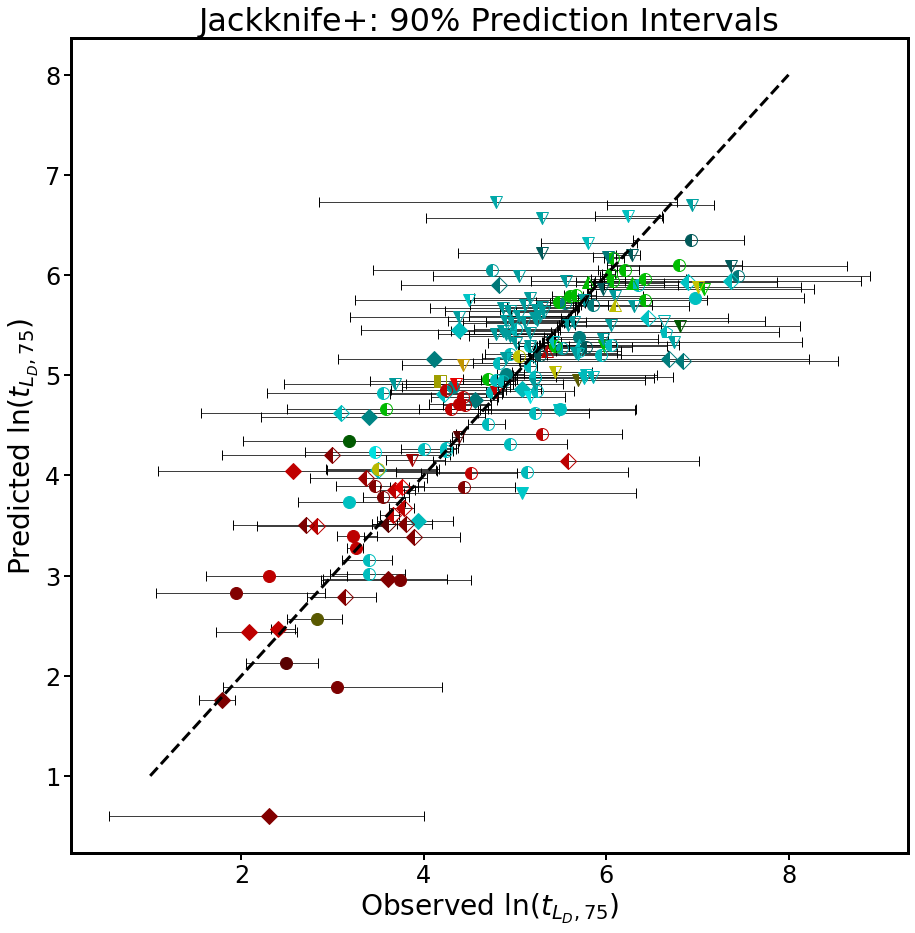

In [91]:
# make a parity plot with CIs

fig,ax = plt.subplots(figsize=(15,15))
ax.errorbar(Y,medians,xerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)
    
for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    
    ax.plot(Y.iloc[i],medians[i],color=color,marker=marker,fillstyle=fill,linestyle=style)
    
    
x = np.linspace(1,8,num=2)
ax.plot(x,x,'k--')
ax.set_xlabel('Observed ln($t_{L_D,75}$)')
ax.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax.set_title('Jackknife+: 90% Prediction Intervals')



Text(0.5, 0, 'Trial #')

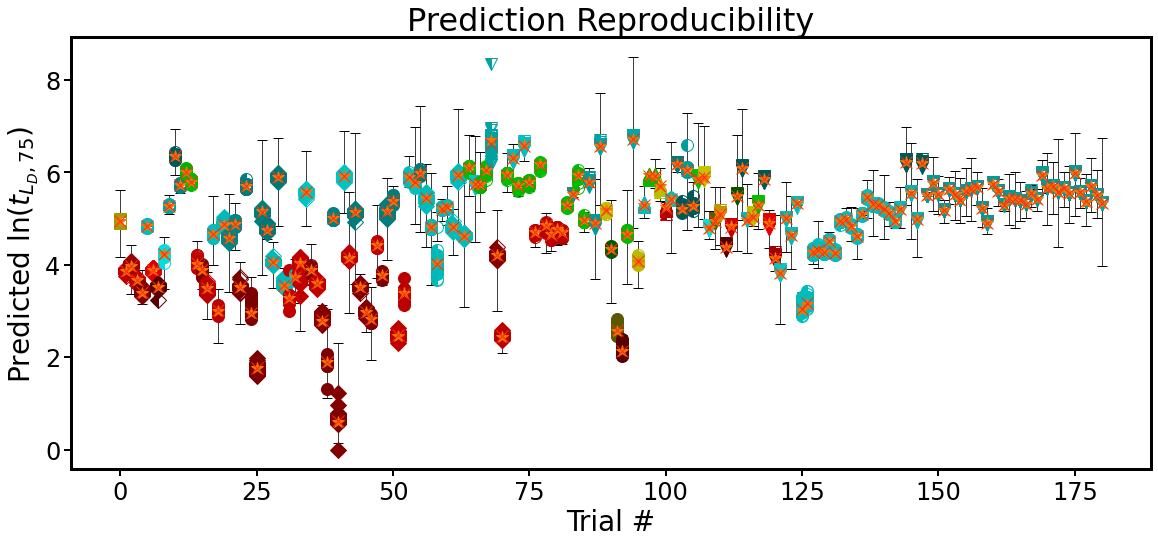

In [82]:
fig2 = plt.figure(figsize=(15,10))
ax2 = fig2.add_axes([0,0.4,1,0.6])

ax2.errorbar(range(len(medians)),medians,yerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)   

for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = rawdata_df['Temp (deg C)'][idx] # get temperature
    RH = rawdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = rawdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = rawdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    ax2.plot(np.ones(j)*i,list(F[i,:])[:i]+list(F[i,:])[i+1:],color=color,marker=marker,fillstyle=fill,linestyle=style)


ax2.plot(range(len(medians)),medians,marker='*',color='xkcd:orange',linestyle='')
ax2.plot(range(len(means)),means,marker='x',color='xkcd:vermillion',linestyle='')
    
ax2.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax2.set_title('Prediction Reproducibility')
ax2.set_xlabel('Trial #')
#ax2.set_xticklabels([])

# ax3 = fig2.add_axes([0,0,1,0.37])
# ax3.set_xlabel('Trial #')
# ax3.plot(range(len(medians)),stds/medians*100,marker='*',color='xkcd:orange',linestyle='')
# ax3.plot(range(len(means)),stds/means*100,marker='x',color='xkcd:vermillion',linestyle='')
# ax3.hlines(np.mean(stds/medians*100),0,len(medians),color='xkcd:orange',linestyle='--')
# ax3.hlines(np.mean(stds/means*100),0,len(means),color='xkcd:vermillion',linestyle='--')
# ax3.set_ylabel('$\sigma$ [%]')

In [17]:
asym_error

[-0.8262803416362052, 0.8578209307686961]